## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


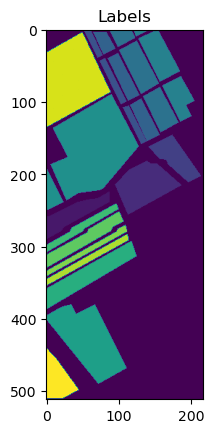

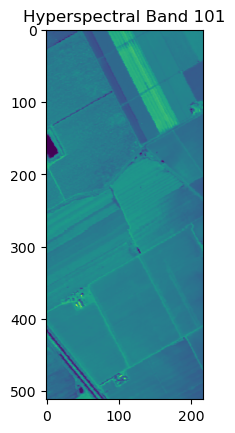

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53889 samples
	shape (53889, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(160, 5, 5, 204)
(80, 5, 5, 204)
(53889, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 160
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1565, PSNR: 7.1484


	 Training Batch [200/677], Loss: 0.0884, PSNR: 9.6671


	 Training Batch [400/677], Loss: 0.0458, PSNR: 12.5147


	 Training Batch [600/677], Loss: 0.0246, PSNR: 15.2531


Epoch [1/50] Training Loss: 0.0673, PSNR: 11.6087
	[Val]   Batch [1/170] Loss: 0.0213, PSNR: 15.8101
	[Val]   Batch [10/170] Loss: 0.0209, PSNR: 15.9714
	[Val]   Batch [20/170] Loss: 0.0211, PSNR: 15.8680
	[Val]   Batch [30/170] Loss: 0.0218, PSNR: 15.6643
	[Val]   Batch [40/170] Loss: 0.0219, PSNR: 15.7350


	[Val]   Batch [50/170] Loss: 0.0207, PSNR: 15.9436
	[Val]   Batch [60/170] Loss: 0.0216, PSNR: 15.8280
	[Val]   Batch [70/170] Loss: 0.0212, PSNR: 15.9153
	[Val]   Batch [80/170] Loss: 0.0215, PSNR: 15.7345


	[Val]   Batch [90/170] Loss: 0.0209, PSNR: 15.9734
	[Val]   Batch [100/170] Loss: 0.0209, PSNR: 15.8967
	[Val]   Batch [110/170] Loss: 0.0210, PSNR: 15.8731
	[Val]   Batch [120/170] Loss: 0.0198, PSNR: 14.1827
	[Val]   Batch [130/170] Loss: 0.0208, PSNR: 15.9859


	[Val]   Batch [140/170] Loss: 0.0205, PSNR: 16.0250
	[Val]   Batch [150/170] Loss: 0.0219, PSNR: 15.7769
	[Val]   Batch [160/170] Loss: 0.0215, PSNR: 15.8148
	[Val]   Batch [170/170] Loss: 0.0224, PSNR: 15.0967
Epoch [1/50] Validation Loss: 0.0213, PSNR: 15.7969

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0199, PSNR: 15.5984


	 Training Batch [200/677], Loss: 0.0152, PSNR: 17.2944


	 Training Batch [400/677], Loss: 0.0113, PSNR: 18.6514


	 Training Batch [600/677], Loss: 0.0086, PSNR: 19.3165


Epoch [2/50] Training Loss: 0.0130, PSNR: 18.0802
	[Val]   Batch [1/170] Loss: 0.0088, PSNR: 19.6667
	[Val]   Batch [10/170] Loss: 0.0083, PSNR: 20.0113
	[Val]   Batch [20/170] Loss: 0.0084, PSNR: 19.8764
	[Val]   Batch [30/170] Loss: 0.0091, PSNR: 19.4736
	[Val]   Batch [40/170] Loss: 0.0093, PSNR: 19.4559


	[Val]   Batch [50/170] Loss: 0.0081, PSNR: 20.0313
	[Val]   Batch [60/170] Loss: 0.0091, PSNR: 19.6113
	[Val]   Batch [70/170] Loss: 0.0088, PSNR: 19.7135
	[Val]   Batch [80/170] Loss: 0.0089, PSNR: 19.5738
	[Val]   Batch [90/170] Loss: 0.0085, PSNR: 19.8692


	[Val]   Batch [100/170] Loss: 0.0086, PSNR: 19.7832
	[Val]   Batch [110/170] Loss: 0.0084, PSNR: 19.8442
	[Val]   Batch [120/170] Loss: 0.0073, PSNR: 18.5019
	[Val]   Batch [130/170] Loss: 0.0085, PSNR: 19.8724
	[Val]   Batch [140/170] Loss: 0.0079, PSNR: 20.1603


	[Val]   Batch [150/170] Loss: 0.0093, PSNR: 19.5035
	[Val]   Batch [160/170] Loss: 0.0090, PSNR: 19.6078
	[Val]   Batch [170/170] Loss: 0.0093, PSNR: 18.9012
Epoch [2/50] Validation Loss: 0.0086, PSNR: 19.7092

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0088, PSNR: 19.6569


	 Training Batch [200/677], Loss: 0.0074, PSNR: 20.3451


	 Training Batch [400/677], Loss: 0.0057, PSNR: 20.9254


	 Training Batch [600/677], Loss: 0.0047, PSNR: 22.3192


Epoch [3/50] Training Loss: 0.0065, PSNR: 20.9971
	[Val]   Batch [1/170] Loss: 0.0048, PSNR: 22.2648
	[Val]   Batch [10/170] Loss: 0.0046, PSNR: 22.5849
	[Val]   Batch [20/170] Loss: 0.0046, PSNR: 22.4659
	[Val]   Batch [30/170] Loss: 0.0050, PSNR: 22.0243
	[Val]   Batch [40/170] Loss: 0.0051, PSNR: 22.0229


	[Val]   Batch [50/170] Loss: 0.0045, PSNR: 22.5528
	[Val]   Batch [60/170] Loss: 0.0050, PSNR: 22.1731
	[Val]   Batch [70/170] Loss: 0.0049, PSNR: 22.3014
	[Val]   Batch [80/170] Loss: 0.0049, PSNR: 22.1679
	[Val]   Batch [90/170] Loss: 0.0047, PSNR: 22.4217


	[Val]   Batch [100/170] Loss: 0.0048, PSNR: 22.3035
	[Val]   Batch [110/170] Loss: 0.0047, PSNR: 22.3948
	[Val]   Batch [120/170] Loss: 0.0041, PSNR: 21.0344
	[Val]   Batch [130/170] Loss: 0.0047, PSNR: 22.4106


	[Val]   Batch [140/170] Loss: 0.0043, PSNR: 22.7617
	[Val]   Batch [150/170] Loss: 0.0051, PSNR: 22.0757
	[Val]   Batch [160/170] Loss: 0.0050, PSNR: 22.1813
	[Val]   Batch [170/170] Loss: 0.0051, PSNR: 21.5495
Epoch [3/50] Validation Loss: 0.0048, PSNR: 22.2849

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0052, PSNR: 21.9449


	 Training Batch [200/677], Loss: 0.0038, PSNR: 23.3710


	 Training Batch [400/677], Loss: 0.0033, PSNR: 23.8870


	 Training Batch [600/677], Loss: 0.0033, PSNR: 23.9197


Epoch [4/50] Training Loss: 0.0037, PSNR: 23.4371
	[Val]   Batch [1/170] Loss: 0.0028, PSNR: 24.6820
	[Val]   Batch [10/170] Loss: 0.0027, PSNR: 24.9184
	[Val]   Batch [20/170] Loss: 0.0027, PSNR: 24.8025
	[Val]   Batch [30/170] Loss: 0.0030, PSNR: 24.3361
	[Val]   Batch [40/170] Loss: 0.0029, PSNR: 24.5134


	[Val]   Batch [50/170] Loss: 0.0027, PSNR: 24.7809
	[Val]   Batch [60/170] Loss: 0.0029, PSNR: 24.5587
	[Val]   Batch [70/170] Loss: 0.0028, PSNR: 24.7733
	[Val]   Batch [80/170] Loss: 0.0028, PSNR: 24.6004
	[Val]   Batch [90/170] Loss: 0.0027, PSNR: 24.7762


	[Val]   Batch [100/170] Loss: 0.0029, PSNR: 24.5491
	[Val]   Batch [110/170] Loss: 0.0027, PSNR: 24.7908
	[Val]   Batch [120/170] Loss: 0.0025, PSNR: 23.1167
	[Val]   Batch [130/170] Loss: 0.0028, PSNR: 24.6456
	[Val]   Batch [140/170] Loss: 0.0025, PSNR: 25.0820


	[Val]   Batch [150/170] Loss: 0.0029, PSNR: 24.5058
	[Val]   Batch [160/170] Loss: 0.0028, PSNR: 24.6165
	[Val]   Batch [170/170] Loss: 0.0029, PSNR: 23.9487
Epoch [4/50] Validation Loss: 0.0028, PSNR: 24.6391

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0029, PSNR: 24.5215


	 Training Batch [200/677], Loss: 0.0025, PSNR: 25.1911


	 Training Batch [400/677], Loss: 0.0022, PSNR: 25.7977


	 Training Batch [600/677], Loss: 0.0025, PSNR: 25.1098


Epoch [5/50] Training Loss: 0.0024, PSNR: 25.2980
	[Val]   Batch [1/170] Loss: 0.0019, PSNR: 26.3334
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.5892
	[Val]   Batch [20/170] Loss: 0.0019, PSNR: 26.4059
	[Val]   Batch [30/170] Loss: 0.0021, PSNR: 25.8996
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.2640


	[Val]   Batch [50/170] Loss: 0.0019, PSNR: 26.3726
	[Val]   Batch [60/170] Loss: 0.0020, PSNR: 26.1827
	[Val]   Batch [70/170] Loss: 0.0019, PSNR: 26.4946
	[Val]   Batch [80/170] Loss: 0.0019, PSNR: 26.2674
	[Val]   Batch [90/170] Loss: 0.0019, PSNR: 26.4265


	[Val]   Batch [100/170] Loss: 0.0020, PSNR: 26.0925
	[Val]   Batch [110/170] Loss: 0.0018, PSNR: 26.5709
	[Val]   Batch [120/170] Loss: 0.0018, PSNR: 24.6142
	[Val]   Batch [130/170] Loss: 0.0020, PSNR: 26.1771
	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.7243


	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.1474
	[Val]   Batch [160/170] Loss: 0.0019, PSNR: 26.2875
	[Val]   Batch [170/170] Loss: 0.0020, PSNR: 25.5936
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.2673

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0020, PSNR: 26.0168


	 Training Batch [200/677], Loss: 0.0018, PSNR: 26.3639


	 Training Batch [400/677], Loss: 0.0019, PSNR: 26.3265


	 Training Batch [600/677], Loss: 0.0013, PSNR: 27.8492


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.5819
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.6481
	[Val]   Batch [10/170] Loss: 0.0013, PSNR: 27.8985
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.6906
	[Val]   Batch [30/170] Loss: 0.0016, PSNR: 27.1240
	[Val]   Batch [40/170] Loss: 0.0014, PSNR: 27.6328


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.5929
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.4660
	[Val]   Batch [70/170] Loss: 0.0014, PSNR: 27.8747
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.5887
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.7436


	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.2988
	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 27.9730
	[Val]   Batch [120/170] Loss: 0.0014, PSNR: 25.8059
	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.3850
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 28.0536


	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.4222
	[Val]   Batch [160/170] Loss: 0.0014, PSNR: 27.6038
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.9298
Epoch [6/50] Validation Loss: 0.0014, PSNR: 27.5548

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0016, PSNR: 26.9873


	 Training Batch [200/677], Loss: 0.0017, PSNR: 26.9496


	 Training Batch [400/677], Loss: 0.0013, PSNR: 28.1275


	 Training Batch [600/677], Loss: 0.0014, PSNR: 27.7382


Epoch [7/50] Training Loss: 0.0014, PSNR: 27.5725
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.6582
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.9017
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.6693
	[Val]   Batch [30/170] Loss: 0.0013, PSNR: 28.0606
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.6798


	[Val]   Batch [50/170] Loss: 0.0012, PSNR: 28.4894
	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.4378
	[Val]   Batch [70/170] Loss: 0.0010, PSNR: 28.9675
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.6046


	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.7763
	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.2636
	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 29.0509
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.7035
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.3505


	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 29.0606
	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.3897
	[Val]   Batch [160/170] Loss: 0.0011, PSNR: 28.6144
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.9474
Epoch [7/50] Validation Loss: 0.0011, PSNR: 28.5418

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0015, PSNR: 27.4056


	 Training Batch [200/677], Loss: 0.0010, PSNR: 28.9737


	 Training Batch [400/677], Loss: 0.0013, PSNR: 27.8745


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.4680


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.3704
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.5709
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.7958
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.5479
	[Val]   Batch [30/170] Loss: 0.0010, PSNR: 28.9072
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.6431


	[Val]   Batch [50/170] Loss: 0.0009, PSNR: 29.3562
	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.3229
	[Val]   Batch [70/170] Loss: 0.0008, PSNR: 29.9051
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.5143
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.7161


	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 29.0981
	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 30.0163
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.5303
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.1860
	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 29.9899


	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.2421
	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.5026
	[Val]   Batch [170/170] Loss: 0.0009, PSNR: 28.8472
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.4189

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0012, PSNR: 28.3060


	 Training Batch [200/677], Loss: 0.0010, PSNR: 29.3452


	 Training Batch [400/677], Loss: 0.0010, PSNR: 29.1742


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.7622


Epoch [9/50] Training Loss: 0.0010, PSNR: 29.0828
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.3517
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.6055
	[Val]   Batch [20/170] Loss: 0.0008, PSNR: 30.3374
	[Val]   Batch [30/170] Loss: 0.0009, PSNR: 29.7108
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.4497


	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.1105
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.1260
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.7039
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.3466


	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.5801
	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 29.9372
	[Val]   Batch [110/170] Loss: 0.0007, PSNR: 30.8548
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.3132
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 30.0186


	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.8134
	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 30.0501
	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.2712
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.6973
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.2204

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0009, PSNR: 29.6402


	 Training Batch [200/677], Loss: 0.0009, PSNR: 29.4130


	 Training Batch [400/677], Loss: 0.0008, PSNR: 30.1030


	 Training Batch [600/677], Loss: 0.0008, PSNR: 29.7073


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.7434
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.3307
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.6005
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.2655
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.7083
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.4492


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 30.9880
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.1234
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.6915
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.3795
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.6238


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.9574
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 31.8808
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.2315
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 31.0421


	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 31.7949
	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.0610
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.2379
	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 30.8018
Epoch [10/50] Validation Loss: 0.0006, PSNR: 31.2059

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 29.8664


	 Training Batch [200/677], Loss: 0.0008, PSNR: 29.9196


	 Training Batch [400/677], Loss: 0.0008, PSNR: 30.2986


	 Training Batch [600/677], Loss: 0.0008, PSNR: 30.3000


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.3079
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.9214
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.2534
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 31.8447
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.3981
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.0450


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.5943
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 31.7839
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.2367
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 32.0481
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.2866


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.6667
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.5148
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 29.8627
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.7493
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.4109


	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.7476
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 31.8208
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.6320
Epoch [11/50] Validation Loss: 0.0005, PSNR: 31.8417

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.7365


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.2377


	 Training Batch [400/677], Loss: 0.0008, PSNR: 30.1773


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.7183


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.8250
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.5239
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 32.8846
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.4278
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.0534
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 32.6144


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.2103
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.4253
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 32.7678
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.6841
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 32.9529


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.3485
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.0974
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.5607
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.4276
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.0417


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.3805
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.3737
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.3767
Epoch [12/50] Validation Loss: 0.0005, PSNR: 32.4605

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.4684


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.9137


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.1260


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.2629


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.2742
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 32.8513
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.2032
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.7310
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.4538
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 32.9586


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.5033
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 32.8229
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.0847
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.0317
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.3753


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 32.8122
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.3994
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 30.9237
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 32.8991
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.3323


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 32.8063
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.6929
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.7456
Epoch [13/50] Validation Loss: 0.0004, PSNR: 32.8143

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 30.2214


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.6844


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.6344


	 Training Batch [600/677], Loss: 0.0008, PSNR: 30.2277


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.6367
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.5385
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 33.8944
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.3740
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.1651
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.6561


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.1266
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.5414
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.7413
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.7892
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.1032


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.5215
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.1453
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.5504
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.6019
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.0234


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.5307
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.3340
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.6178
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.5083

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.5790


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.4309


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.2501


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.6283


Epoch [15/50] Training Loss: 0.0005, PSNR: 31.9962
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.0750
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.4520
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.8537
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.7596
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.1933
	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.6380


	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.1082
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.1870
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.3605
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.6646
	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.0615


	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.6429
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.0620
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.1603
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.5509


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.0939
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 33.8027
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.2727
Epoch [15/50] Validation Loss: 0.0003, PSNR: 34.0472

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.1124


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.2936


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.4149


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.4858


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.2813
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.3585
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.7539
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.1309
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.0599
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.4419


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.8892
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.4119
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.4913
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.6496
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.9824


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.4330
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.9413
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.3704
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.5546
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.8334


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.4333
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.0674
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.6492
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.3424

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.1432


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.8887


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.1650


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.3900


Epoch [17/50] Training Loss: 0.0005, PSNR: 32.5267
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.6291
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.9911
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.3204
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.3813
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.7463


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.1423
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.7388
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.7586
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.9172
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.3034


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.7603
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.1935
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.6453
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.8763
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 35.0684


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.7260
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.3194
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.9136
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.6070

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.2298


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.9553


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.9407


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.8294


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.7856
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 35.0756
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.4736
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.7762
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.8560
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.2262


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.5488
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.2310
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.1863
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.4282
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.8147


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.2134
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.6709
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 33.0732
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.3388
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.5546


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.2438
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.7469
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.4714
Epoch [18/50] Validation Loss: 0.0003, PSNR: 35.0761
Early stopping triggered at epoch 18. No improvement for 3 epochs.


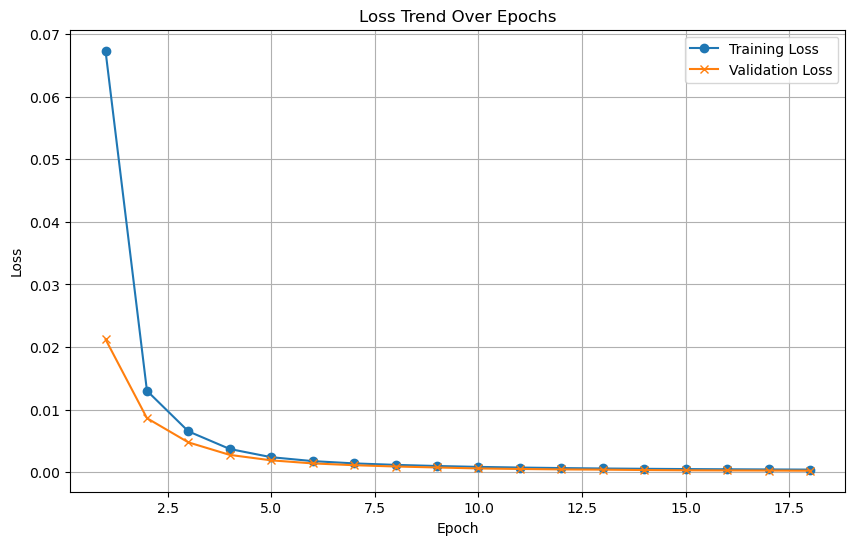

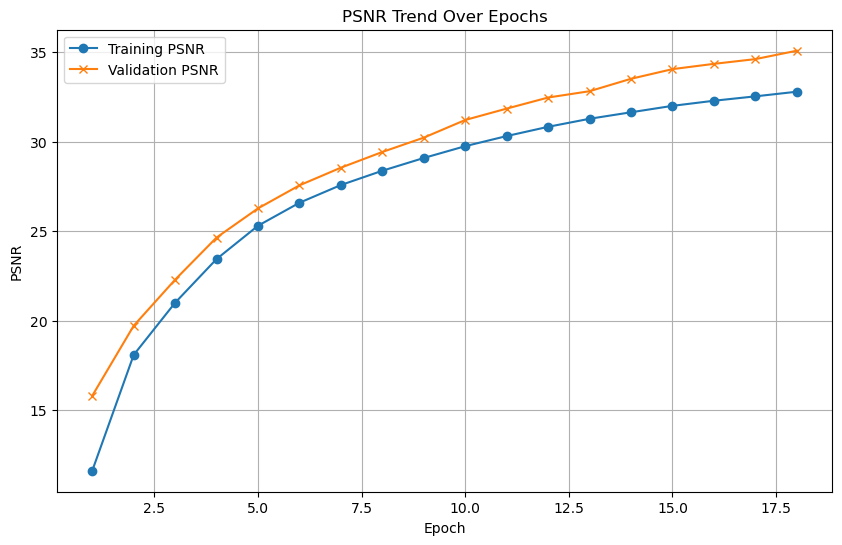

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/211 for test dataset.


    Processed batch 101/211 for test dataset.


    Processed batch 201/211 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7898
    Validation Batch [1/1], Loss: 2.7788
Validation Loss: 2.7788, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7788. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7445
    Validation Batch [1/1], Loss: 2.7788
Validation Loss: 2.7788, Validation Accuracy: 6.25%
Validation loss improved from 2.7788 to 2.7788. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7035
    Validation Batch [1/1], Loss: 2.7788
Validation Loss: 2.7788, Validation Accuracy: 6.25%
Validation loss improved from 2.7788 to 2.7788. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6868
    Validation Batch [1/1], Loss: 2.7787
Validation Loss: 2.7787, Validation Accuracy: 6.25%
Validation loss improved from 2.7788 to 2.7787. Saving model...

LOG: Epoch [5/1000] - 

Epoch [19/1000] completed, Average Training Loss: 2.4698
    Validation Batch [1/1], Loss: 2.7782
Validation Loss: 2.7782, Validation Accuracy: 6.25%
Validation loss improved from 2.7784 to 2.7782. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.4348
    Validation Batch [1/1], Loss: 2.7778
Validation Loss: 2.7778, Validation Accuracy: 6.25%
Validation loss improved from 2.7782 to 2.7778. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.4287
    Validation Batch [1/1], Loss: 2.7773
Validation Loss: 2.7773, Validation Accuracy: 6.25%
Validation loss improved from 2.7778 to 2.7773. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4199
    Validation Batch [1/1], Loss: 2.7769
Validation Loss: 2.7769, Validation Accuracy: 6.25%
Validation loss improved from 2.7773 to 2.7769. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/10

Epoch [45/1000] completed, Average Training Loss: 2.2147
    Validation Batch [1/1], Loss: 2.6676
Validation Loss: 2.6676, Validation Accuracy: 6.25%
Validation loss improved from 2.6839 to 2.6676. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 2.2043
    Validation Batch [1/1], Loss: 2.6518
Validation Loss: 2.6518, Validation Accuracy: 6.25%
Validation loss improved from 2.6676 to 2.6518. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 2.2151
    Validation Batch [1/1], Loss: 2.6371
Validation Loss: 2.6371, Validation Accuracy: 6.25%
Validation loss improved from 2.6518 to 2.6371. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 2.1750
    Validation Batch [1/1], Loss: 2.6243
Validation Loss: 2.6243, Validation Accuracy: 6.25%
Validation loss improved from 2.6371 to 2.6243. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/10

    Validation Batch [1/1], Loss: 2.1563
Validation Loss: 2.1563, Validation Accuracy: 55.00%
Validation loss improved from 2.1724 to 2.1563. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 1.9711
    Validation Batch [1/1], Loss: 2.1394
Validation Loss: 2.1394, Validation Accuracy: 56.25%
Validation loss improved from 2.1563 to 2.1394. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 2.0249
    Validation Batch [1/1], Loss: 2.1249
Validation Loss: 2.1249, Validation Accuracy: 58.75%
Validation loss improved from 2.1394 to 2.1249. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.9578
    Validation Batch [1/1], Loss: 2.1101
Validation Loss: 2.1101, Validation Accuracy: 60.00%
Validation loss improved from 2.1249 to 2.1101. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.9898
    Vali

Epoch [99/1000] completed, Average Training Loss: 1.8318
    Validation Batch [1/1], Loss: 1.8940
Validation Loss: 1.8940, Validation Accuracy: 73.75%
Validation loss improved from 1.9007 to 1.8940. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.8161
    Validation Batch [1/1], Loss: 1.8910
Validation Loss: 1.8910, Validation Accuracy: 75.00%
Validation loss improved from 1.8940 to 1.8910. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.8067
    Validation Batch [1/1], Loss: 1.8778
Validation Loss: 1.8778, Validation Accuracy: 75.00%
Validation loss improved from 1.8910 to 1.8778. Saving model...

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 1.8244
    Validation Batch [1/1], Loss: 1.8706
Validation Loss: 1.8706, Validation Accuracy: 76.25%
Validation loss improved from 1.8778 to 1.8706. Saving model...

LOG: Epoch [103/1000] - Training
E

Epoch [126/1000] completed, Average Training Loss: 1.6475
    Validation Batch [1/1], Loss: 1.7056
Validation Loss: 1.7056, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 1.5924
    Validation Batch [1/1], Loss: 1.7190
Validation Loss: 1.7190, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 1.5992
    Validation Batch [1/1], Loss: 1.6342
Validation Loss: 1.6342, Validation Accuracy: 76.25%
Validation loss improved from 1.6596 to 1.6342. Saving model...

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 1.6056
    Validation Batch [1/1], Loss: 1.6395
Validation Loss: 1.6395, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Average Training 

Epoch [153/1000] completed, Average Training Loss: 1.4224
    Validation Batch [1/1], Loss: 1.4591
Validation Loss: 1.4591, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.3729
    Validation Batch [1/1], Loss: 1.4384
Validation Loss: 1.4384, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.3898
    Validation Batch [1/1], Loss: 1.4458
Validation Loss: 1.4458, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 1.3862
    Validation Batch [1/1], Loss: 1.4227
Validation Loss: 1.4227, Validation Accuracy: 78.75%
Validation loss improved from 1.4384 to 1.4227. Saving model...

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training 

Epoch [180/1000] completed, Average Training Loss: 1.2177
    Validation Batch [1/1], Loss: 1.2492
Validation Loss: 1.2492, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.1670
    Validation Batch [1/1], Loss: 1.2260
Validation Loss: 1.2260, Validation Accuracy: 85.00%
Validation loss improved from 1.2460 to 1.2260. Saving model...

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.1836
    Validation Batch [1/1], Loss: 1.2446
Validation Loss: 1.2446, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 1.1696
    Validation Batch [1/1], Loss: 1.2323
Validation Loss: 1.2323, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training 

Epoch [206/1000] completed, Average Training Loss: 0.9643
    Validation Batch [1/1], Loss: 1.0292
Validation Loss: 1.0292, Validation Accuracy: 91.25%
Validation loss improved from 1.0556 to 1.0292. Saving model...

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.9736
    Validation Batch [1/1], Loss: 1.0112
Validation Loss: 1.0112, Validation Accuracy: 86.25%
Validation loss improved from 1.0292 to 1.0112. Saving model...

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.9512
    Validation Batch [1/1], Loss: 1.0033
Validation Loss: 1.0033, Validation Accuracy: 88.75%
Validation loss improved from 1.0112 to 1.0033. Saving model...

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 1.0008
    Validation Batch [1/1], Loss: 1.0225
Validation Loss: 1.0225, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000

Epoch [233/1000] completed, Average Training Loss: 0.7967
    Validation Batch [1/1], Loss: 0.8685
Validation Loss: 0.8685, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.8485
    Validation Batch [1/1], Loss: 0.8638
Validation Loss: 0.8638, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.7529
    Validation Batch [1/1], Loss: 0.8222
Validation Loss: 0.8222, Validation Accuracy: 91.25%
Validation loss improved from 0.8631 to 0.8222. Saving model...

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.7776
    Validation Batch [1/1], Loss: 0.8174
Validation Loss: 0.8174, Validation Accuracy: 90.00%
Validation loss improved from 0.8222 to 0.8174. Saving model...

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Av

    Validation Batch [1/1], Loss: 0.6813
Validation Loss: 0.6813, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.5966
    Validation Batch [1/1], Loss: 0.6710
Validation Loss: 0.6710, Validation Accuracy: 91.25%
Validation loss improved from 0.6753 to 0.6710. Saving model...

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.5938
    Validation Batch [1/1], Loss: 0.6558
Validation Loss: 0.6558, Validation Accuracy: 92.50%
Validation loss improved from 0.6710 to 0.6558. Saving model...

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.6322
    Validation Batch [1/1], Loss: 0.6472
Validation Loss: 0.6472, Validation Accuracy: 92.50%
Validation loss improved from 0.6558 to 0.6472. Saving model...

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Training Loss: 0.5635
    Validation 

    Validation Batch [1/1], Loss: 0.5797
Validation Loss: 0.5797, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.4669
    Validation Batch [1/1], Loss: 0.5472
Validation Loss: 0.5472, Validation Accuracy: 93.75%
Validation loss improved from 0.5617 to 0.5472. Saving model...

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.4637
    Validation Batch [1/1], Loss: 0.5475
Validation Loss: 0.5475, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.4744
    Validation Batch [1/1], Loss: 0.5658
Validation Loss: 0.5658, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.4610
    Validation Batch [1/1], Loss: 0.5564
Vali

Epoch [316/1000] completed, Average Training Loss: 0.3513
    Validation Batch [1/1], Loss: 0.4627
Validation Loss: 0.4627, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.3754
    Validation Batch [1/1], Loss: 0.4518
Validation Loss: 0.4518, Validation Accuracy: 93.75%
Validation loss improved from 0.4559 to 0.4518. Saving model...

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.3556
    Validation Batch [1/1], Loss: 0.4568
Validation Loss: 0.4568, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.3448
    Validation Batch [1/1], Loss: 0.4629
Validation Loss: 0.4629, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training 

Epoch [344/1000] completed, Average Training Loss: 0.3084
    Validation Batch [1/1], Loss: 0.3919
Validation Loss: 0.3919, Validation Accuracy: 92.50%
Validation loss improved from 0.3983 to 0.3919. Saving model...

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.3090
    Validation Batch [1/1], Loss: 0.4073
Validation Loss: 0.4073, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.2900
    Validation Batch [1/1], Loss: 0.3998
Validation Loss: 0.3998, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.2864
    Validation Batch [1/1], Loss: 0.3970
Validation Loss: 0.3970, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training 

Epoch [370/1000] completed, Average Training Loss: 0.2470
    Validation Batch [1/1], Loss: 0.3804
Validation Loss: 0.3804, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.2523
    Validation Batch [1/1], Loss: 0.3593
Validation Loss: 0.3593, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.2444
    Validation Batch [1/1], Loss: 0.3644
Validation Loss: 0.3644, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.2390
    Validation Batch [1/1], Loss: 0.3469
Validation Loss: 0.3469, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.2683
 

    Validation Batch [1/1], Loss: 0.3153
Validation Loss: 0.3153, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.1995
    Validation Batch [1/1], Loss: 0.3307
Validation Loss: 0.3307, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.1866
    Validation Batch [1/1], Loss: 0.3091
Validation Loss: 0.3091, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.2032
    Validation Batch [1/1], Loss: 0.3147
Validation Loss: 0.3147, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.2051
    Validation Batch [1/1], Loss: 0.3054
Validation Loss: 0.

Epoch [423/1000] completed, Average Training Loss: 0.1641
    Validation Batch [1/1], Loss: 0.2787
Validation Loss: 0.2787, Validation Accuracy: 93.75%
Validation loss improved from 0.2849 to 0.2787. Saving model...

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1830
    Validation Batch [1/1], Loss: 0.2790
Validation Loss: 0.2790, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1625
    Validation Batch [1/1], Loss: 0.2861
Validation Loss: 0.2861, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1792
    Validation Batch [1/1], Loss: 0.2800
Validation Loss: 0.2800, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.2768
Validation Loss: 0.2768, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.1362
    Validation Batch [1/1], Loss: 0.2916
Validation Loss: 0.2916, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [451/1000] - Training
Epoch [451/1000] completed, Average Training Loss: 0.1233
    Validation Batch [1/1], Loss: 0.3002
Validation Loss: 0.3002, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.1409
    Validation Batch [1/1], Loss: 0.2829
Validation Loss: 0.2829, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.1442
    Validation Batch [1/1], Loss: 0.2535
Validation Loss: 0.

Epoch [478/1000] completed, Average Training Loss: 0.1200
    Validation Batch [1/1], Loss: 0.2724
Validation Loss: 0.2724, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.1404
    Validation Batch [1/1], Loss: 0.2949
Validation Loss: 0.2949, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Training Loss: 0.1393
    Validation Batch [1/1], Loss: 0.3048
Validation Loss: 0.3048, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Training Loss: 0.1257
    Validation Batch [1/1], Loss: 0.3051
Validation Loss: 0.3051, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.137

Epoch [505/1000] completed, Average Training Loss: 0.0987
    Validation Batch [1/1], Loss: 0.2508
Validation Loss: 0.2508, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [506/1000] - Training
Epoch [506/1000] completed, Average Training Loss: 0.0996
    Validation Batch [1/1], Loss: 0.2384
Validation Loss: 0.2384, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [507/1000] - Training
Epoch [507/1000] completed, Average Training Loss: 0.1489
    Validation Batch [1/1], Loss: 0.2415
Validation Loss: 0.2415, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [508/1000] - Training
Epoch [508/1000] completed, Average Training Loss: 0.1122
    Validation Batch [1/1], Loss: 0.2602
Validation Loss: 0.2602, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.1269
  

Epoch [531/1000] completed, Average Training Loss: 0.0949
    Validation Batch [1/1], Loss: 0.2327
Validation Loss: 0.2327, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.1023
    Validation Batch [1/1], Loss: 0.2391
Validation Loss: 0.2391, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0896
    Validation Batch [1/1], Loss: 0.2289
Validation Loss: 0.2289, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0789
    Validation Batch [1/1], Loss: 0.2242
Validation Loss: 0.2242, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [535/1000] - Training
Epoch [535/1000] completed, Average Training Loss: 0.091

    Validation Batch [1/1], Loss: 0.2325
Validation Loss: 0.2325, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.1056
    Validation Batch [1/1], Loss: 0.2130
Validation Loss: 0.2130, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0866
    Validation Batch [1/1], Loss: 0.2151
Validation Loss: 0.2151, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0724
    Validation Batch [1/1], Loss: 0.2179
Validation Loss: 0.2179, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.0937
    Validation Batch [1/1], Loss: 0.2157
Validation Loss: 0

    Validation Batch [1/1], Loss: 0.2103
Validation Loss: 0.2103, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.0693
    Validation Batch [1/1], Loss: 0.2237
Validation Loss: 0.2237, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.0650
    Validation Batch [1/1], Loss: 0.2343
Validation Loss: 0.2343, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [589/1000] - Training
Epoch [589/1000] completed, Average Training Loss: 0.0733
    Validation Batch [1/1], Loss: 0.2318
Validation Loss: 0.2318, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [590/1000] - Training
Epoch [590/1000] completed, Average Training Loss: 0.0737
    Validation Batch [1/1], Loss: 0.2111
Validation Loss

Epoch [616/1000] completed, Average Training Loss: 0.0571
    Validation Batch [1/1], Loss: 0.2429
Validation Loss: 0.2429, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [617/1000] - Training
Epoch [617/1000] completed, Average Training Loss: 0.0507
    Validation Batch [1/1], Loss: 0.2374
Validation Loss: 0.2374, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [618/1000] - Training
Epoch [618/1000] completed, Average Training Loss: 0.0644
    Validation Batch [1/1], Loss: 0.2110
Validation Loss: 0.2110, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [619/1000] - Training
Epoch [619/1000] completed, Average Training Loss: 0.0933
    Validation Batch [1/1], Loss: 0.1960
Validation Loss: 0.1960, Validation Accuracy: 95.00%
Validation loss improved from 0.1977 to 0.1960. Saving model...

LOG: Epoch [620/1000] - Training
Epoch [620/1000] completed, Average Traini

Epoch [643/1000] completed, Average Training Loss: 0.0586
    Validation Batch [1/1], Loss: 0.2266
Validation Loss: 0.2266, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [644/1000] - Training
Epoch [644/1000] completed, Average Training Loss: 0.0604
    Validation Batch [1/1], Loss: 0.2415
Validation Loss: 0.2415, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [645/1000] - Training
Epoch [645/1000] completed, Average Training Loss: 0.0537
    Validation Batch [1/1], Loss: 0.2459
Validation Loss: 0.2459, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [646/1000] - Training
Epoch [646/1000] completed, Average Training Loss: 0.0565
    Validation Batch [1/1], Loss: 0.2111
Validation Loss: 0.2111, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [647/1000] - Training
Epoch [647/1000] completed, Average Training Loss: 0.068

Epoch [671/1000] completed, Average Training Loss: 0.0542
    Validation Batch [1/1], Loss: 0.2000
Validation Loss: 0.2000, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [672/1000] - Training
Epoch [672/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.2223
Validation Loss: 0.2223, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [673/1000] - Training
Epoch [673/1000] completed, Average Training Loss: 0.0477
    Validation Batch [1/1], Loss: 0.2213
Validation Loss: 0.2213, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [674/1000] - Training
Epoch [674/1000] completed, Average Training Loss: 0.0525
    Validation Batch [1/1], Loss: 0.2130
Validation Loss: 0.2130, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [675/1000] - Training
Epoch [675/1000] completed, Average Training Loss: 0.044

    Validation Batch [1/1], Loss: 0.2091
Validation Loss: 0.2091, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [698/1000] - Training
Epoch [698/1000] completed, Average Training Loss: 0.0445
    Validation Batch [1/1], Loss: 0.2130
Validation Loss: 0.2130, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [699/1000] - Training
Epoch [699/1000] completed, Average Training Loss: 0.0417
    Validation Batch [1/1], Loss: 0.2132
Validation Loss: 0.2132, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [700/1000] - Training
Epoch [700/1000] completed, Average Training Loss: 0.0533
    Validation Batch [1/1], Loss: 0.2074
Validation Loss: 0.2074, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [701/1000] - Training
Epoch [701/1000] completed, Average Training Loss: 0.0697
    Validation Batch [1/1], Loss: 0.2001
Validation Loss

Epoch [725/1000] completed, Average Training Loss: 0.0462
    Validation Batch [1/1], Loss: 0.1931
Validation Loss: 0.1931, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [726/1000] - Training
Epoch [726/1000] completed, Average Training Loss: 0.0405
    Validation Batch [1/1], Loss: 0.2011
Validation Loss: 0.2011, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [727/1000] - Training
Epoch [727/1000] completed, Average Training Loss: 0.0479
    Validation Batch [1/1], Loss: 0.2030
Validation Loss: 0.2030, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [728/1000] - Training
Epoch [728/1000] completed, Average Training Loss: 0.0477
    Validation Batch [1/1], Loss: 0.2124
Validation Loss: 0.2124, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [729/1000] - Training
Epoch [729/1000] completed, Average Training Loss: 0.039

Epoch [752/1000] completed, Average Training Loss: 0.0400
    Validation Batch [1/1], Loss: 0.1914
Validation Loss: 0.1914, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [753/1000] - Training
Epoch [753/1000] completed, Average Training Loss: 0.0305
    Validation Batch [1/1], Loss: 0.1966
Validation Loss: 0.1966, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [754/1000] - Training
Epoch [754/1000] completed, Average Training Loss: 0.0409
    Validation Batch [1/1], Loss: 0.2018
Validation Loss: 0.2018, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [755/1000] - Training
Epoch [755/1000] completed, Average Training Loss: 0.0352
    Validation Batch [1/1], Loss: 0.2039
Validation Loss: 0.2039, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [756/1000] - Training
Epoch [756/1000] completed, Average Training Loss: 0.035

Epoch [778/1000] completed, Average Training Loss: 0.0356
    Validation Batch [1/1], Loss: 0.1859
Validation Loss: 0.1859, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [779/1000] - Training
Epoch [779/1000] completed, Average Training Loss: 0.0362
    Validation Batch [1/1], Loss: 0.1914
Validation Loss: 0.1914, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [780/1000] - Training
Epoch [780/1000] completed, Average Training Loss: 0.0386
    Validation Batch [1/1], Loss: 0.1976
Validation Loss: 0.1976, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [781/1000] - Training
Epoch [781/1000] completed, Average Training Loss: 0.0278
    Validation Batch [1/1], Loss: 0.2030
Validation Loss: 0.2030, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [782/1000] - Training
Epoch [782/1000] completed, Average Training Loss: 0.0423
  

    Validation Batch [1/1], Loss: 0.2234
Validation Loss: 0.2234, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [806/1000] - Training
Epoch [806/1000] completed, Average Training Loss: 0.0399
    Validation Batch [1/1], Loss: 0.2210
Validation Loss: 0.2210, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [807/1000] - Training
Epoch [807/1000] completed, Average Training Loss: 0.0447
    Validation Batch [1/1], Loss: 0.1980
Validation Loss: 0.1980, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [808/1000] - Training
Epoch [808/1000] completed, Average Training Loss: 0.0346
    Validation Batch [1/1], Loss: 0.1797
Validation Loss: 0.1797, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [809/1000] - Training
Epoch [809/1000] completed, Average Training Loss: 0.0333
    Validation Batch [1/1], Loss: 0.1914
Validation Loss

    Validation Batch [1/1], Loss: 0.1896
Validation Loss: 0.1896, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [834/1000] - Training
Epoch [834/1000] completed, Average Training Loss: 0.0316
    Validation Batch [1/1], Loss: 0.1812
Validation Loss: 0.1812, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [835/1000] - Training
Epoch [835/1000] completed, Average Training Loss: 0.0344
    Validation Batch [1/1], Loss: 0.1750
Validation Loss: 0.1750, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [836/1000] - Training
Epoch [836/1000] completed, Average Training Loss: 0.0338
    Validation Batch [1/1], Loss: 0.1793
Validation Loss: 0.1793, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [837/1000] - Training
Epoch [837/1000] completed, Average Training Loss: 0.0387
    Validation Batch [1/1], Loss: 0.1823
Validation Loss

Epoch [861/1000] completed, Average Training Loss: 0.0255
    Validation Batch [1/1], Loss: 0.1749
Validation Loss: 0.1749, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [862/1000] - Training
Epoch [862/1000] completed, Average Training Loss: 0.0255
    Validation Batch [1/1], Loss: 0.1760
Validation Loss: 0.1760, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [863/1000] - Training
Epoch [863/1000] completed, Average Training Loss: 0.0420
    Validation Batch [1/1], Loss: 0.1986
Validation Loss: 0.1986, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [864/1000] - Training
Epoch [864/1000] completed, Average Training Loss: 0.0288
    Validation Batch [1/1], Loss: 0.2119
Validation Loss: 0.2119, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [865/1000] - Training
Epoch [865/1000] completed, Average Training Loss: 0.031

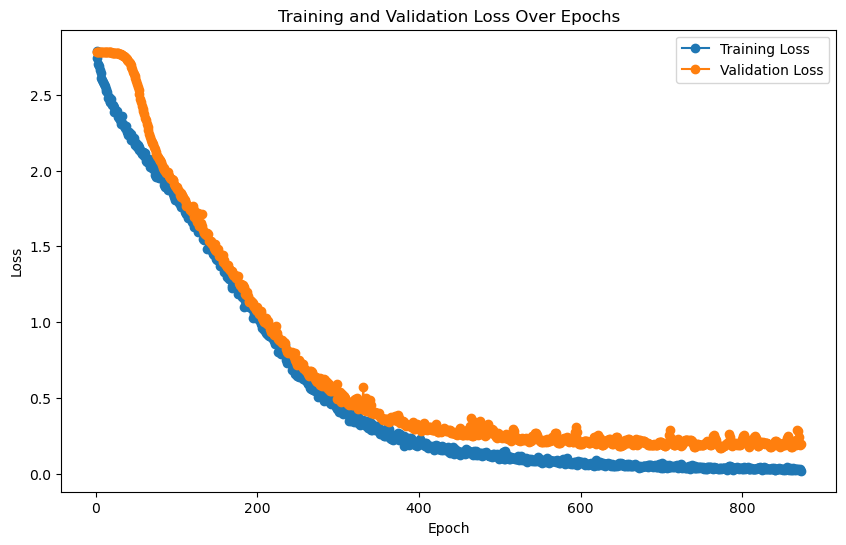

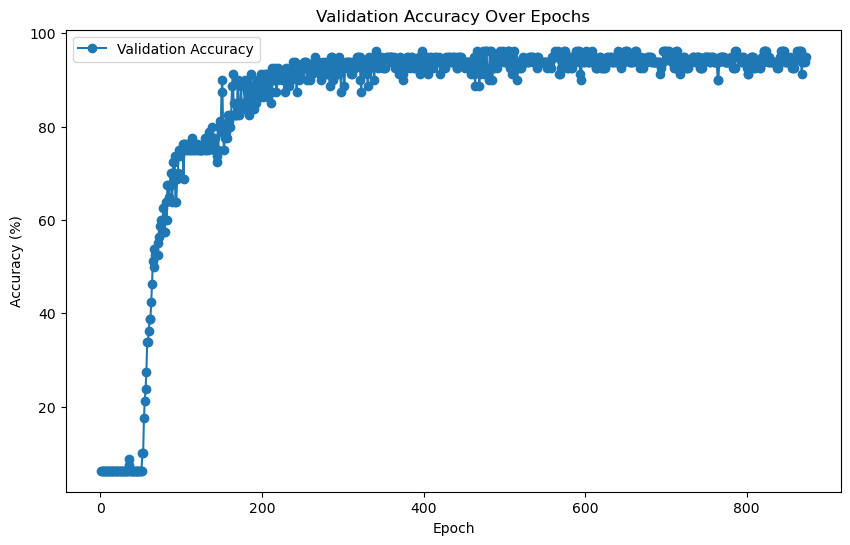


Evaluating on the test set...
    Test Batch [1/211], Loss: 0.3533



Final Test Loss: 0.4836, Test Accuracy: 83.39%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.


  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.
  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.
  Processed batch 80/211 for test dataset.


  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.
  Processed batch 130/211 for test dataset.


  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.
  Processed batch 180/211 for test dataset.


  Processed batch 190/211 for test dataset.
  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)

LOG: Training features shape: (160, 64), Training labels shape: (160,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53889, 64), Test labels shape: (53889,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 90.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       0.67      0.40      0.50         5
           8       0.67      0.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)
Train reps shape: (160, 64)
Train labels shape: (160,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53889, 64)
Test labels shape: (53889,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8198  |  Val Loss: 2.6969
Validation loss improved from inf to 2.6969.
[Epoch 2/1000] Train Loss: 2.6432  |  Val Loss: 2.5963
Validation loss improved from 2.6969 to 2.5963.
[Epoch 3/1000] Train Loss: 2.5412  |  Val Loss: 2.5099
Validation loss improved from 2.5963 to 2.5099.
[Epoch 4/1000] Train Loss: 2.4463  |  Val Loss: 2.4395
Validation loss improved from 2.5099 to 2.4395.
[Epoch 5/1000] Train Loss: 2.3709  |  Val Loss: 2.3742
Validation loss improved from 2.4395 to 2.3742.
[Epoch 6/1000] Train Loss: 2.2960  |  Val Loss: 2.3098
Validation loss improved from 2.3742 to 2.3098.
[Epoch 7/1000] Train Loss: 2.2206  |  Val Loss: 2.2455
Validation loss improved from 2.3098 to 2.2455.
[Epoch 8/1000] Train Loss: 2.1487  |  Val Loss: 2.1771
Validation loss improved from 2.2455 to 2.1771.
[Epoch 9/1000] Train Loss: 2.0690  |  Val Loss: 2.1006
Validation loss improved from 2.1771 to 2.1006.
[Epoch 10/1000] Train Loss: 1.9848  |  Val Loss: 2.0223
Validation loss impr

[Epoch 18/1000] Train Loss: 1.3920  |  Val Loss: 1.4884
Validation loss improved from 1.5438 to 1.4884.
[Epoch 19/1000] Train Loss: 1.3279  |  Val Loss: 1.4282
Validation loss improved from 1.4884 to 1.4282.
[Epoch 20/1000] Train Loss: 1.2700  |  Val Loss: 1.3714
Validation loss improved from 1.4282 to 1.3714.
[Epoch 21/1000] Train Loss: 1.2131  |  Val Loss: 1.3200
Validation loss improved from 1.3714 to 1.3200.
[Epoch 22/1000] Train Loss: 1.1583  |  Val Loss: 1.2717
Validation loss improved from 1.3200 to 1.2717.
[Epoch 23/1000] Train Loss: 1.1094  |  Val Loss: 1.2319
Validation loss improved from 1.2717 to 1.2319.
[Epoch 24/1000] Train Loss: 1.0629  |  Val Loss: 1.1832
Validation loss improved from 1.2319 to 1.1832.
[Epoch 25/1000] Train Loss: 1.0142  |  Val Loss: 1.1383
Validation loss improved from 1.1832 to 1.1383.
[Epoch 26/1000] Train Loss: 0.9752  |  Val Loss: 1.1036
Validation loss improved from 1.1383 to 1.1036.
[Epoch 27/1000] Train Loss: 0.9375  |  Val Loss: 1.0699
Validati

[Epoch 31/1000] Train Loss: 0.8026  |  Val Loss: 0.9454
Validation loss improved from 0.9624 to 0.9454.
[Epoch 32/1000] Train Loss: 0.7787  |  Val Loss: 0.9238
Validation loss improved from 0.9454 to 0.9238.
[Epoch 33/1000] Train Loss: 0.7556  |  Val Loss: 0.8910
Validation loss improved from 0.9238 to 0.8910.
[Epoch 34/1000] Train Loss: 0.7296  |  Val Loss: 0.8687
Validation loss improved from 0.8910 to 0.8687.
[Epoch 35/1000] Train Loss: 0.7069  |  Val Loss: 0.8566
Validation loss improved from 0.8687 to 0.8566.
[Epoch 36/1000] Train Loss: 0.6871  |  Val Loss: 0.8358
Validation loss improved from 0.8566 to 0.8358.
[Epoch 37/1000] Train Loss: 0.6677  |  Val Loss: 0.8152
Validation loss improved from 0.8358 to 0.8152.
[Epoch 38/1000] Train Loss: 0.6515  |  Val Loss: 0.7888
Validation loss improved from 0.8152 to 0.7888.
[Epoch 39/1000] Train Loss: 0.6287  |  Val Loss: 0.7917
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 0.6233  |  Val Loss: 0.7764
Va

[Epoch 48/1000] Train Loss: 0.5257  |  Val Loss: 0.6589
Validation loss improved from 0.6724 to 0.6589.
[Epoch 49/1000] Train Loss: 0.5135  |  Val Loss: 0.6671
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 50/1000] Train Loss: 0.5048  |  Val Loss: 0.6820
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 51/1000] Train Loss: 0.4935  |  Val Loss: 0.6354
Validation loss improved from 0.6589 to 0.6354.
[Epoch 52/1000] Train Loss: 0.4790  |  Val Loss: 0.6239
Validation loss improved from 0.6354 to 0.6239.
[Epoch 53/1000] Train Loss: 0.4730  |  Val Loss: 0.6295
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 54/1000] Train Loss: 0.4600  |  Val Loss: 0.6275
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 55/1000] Train Loss: 0.4616  |  Val Loss: 0.6331
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 56/1000] Train Loss: 0.4513  |  Val Loss: 0.6114
Validation loss improved from 0.6239 to 0.6114.
[Epoch 57/1000] Train Loss: 0.4406

[Epoch 60/1000] Train Loss: 0.4242  |  Val Loss: 0.5880
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 61/1000] Train Loss: 0.4244  |  Val Loss: 0.5863
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 62/1000] Train Loss: 0.4028  |  Val Loss: 0.5811
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 63/1000] Train Loss: 0.4156  |  Val Loss: 0.5758
Validation loss improved from 0.5782 to 0.5758.
[Epoch 64/1000] Train Loss: 0.3990  |  Val Loss: 0.5745
Validation loss improved from 0.5758 to 0.5745.
[Epoch 65/1000] Train Loss: 0.4110  |  Val Loss: 0.5615
Validation loss improved from 0.5745 to 0.5615.
[Epoch 66/1000] Train Loss: 0.3963  |  Val Loss: 0.5811
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 67/1000] Train Loss: 0.3911  |  Val Loss: 0.5938
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 68/1000] Train Loss: 0.3911  |  Val Loss: 0.5587
Validation loss improved from 0.5615 to 0.5587.
[Epoch 69/1000] Train Loss: 0.3740

[Epoch 78/1000] Train Loss: 0.3314  |  Val Loss: 0.5449
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 79/1000] Train Loss: 0.3290  |  Val Loss: 0.5340
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 80/1000] Train Loss: 0.3243  |  Val Loss: 0.5262
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 81/1000] Train Loss: 0.3182  |  Val Loss: 0.5298
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 82/1000] Train Loss: 0.3129  |  Val Loss: 0.5228
Validation loss improved from 0.5246 to 0.5228.
[Epoch 83/1000] Train Loss: 0.3149  |  Val Loss: 0.5159
Validation loss improved from 0.5228 to 0.5159.
[Epoch 84/1000] Train Loss: 0.3101  |  Val Loss: 0.5134
Validation loss improved from 0.5159 to 0.5134.
[Epoch 85/1000] Train Loss: 0.3034  |  Val Loss: 0.5197
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 0.3124  |  Val Loss: 0.5122
Validation loss improved from 0.5134 to 0.5122.
[Epoch 87/1000] Train Loss: 0.3103

[Epoch 92/1000] Train Loss: 0.2825  |  Val Loss: 0.5289
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 93/1000] Train Loss: 0.2896  |  Val Loss: 0.5264
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 94/1000] Train Loss: 0.2834  |  Val Loss: 0.5032
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 95/1000] Train Loss: 0.2790  |  Val Loss: 0.5080
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 96/1000] Train Loss: 0.2740  |  Val Loss: 0.5137
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 97/1000] Train Loss: 0.2793  |  Val Loss: 0.5282
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 98/1000] Train Loss: 0.2771  |  Val Loss: 0.4883
Validation loss improved from 0.4981 to 0.4883.
[Epoch 99/1000] Train Loss: 0.2746  |  Val Loss: 0.4861
Validation loss improved from 0.4883 to 0.4861.
[Epoch 100/1000] Train Loss: 0.2623  |  Val Loss: 0.5085
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 101/1000] Trai

[Epoch 105/1000] Train Loss: 0.2540  |  Val Loss: 0.5088
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 106/1000] Train Loss: 0.2433  |  Val Loss: 0.5216
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 107/1000] Train Loss: 0.2501  |  Val Loss: 0.5012
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 108/1000] Train Loss: 0.2463  |  Val Loss: 0.4784
Validation loss improved from 0.4861 to 0.4784.
[Epoch 109/1000] Train Loss: 0.2487  |  Val Loss: 0.4997
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 110/1000] Train Loss: 0.2406  |  Val Loss: 0.4946
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 111/1000] Train Loss: 0.2342  |  Val Loss: 0.4949
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 112/1000] Train Loss: 0.2308  |  Val Loss: 0.4875
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 113/1000] Train Loss: 0.2325  |  Val Loss: 0.4843
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 121/1000] Train Loss: 0.2132  |  Val Loss: 0.4754
Validation loss improved from 0.4784 to 0.4754.
[Epoch 122/1000] Train Loss: 0.2124  |  Val Loss: 0.4936
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 123/1000] Train Loss: 0.2110  |  Val Loss: 0.5012
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 124/1000] Train Loss: 0.2096  |  Val Loss: 0.4894
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 125/1000] Train Loss: 0.2011  |  Val Loss: 0.4864
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 126/1000] Train Loss: 0.2072  |  Val Loss: 0.4874
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 127/1000] Train Loss: 0.1991  |  Val Loss: 0.5046
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 128/1000] Train Loss: 0.2082  |  Val Loss: 0.4964
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 129/1000] Train Loss: 0.2017  |  Val Loss: 0.5000
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 132/1000] Train Loss: 0.1958  |  Val Loss: 0.4782
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 133/1000] Train Loss: 0.2025  |  Val Loss: 0.4842
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 134/1000] Train Loss: 0.1902  |  Val Loss: 0.5056
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 135/1000] Train Loss: 0.1934  |  Val Loss: 0.4881
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 136/1000] Train Loss: 0.1858  |  Val Loss: 0.4743
Validation loss improved from 0.4754 to 0.4743.
[Epoch 137/1000] Train Loss: 0.1909  |  Val Loss: 0.4892
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 138/1000] Train Loss: 0.1836  |  Val Loss: 0.4959
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 139/1000] Train Loss: 0.1829  |  Val Loss: 0.5037
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 140/1000] Train Loss: 0.1811  |  Val Loss: 0.4880
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 149/1000] Train Loss: 0.1696  |  Val Loss: 0.4999
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 150/1000] Train Loss: 0.1672  |  Val Loss: 0.4952
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 151/1000] Train Loss: 0.1654  |  Val Loss: 0.4836
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 152/1000] Train Loss: 0.1688  |  Val Loss: 0.4786
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 153/1000] Train Loss: 0.1587  |  Val Loss: 0.4920
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 154/1000] Train Loss: 0.1819  |  Val Loss: 0.4918
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 155/1000] Train Loss: 0.1665  |  Val Loss: 0.5063
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 156/1000] Train Loss: 0.1734  |  Val Loss: 0.4780
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 157/1000] Train Loss: 0.1644  |  Val Loss: 0.4772
!! Validation loss did NOT improve !! Patience:

[Epoch 161/1000] Train Loss: 0.1525  |  Val Loss: 0.4948
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 162/1000] Train Loss: 0.1531  |  Val Loss: 0.4833
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 163/1000] Train Loss: 0.1474  |  Val Loss: 0.4928
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 164/1000] Train Loss: 0.1482  |  Val Loss: 0.4990
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 165/1000] Train Loss: 0.1521  |  Val Loss: 0.4956
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 166/1000] Train Loss: 0.1529  |  Val Loss: 0.4900
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 167/1000] Train Loss: 0.1487  |  Val Loss: 0.4866
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 168/1000] Train Loss: 0.1500  |  Val Loss: 0.4940
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 169/1000] Train Loss: 0.1430  |  Val Loss: 0.5079
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 179/1000] Train Loss: 0.1350  |  Val Loss: 0.4943
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 180/1000] Train Loss: 0.1344  |  Val Loss: 0.4882
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 181/1000] Train Loss: 0.1334  |  Val Loss: 0.4967
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 182/1000] Train Loss: 0.1309  |  Val Loss: 0.5033
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 183/1000] Train Loss: 0.1317  |  Val Loss: 0.5026
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 184/1000] Train Loss: 0.1250  |  Val Loss: 0.4997
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 185/1000] Train Loss: 0.1284  |  Val Loss: 0.4960
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 186/1000] Train Loss: 0.1246  |  Val Loss: 0.5028
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 187/1000] Train Loss: 0.1246  |  Val Loss: 0.5049
!! Validation loss did NOT improve !! Patience:

[Epoch 191/1000] Train Loss: 0.1225  |  Val Loss: 0.5069
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 192/1000] Train Loss: 0.1240  |  Val Loss: 0.5127
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 193/1000] Train Loss: 0.1237  |  Val Loss: 0.4931
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 194/1000] Train Loss: 0.1201  |  Val Loss: 0.4901
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 195/1000] Train Loss: 0.1218  |  Val Loss: 0.5044
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 196/1000] Train Loss: 0.1253  |  Val Loss: 0.5324
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 197/1000] Train Loss: 0.1236  |  Val Loss: 0.5072
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 198/1000] Train Loss: 0.1211  |  Val Loss: 0.4988
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 199/1000] Train Loss: 0.1204  |  Val Loss: 0.5143
!! Validation loss did NOT improve !! Patience:

[Epoch 208/1000] Train Loss: 0.1068  |  Val Loss: 0.5242
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 209/1000] Train Loss: 0.1081  |  Val Loss: 0.5233
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 210/1000] Train Loss: 0.1103  |  Val Loss: 0.5171
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 211/1000] Train Loss: 0.1133  |  Val Loss: 0.5195
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 212/1000] Train Loss: 0.1115  |  Val Loss: 0.5292
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 213/1000] Train Loss: 0.1098  |  Val Loss: 0.5158
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 214/1000] Train Loss: 0.1154  |  Val Loss: 0.5233
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 215/1000] Train Loss: 0.1088  |  Val Loss: 0.5666
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 216/1000] Train Loss: 0.1197  |  Val Loss: 0.5126
!! Validation loss did NOT improve !! Patience:

[Epoch 220/1000] Train Loss: 0.1134  |  Val Loss: 0.5362
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 221/1000] Train Loss: 0.0983  |  Val Loss: 0.5189
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 222/1000] Train Loss: 0.1094  |  Val Loss: 0.5151
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 223/1000] Train Loss: 0.1127  |  Val Loss: 0.5355
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 224/1000] Train Loss: 0.1103  |  Val Loss: 0.5149
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 225/1000] Train Loss: 0.1225  |  Val Loss: 0.5185
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 226/1000] Train Loss: 0.0983  |  Val Loss: 0.5445
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 227/1000] Train Loss: 0.1037  |  Val Loss: 0.5363
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 228/1000] Train Loss: 0.0990  |  Val Loss: 0.5182
!! Validation loss did NOT improve !! Patience:

[Epoch 237/1000] Train Loss: 0.0869  |  Val Loss: 0.5396
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 238/1000] Train Loss: 0.0927  |  Val Loss: 0.5264
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 239/1000] Train Loss: 0.0845  |  Val Loss: 0.5345
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 240/1000] Train Loss: 0.0894  |  Val Loss: 0.5264
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 241/1000] Train Loss: 0.0939  |  Val Loss: 0.5323
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 242/1000] Train Loss: 0.0910  |  Val Loss: 0.5417
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 243/1000] Train Loss: 0.0899  |  Val Loss: 0.5381
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 244/1000] Train Loss: 0.0813  |  Val Loss: 0.5387
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 245/1000] Train Loss: 0.0892  |  Val Loss: 0.5380
!! Validation loss did NOT improve !! Patience:

[Epoch 249/1000] Train Loss: 0.0864  |  Val Loss: 0.5246
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 250/1000] Train Loss: 0.0812  |  Val Loss: 0.5263
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 251/1000] Train Loss: 0.0813  |  Val Loss: 0.5443
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 252/1000] Train Loss: 0.0805  |  Val Loss: 0.5446
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 253/1000] Train Loss: 0.0803  |  Val Loss: 0.5377
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 254/1000] Train Loss: 0.0805  |  Val Loss: 0.5481
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 255/1000] Train Loss: 0.0866  |  Val Loss: 0.5599
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 256/1000] Train Loss: 0.0817  |  Val Loss: 0.5426
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 257/1000] Train Loss: 0.0757  |  Val Loss: 0.5403
!! Validation loss did NOT improve !! Patience:

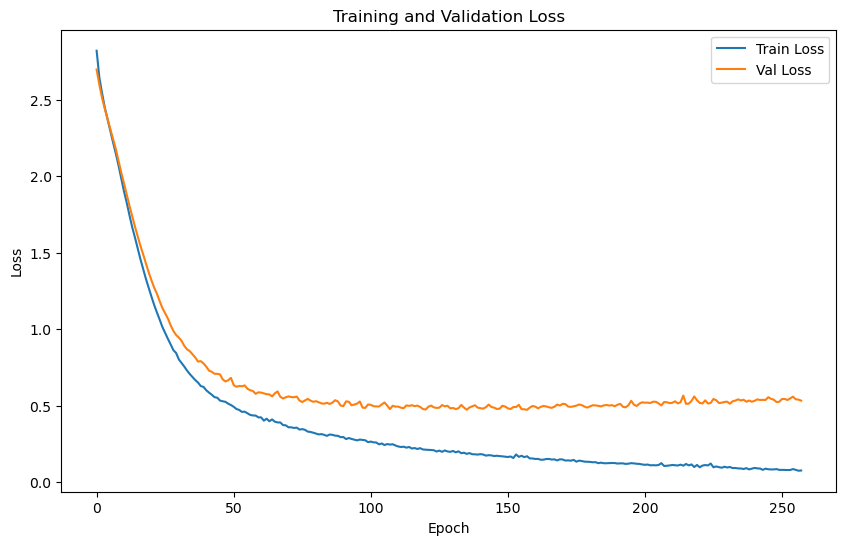

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.6911 | Test Accuracy: 80.23%


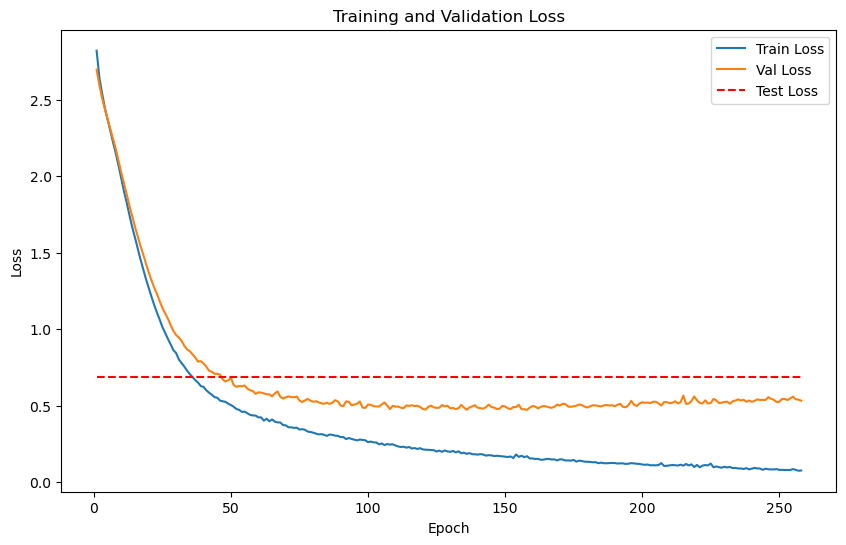

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53889, 64), 
Test labels shape: (53889,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 7.6502
Epoch [1/2000], Avg Train Loss: 7.6502
Epoch [1/2000], Avg Val Loss: 3.4145
Validation loss improved from inf to 3.4145. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.6626
Epoch [2/2000], Avg Train Loss: 7.6626
Epoch [2/2000], Avg Val Loss: 3.3990
Validation loss improved from 3.4145 to 3.3990. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.8380
Epoch [3/2000], Avg Train Loss: 7.8380
Epoch [3/2000], Avg Val Loss: 3.3841
Validation loss improved from 3.3990 to 3.3841. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.6700
Epoch [4/2000], Avg Train Loss: 7.6700
Epoch [4/2000], Avg Val Loss: 3.3698
Validation loss improved from 3.3841 to 3.3698. Saving model...

LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 7.3829
Epoch [5/2000], Avg Train Loss: 7.3829
Epoch [5/2000], Avg Val Loss: 3.3560
Validation loss improved from 3.3698 to 3.3560. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.4977
Epoch [6/2000], Avg Train Loss: 7.4977
Epoch [6/2000], Avg Val Loss: 3.3427
Validation loss improved from 3.3560 to 3.3427. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.4509
Epoch [7/2000], Avg Train Loss: 7.4509
Epoch [7/2000], Avg Val Loss: 3.3296
Validation loss improved from 3.3427 to 3.3296. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 7.3782
Epoch [8/2000], Avg Train Loss: 7.3782
Epoch [8/2000], Avg Val Loss: 3.3169
Validation loss improved from 3.3296 to 3.3169. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 7.3749
Epoch [9/2000], Avg Train Loss: 7.3749
Epoch [9/2000], Avg Val Loss: 3.3047
Validation loss improved from 3.3169 to 3.3047. Saving m

    Batch [1/1], Train Loss: 6.6019
Epoch [20/2000], Avg Train Loss: 6.6019
Epoch [20/2000], Avg Val Loss: 3.1933
Validation loss improved from 3.2017 to 3.1933. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.5276
Epoch [21/2000], Avg Train Loss: 6.5276
Epoch [21/2000], Avg Val Loss: 3.1852
Validation loss improved from 3.1933 to 3.1852. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.7137
Epoch [22/2000], Avg Train Loss: 6.7137
Epoch [22/2000], Avg Val Loss: 3.1774
Validation loss improved from 3.1852 to 3.1774. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.4572
Epoch [23/2000], Avg Train Loss: 6.4572
Epoch [23/2000], Avg Val Loss: 3.1698
Validation loss improved from 3.1774 to 3.1698. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.4199
Epoch [24/2000], Avg Train Loss: 6.4199
Epoch [24/2000], Avg Val Loss: 3.1626
Validation loss improved from 3.1698 to 3.

Epoch [28/2000], Avg Val Loss: 3.1357
Validation loss improved from 3.1422 to 3.1357. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 6.2138
Epoch [29/2000], Avg Train Loss: 6.2138
Epoch [29/2000], Avg Val Loss: 3.1295
Validation loss improved from 3.1357 to 3.1295. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 6.1953
Epoch [30/2000], Avg Train Loss: 6.1953
Epoch [30/2000], Avg Val Loss: 3.1235
Validation loss improved from 3.1295 to 3.1235. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 6.2466
Epoch [31/2000], Avg Train Loss: 6.2466
Epoch [31/2000], Avg Val Loss: 3.1177
Validation loss improved from 3.1235 to 3.1177. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.0638
Epoch [32/2000], Avg Train Loss: 6.0638
Epoch [32/2000], Avg Val Loss: 3.1120
Validation loss improved from 3.1177 to 3.1120. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.3518
Epoch [48/2000], Avg Train Loss: 5.3518
Epoch [48/2000], Avg Val Loss: 3.0478
Validation loss improved from 3.0508 to 3.0478. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.4312
Epoch [49/2000], Avg Train Loss: 5.4312
Epoch [49/2000], Avg Val Loss: 3.0450
Validation loss improved from 3.0478 to 3.0450. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.2277
Epoch [50/2000], Avg Train Loss: 5.2277
Epoch [50/2000], Avg Val Loss: 3.0423
Validation loss improved from 3.0450 to 3.0423. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.2920
Epoch [51/2000], Avg Train Loss: 5.2920
Epoch [51/2000], Avg Val Loss: 3.0397
Validation loss improved from 3.0423 to 3.0397. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.2671
Epoch [52/2000], Avg Train Loss: 5.2671
Epoch [52/2000], Avg Val Loss: 3.0371
Validation loss improved from 3.0397 to 3.

    Batch [1/1], Train Loss: 5.2349
Epoch [60/2000], Avg Train Loss: 5.2349
Epoch [60/2000], Avg Val Loss: 3.0201
Validation loss improved from 3.0220 to 3.0201. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.0895
Epoch [61/2000], Avg Train Loss: 5.0895
Epoch [61/2000], Avg Val Loss: 3.0182
Validation loss improved from 3.0201 to 3.0182. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.0538
Epoch [62/2000], Avg Train Loss: 5.0538
Epoch [62/2000], Avg Val Loss: 3.0164
Validation loss improved from 3.0182 to 3.0164. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.0102
Epoch [63/2000], Avg Train Loss: 5.0102
Epoch [63/2000], Avg Val Loss: 3.0146
Validation loss improved from 3.0164 to 3.0146. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 4.9232
Epoch [64/2000], Avg Train Loss: 4.9232
Epoch [64/2000], Avg Val Loss: 3.0128
Validation loss improved from 3.0146 to 3.

Epoch [68/2000], Avg Val Loss: 3.0063
Validation loss improved from 3.0078 to 3.0063. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 4.9333
Epoch [69/2000], Avg Train Loss: 4.9333
Epoch [69/2000], Avg Val Loss: 3.0048
Validation loss improved from 3.0063 to 3.0048. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 4.9452
Epoch [70/2000], Avg Train Loss: 4.9452
Epoch [70/2000], Avg Val Loss: 3.0034
Validation loss improved from 3.0048 to 3.0034. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 4.7527
Epoch [71/2000], Avg Train Loss: 4.7527
Epoch [71/2000], Avg Val Loss: 3.0019
Validation loss improved from 3.0034 to 3.0019. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 4.8527
Epoch [72/2000], Avg Train Loss: 4.8527
Epoch [72/2000], Avg Val Loss: 3.0005
Validation loss improved from 3.0019 to 3.0005. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Trai

Epoch [87/2000], Avg Val Loss: 2.9823
Validation loss improved from 2.9834 to 2.9823. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 4.6361
Epoch [88/2000], Avg Train Loss: 4.6361
Epoch [88/2000], Avg Val Loss: 2.9812
Validation loss improved from 2.9823 to 2.9812. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 4.5178
Epoch [89/2000], Avg Train Loss: 4.5178
Epoch [89/2000], Avg Val Loss: 2.9801
Validation loss improved from 2.9812 to 2.9801. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 4.5608
Epoch [90/2000], Avg Train Loss: 4.5608
Epoch [90/2000], Avg Val Loss: 2.9790
Validation loss improved from 2.9801 to 2.9790. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 4.5416
Epoch [91/2000], Avg Train Loss: 4.5416
Epoch [91/2000], Avg Val Loss: 2.9778
Validation loss improved from 2.9790 to 2.9778. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.4660
Epoch [103/2000], Avg Train Loss: 4.4660
Epoch [103/2000], Avg Val Loss: 2.9644
Validation loss improved from 2.9655 to 2.9644. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 4.3957
Epoch [104/2000], Avg Train Loss: 4.3957
Epoch [104/2000], Avg Val Loss: 2.9632
Validation loss improved from 2.9644 to 2.9632. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.4739
Epoch [105/2000], Avg Train Loss: 4.4739
Epoch [105/2000], Avg Val Loss: 2.9620
Validation loss improved from 2.9632 to 2.9620. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.4881
Epoch [106/2000], Avg Train Loss: 4.4881
Epoch [106/2000], Avg Val Loss: 2.9608
Validation loss improved from 2.9620 to 2.9608. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.3862
Epoch [107/2000], Avg Train Loss: 4.3862
Epoch [107/2000], Avg Val Loss: 2.9595
Validation loss improved fro

Epoch [111/2000], Avg Val Loss: 2.9546
Validation loss improved from 2.9558 to 2.9546. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.3688
Epoch [112/2000], Avg Train Loss: 4.3688
Epoch [112/2000], Avg Val Loss: 2.9534
Validation loss improved from 2.9546 to 2.9534. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 4.4740
Epoch [113/2000], Avg Train Loss: 4.4740
Epoch [113/2000], Avg Val Loss: 2.9522
Validation loss improved from 2.9534 to 2.9522. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.3175
Epoch [114/2000], Avg Train Loss: 4.3175
Epoch [114/2000], Avg Val Loss: 2.9510
Validation loss improved from 2.9522 to 2.9510. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.3465
Epoch [115/2000], Avg Train Loss: 4.3465
Epoch [115/2000], Avg Val Loss: 2.9498
Validation loss improved from 2.9510 to 2.9498. Saving model...

LOG: Epoch [116/2000] - Training
    Bat

Epoch [131/2000], Avg Val Loss: 2.9297
Validation loss improved from 2.9309 to 2.9297. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 4.2402
Epoch [132/2000], Avg Train Loss: 4.2402
Epoch [132/2000], Avg Val Loss: 2.9284
Validation loss improved from 2.9297 to 2.9284. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.1999
Epoch [133/2000], Avg Train Loss: 4.1999
Epoch [133/2000], Avg Val Loss: 2.9270
Validation loss improved from 2.9284 to 2.9270. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.2490
Epoch [134/2000], Avg Train Loss: 4.2490
Epoch [134/2000], Avg Val Loss: 2.9257
Validation loss improved from 2.9270 to 2.9257. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.1944
Epoch [135/2000], Avg Train Loss: 4.1944
Epoch [135/2000], Avg Val Loss: 2.9243
Validation loss improved from 2.9257 to 2.9243. Saving model...

LOG: Epoch [136/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2018
Epoch [148/2000], Avg Train Loss: 4.2018
Epoch [148/2000], Avg Val Loss: 2.9067
Validation loss improved from 2.9080 to 2.9067. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.1966
Epoch [149/2000], Avg Train Loss: 4.1966
Epoch [149/2000], Avg Val Loss: 2.9054
Validation loss improved from 2.9067 to 2.9054. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.1403
Epoch [150/2000], Avg Train Loss: 4.1403
Epoch [150/2000], Avg Val Loss: 2.9041
Validation loss improved from 2.9054 to 2.9041. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 4.1524
Epoch [151/2000], Avg Train Loss: 4.1524
Epoch [151/2000], Avg Val Loss: 2.9028
Validation loss improved from 2.9041 to 2.9028. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 4.1188
Epoch [152/2000], Avg Train Loss: 4.1188
Epoch [152/2000], Avg Val Loss: 2.9014
Validation loss improved fro

Epoch [153/2000], Avg Val Loss: 2.9001
Validation loss improved from 2.9014 to 2.9001. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 4.1891
Epoch [154/2000], Avg Train Loss: 4.1891
Epoch [154/2000], Avg Val Loss: 2.8988
Validation loss improved from 2.9001 to 2.8988. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 4.1305
Epoch [155/2000], Avg Train Loss: 4.1305
Epoch [155/2000], Avg Val Loss: 2.8975
Validation loss improved from 2.8988 to 2.8975. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.0698
Epoch [156/2000], Avg Train Loss: 4.0698
Epoch [156/2000], Avg Val Loss: 2.8962
Validation loss improved from 2.8975 to 2.8962. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.1252
Epoch [157/2000], Avg Train Loss: 4.1252
Epoch [157/2000], Avg Val Loss: 2.8948
Validation loss improved from 2.8962 to 2.8948. Saving model...

LOG: Epoch [158/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0465
Epoch [173/2000], Avg Train Loss: 4.0465
Epoch [173/2000], Avg Val Loss: 2.8729
Validation loss improved from 2.8743 to 2.8729. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 4.0248
Epoch [174/2000], Avg Train Loss: 4.0248
Epoch [174/2000], Avg Val Loss: 2.8714
Validation loss improved from 2.8729 to 2.8714. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.0476
Epoch [175/2000], Avg Train Loss: 4.0476
Epoch [175/2000], Avg Val Loss: 2.8700
Validation loss improved from 2.8714 to 2.8700. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.1360
Epoch [176/2000], Avg Train Loss: 4.1360
Epoch [176/2000], Avg Val Loss: 2.8686
Validation loss improved from 2.8700 to 2.8686. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.0614
Epoch [177/2000], Avg Train Loss: 4.0614
Epoch [177/2000], Avg Val Loss: 2.8672
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0516
Epoch [190/2000], Avg Train Loss: 4.0516
Epoch [190/2000], Avg Val Loss: 2.8492
Validation loss improved from 2.8505 to 2.8492. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 3.9999
Epoch [191/2000], Avg Train Loss: 3.9999
Epoch [191/2000], Avg Val Loss: 2.8479
Validation loss improved from 2.8492 to 2.8479. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 4.0347
Epoch [192/2000], Avg Train Loss: 4.0347
Epoch [192/2000], Avg Val Loss: 2.8466
Validation loss improved from 2.8479 to 2.8466. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 4.0012
Epoch [193/2000], Avg Train Loss: 4.0012
Epoch [193/2000], Avg Val Loss: 2.8453
Validation loss improved from 2.8466 to 2.8453. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 3.9517
Epoch [194/2000], Avg Train Loss: 3.9517
Epoch [194/2000], Avg Val Loss: 2.8440
Validation loss improved fro

Epoch [200/2000], Avg Train Loss: 3.9260
Epoch [200/2000], Avg Val Loss: 2.8364
Validation loss improved from 2.8376 to 2.8364. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 3.9736
Epoch [201/2000], Avg Train Loss: 3.9736
Epoch [201/2000], Avg Val Loss: 2.8351
Validation loss improved from 2.8364 to 2.8351. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 4.0001
Epoch [202/2000], Avg Train Loss: 4.0001
Epoch [202/2000], Avg Val Loss: 2.8339
Validation loss improved from 2.8351 to 2.8339. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 3.9551
Epoch [203/2000], Avg Train Loss: 3.9551
Epoch [203/2000], Avg Val Loss: 2.8326
Validation loss improved from 2.8339 to 2.8326. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 3.9302
Epoch [204/2000], Avg Train Loss: 3.9302
Epoch [204/2000], Avg Val Loss: 2.8314
Validation loss improved from 2.8326 to 2.8314. Saving model...


    Batch [1/1], Train Loss: 3.9431
Epoch [219/2000], Avg Train Loss: 3.9431
Epoch [219/2000], Avg Val Loss: 2.8121
Validation loss improved from 2.8134 to 2.8121. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 3.9207
Epoch [220/2000], Avg Train Loss: 3.9207
Epoch [220/2000], Avg Val Loss: 2.8108
Validation loss improved from 2.8121 to 2.8108. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 3.8911
Epoch [221/2000], Avg Train Loss: 3.8911
Epoch [221/2000], Avg Val Loss: 2.8094
Validation loss improved from 2.8108 to 2.8094. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 3.8993
Epoch [222/2000], Avg Train Loss: 3.8993
Epoch [222/2000], Avg Val Loss: 2.8081
Validation loss improved from 2.8094 to 2.8081. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 3.8741
Epoch [223/2000], Avg Train Loss: 3.8741
Epoch [223/2000], Avg Val Loss: 2.8068
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8921
Epoch [236/2000], Avg Train Loss: 3.8921


Epoch [236/2000], Avg Val Loss: 2.7904
Validation loss improved from 2.7915 to 2.7904. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 3.8579
Epoch [237/2000], Avg Train Loss: 3.8579
Epoch [237/2000], Avg Val Loss: 2.7892
Validation loss improved from 2.7904 to 2.7892. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 3.8571
Epoch [238/2000], Avg Train Loss: 3.8571
Epoch [238/2000], Avg Val Loss: 2.7880
Validation loss improved from 2.7892 to 2.7880. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 3.8828
Epoch [239/2000], Avg Train Loss: 3.8828
Epoch [239/2000], Avg Val Loss: 2.7868
Validation loss improved from 2.7880 to 2.7868. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 3.7886
Epoch [240/2000], Avg Train Loss: 3.7886
Epoch [240/2000], Avg Val Loss: 2.7857
Validation loss improved from 2.7868 to 2.7857. Saving model...

LOG: Epoch [241/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8467
Epoch [259/2000], Avg Train Loss: 3.8467
Epoch [259/2000], Avg Val Loss: 2.7642
Validation loss improved from 2.7654 to 2.7642. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 3.8030
Epoch [260/2000], Avg Train Loss: 3.8030
Epoch [260/2000], Avg Val Loss: 2.7631
Validation loss improved from 2.7642 to 2.7631. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 3.8688
Epoch [261/2000], Avg Train Loss: 3.8688
Epoch [261/2000], Avg Val Loss: 2.7620
Validation loss improved from 2.7631 to 2.7620. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 3.7991
Epoch [262/2000], Avg Train Loss: 3.7991
Epoch [262/2000], Avg Val Loss: 2.7609
Validation loss improved from 2.7620 to 2.7609. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 3.7888
Epoch [263/2000], Avg Train Loss: 3.7888
Epoch [263/2000], Avg Val Loss: 2.7598
Validation loss improved fro

Epoch [278/2000], Avg Val Loss: 2.7437
Validation loss improved from 2.7448 to 2.7437. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 3.7613
Epoch [279/2000], Avg Train Loss: 3.7613
Epoch [279/2000], Avg Val Loss: 2.7426
Validation loss improved from 2.7437 to 2.7426. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 3.7704
Epoch [280/2000], Avg Train Loss: 3.7704
Epoch [280/2000], Avg Val Loss: 2.7415
Validation loss improved from 2.7426 to 2.7415. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 3.7798
Epoch [281/2000], Avg Train Loss: 3.7798
Epoch [281/2000], Avg Val Loss: 2.7404
Validation loss improved from 2.7415 to 2.7404. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 3.7682
Epoch [282/2000], Avg Train Loss: 3.7682
Epoch [282/2000], Avg Val Loss: 2.7393
Validation loss improved from 2.7404 to 2.7393. Saving model...

LOG: Epoch [283/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7362
Epoch [295/2000], Avg Train Loss: 3.7362
Epoch [295/2000], Avg Val Loss: 2.7255
Validation loss improved from 2.7265 to 2.7255. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 3.7183
Epoch [296/2000], Avg Train Loss: 3.7183
Epoch [296/2000], Avg Val Loss: 2.7246
Validation loss improved from 2.7255 to 2.7246. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 3.7214
Epoch [297/2000], Avg Train Loss: 3.7214
Epoch [297/2000], Avg Val Loss: 2.7236
Validation loss improved from 2.7246 to 2.7236. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 3.7342
Epoch [298/2000], Avg Train Loss: 3.7342
Epoch [298/2000], Avg Val Loss: 2.7227
Validation loss improved from 2.7236 to 2.7227. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.6719
Epoch [299/2000], Avg Train Loss: 3.6719
Epoch [299/2000], Avg Val Loss: 2.7217
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7213
Epoch [316/2000], Avg Train Loss: 3.7213
Epoch [316/2000], Avg Val Loss: 2.7051
Validation loss improved from 2.7061 to 2.7051. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 3.7155
Epoch [317/2000], Avg Train Loss: 3.7155
Epoch [317/2000], Avg Val Loss: 2.7042
Validation loss improved from 2.7051 to 2.7042. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 3.7385
Epoch [318/2000], Avg Train Loss: 3.7385
Epoch [318/2000], Avg Val Loss: 2.7032
Validation loss improved from 2.7042 to 2.7032. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 3.6704
Epoch [319/2000], Avg Train Loss: 3.6704
Epoch [319/2000], Avg Val Loss: 2.7022
Validation loss improved from 2.7032 to 2.7022. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 3.7259
Epoch [320/2000], Avg Train Loss: 3.7259
Epoch [320/2000], Avg Val Loss: 2.7012
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6056
Epoch [338/2000], Avg Train Loss: 3.6056
Epoch [338/2000], Avg Val Loss: 2.6855
Validation loss improved from 2.6864 to 2.6855. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 3.6787
Epoch [339/2000], Avg Train Loss: 3.6787
Epoch [339/2000], Avg Val Loss: 2.6846
Validation loss improved from 2.6855 to 2.6846. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 3.6856
Epoch [340/2000], Avg Train Loss: 3.6856
Epoch [340/2000], Avg Val Loss: 2.6838
Validation loss improved from 2.6846 to 2.6838. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 3.6042
Epoch [341/2000], Avg Train Loss: 3.6042
Epoch [341/2000], Avg Val Loss: 2.6829
Validation loss improved from 2.6838 to 2.6829. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 3.6730
Epoch [342/2000], Avg Train Loss: 3.6730
Epoch [342/2000], Avg Val Loss: 2.6822
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6273
Epoch [361/2000], Avg Train Loss: 3.6273
Epoch [361/2000], Avg Val Loss: 2.6665
Validation loss improved from 2.6674 to 2.6665. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 3.6196
Epoch [362/2000], Avg Train Loss: 3.6196
Epoch [362/2000], Avg Val Loss: 2.6657
Validation loss improved from 2.6665 to 2.6657. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 3.5990
Epoch [363/2000], Avg Train Loss: 3.5990
Epoch [363/2000], Avg Val Loss: 2.6648
Validation loss improved from 2.6657 to 2.6648. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 3.6574
Epoch [364/2000], Avg Train Loss: 3.6574
Epoch [364/2000], Avg Val Loss: 2.6640
Validation loss improved from 2.6648 to 2.6640. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 3.6116
Epoch [365/2000], Avg Train Loss: 3.6116
Epoch [365/2000], Avg Val Loss: 2.6631
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5711
Epoch [378/2000], Avg Train Loss: 3.5711
Epoch [378/2000], Avg Val Loss: 2.6521
Validation loss improved from 2.6530 to 2.6521. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 3.6347
Epoch [379/2000], Avg Train Loss: 3.6347
Epoch [379/2000], Avg Val Loss: 2.6513
Validation loss improved from 2.6521 to 2.6513. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 3.6194
Epoch [380/2000], Avg Train Loss: 3.6194
Epoch [380/2000], Avg Val Loss: 2.6505
Validation loss improved from 2.6513 to 2.6505. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 3.5465
Epoch [381/2000], Avg Train Loss: 3.5465
Epoch [381/2000], Avg Val Loss: 2.6497
Validation loss improved from 2.6505 to 2.6497. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 3.5690
Epoch [382/2000], Avg Train Loss: 3.5690
Epoch [382/2000], Avg Val Loss: 2.6489
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5446
Epoch [405/2000], Avg Train Loss: 3.5446
Epoch [405/2000], Avg Val Loss: 2.6313
Validation loss improved from 2.6320 to 2.6313. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 3.5490
Epoch [406/2000], Avg Train Loss: 3.5490
Epoch [406/2000], Avg Val Loss: 2.6306
Validation loss improved from 2.6313 to 2.6306. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 3.5463
Epoch [407/2000], Avg Train Loss: 3.5463
Epoch [407/2000], Avg Val Loss: 2.6299
Validation loss improved from 2.6306 to 2.6299. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 3.5266
Epoch [408/2000], Avg Train Loss: 3.5266
Epoch [408/2000], Avg Val Loss: 2.6291
Validation loss improved from 2.6299 to 2.6291. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 3.5277
Epoch [409/2000], Avg Train Loss: 3.5277
Epoch [409/2000], Avg Val Loss: 2.6283
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5291
Epoch [421/2000], Avg Train Loss: 3.5291
Epoch [421/2000], Avg Val Loss: 2.6193
Validation loss improved from 2.6200 to 2.6193. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 3.5747
Epoch [422/2000], Avg Train Loss: 3.5747
Epoch [422/2000], Avg Val Loss: 2.6186
Validation loss improved from 2.6193 to 2.6186. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 3.5409
Epoch [423/2000], Avg Train Loss: 3.5409
Epoch [423/2000], Avg Val Loss: 2.6179
Validation loss improved from 2.6186 to 2.6179. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 3.5036
Epoch [424/2000], Avg Train Loss: 3.5036
Epoch [424/2000], Avg Val Loss: 2.6172
Validation loss improved from 2.6179 to 2.6172. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 3.5077
Epoch [425/2000], Avg Train Loss: 3.5077
Epoch [425/2000], Avg Val Loss: 2.6165
Validation loss improved fro

Epoch [449/2000], Avg Val Loss: 2.6014
Validation loss improved from 2.6019 to 2.6014. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 3.5601
Epoch [450/2000], Avg Train Loss: 3.5601
Epoch [450/2000], Avg Val Loss: 2.6008
Validation loss improved from 2.6014 to 2.6008. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 3.5152
Epoch [451/2000], Avg Train Loss: 3.5152
Epoch [451/2000], Avg Val Loss: 2.6002
Validation loss improved from 2.6008 to 2.6002. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 3.5133
Epoch [452/2000], Avg Train Loss: 3.5133
Epoch [452/2000], Avg Val Loss: 2.5997
Validation loss improved from 2.6002 to 2.5997. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 3.5013
Epoch [453/2000], Avg Train Loss: 3.5013
Epoch [453/2000], Avg Val Loss: 2.5991
Validation loss improved from 2.5997 to 2.5991. Saving model...

LOG: Epoch [454/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4845
Epoch [465/2000], Avg Train Loss: 3.4845
Epoch [465/2000], Avg Val Loss: 2.5917
Validation loss improved from 2.5923 to 2.5917. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 3.4704
Epoch [466/2000], Avg Train Loss: 3.4704
Epoch [466/2000], Avg Val Loss: 2.5912
Validation loss improved from 2.5917 to 2.5912. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 3.4654
Epoch [467/2000], Avg Train Loss: 3.4654
Epoch [467/2000], Avg Val Loss: 2.5906
Validation loss improved from 2.5912 to 2.5906. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 3.4676
Epoch [468/2000], Avg Train Loss: 3.4676
Epoch [468/2000], Avg Val Loss: 2.5900
Validation loss improved from 2.5906 to 2.5900. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 3.4292
Epoch [469/2000], Avg Train Loss: 3.4292
Epoch [469/2000], Avg Val Loss: 2.5893
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4555
Epoch [494/2000], Avg Train Loss: 3.4555
Epoch [494/2000], Avg Val Loss: 2.5738
Validation loss improved from 2.5744 to 2.5738. Saving model...

LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 3.4419
Epoch [495/2000], Avg Train Loss: 3.4419
Epoch [495/2000], Avg Val Loss: 2.5732
Validation loss improved from 2.5738 to 2.5732. Saving model...

LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 3.4591
Epoch [496/2000], Avg Train Loss: 3.4591
Epoch [496/2000], Avg Val Loss: 2.5726
Validation loss improved from 2.5732 to 2.5726. Saving model...

LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 3.4613
Epoch [497/2000], Avg Train Loss: 3.4613
Epoch [497/2000], Avg Val Loss: 2.5720
Validation loss improved from 2.5726 to 2.5720. Saving model...

LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 3.4375
Epoch [498/2000], Avg Train Loss: 3.4375
Epoch [498/2000], Avg Val Loss: 2.5714
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4650
Epoch [510/2000], Avg Train Loss: 3.4650
Epoch [510/2000], Avg Val Loss: 2.5648
Validation loss improved from 2.5653 to 2.5648. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 3.4294
Epoch [511/2000], Avg Train Loss: 3.4294
Epoch [511/2000], Avg Val Loss: 2.5643
Validation loss improved from 2.5648 to 2.5643. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 3.4745
Epoch [512/2000], Avg Train Loss: 3.4745
Epoch [512/2000], Avg Val Loss: 2.5639
Validation loss improved from 2.5643 to 2.5639. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 3.4435
Epoch [513/2000], Avg Train Loss: 3.4435
Epoch [513/2000], Avg Val Loss: 2.5634
Validation loss improved from 2.5639 to 2.5634. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 3.4342
Epoch [514/2000], Avg Train Loss: 3.4342
Epoch [514/2000], Avg Val Loss: 2.5629
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4296
Epoch [536/2000], Avg Train Loss: 3.4296
Epoch [536/2000], Avg Val Loss: 2.5512
Validation loss improved from 2.5518 to 2.5512. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 3.4222
Epoch [537/2000], Avg Train Loss: 3.4222
Epoch [537/2000], Avg Val Loss: 2.5506
Validation loss improved from 2.5512 to 2.5506. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 3.4213
Epoch [538/2000], Avg Train Loss: 3.4213
Epoch [538/2000], Avg Val Loss: 2.5501
Validation loss improved from 2.5506 to 2.5501. Saving model...

LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 3.4218
Epoch [539/2000], Avg Train Loss: 3.4218
Epoch [539/2000], Avg Val Loss: 2.5496
Validation loss improved from 2.5501 to 2.5496. Saving model...

LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 3.4276
Epoch [540/2000], Avg Train Loss: 3.4276
Epoch [540/2000], Avg Val Loss: 2.5491
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4016
Epoch [552/2000], Avg Train Loss: 3.4016
Epoch [552/2000], Avg Val Loss: 2.5446
Validation loss improved from 2.5450 to 2.5446. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 3.3745
Epoch [553/2000], Avg Train Loss: 3.3745
Epoch [553/2000], Avg Val Loss: 2.5443
Validation loss improved from 2.5446 to 2.5443. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 3.4056
Epoch [554/2000], Avg Train Loss: 3.4056
Epoch [554/2000], Avg Val Loss: 2.5439
Validation loss improved from 2.5443 to 2.5439. Saving model...

LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 3.3634
Epoch [555/2000], Avg Train Loss: 3.3634
Epoch [555/2000], Avg Val Loss: 2.5435
Validation loss improved from 2.5439 to 2.5435. Saving model...

LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 3.4031
Epoch [556/2000], Avg Train Loss: 3.4031
Epoch [556/2000], Avg Val Loss: 2.5430
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3192
Epoch [576/2000], Avg Train Loss: 3.3192
Epoch [576/2000], Avg Val Loss: 2.5330
Validation loss improved from 2.5335 to 2.5330. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 3.3571
Epoch [577/2000], Avg Train Loss: 3.3571
Epoch [577/2000], Avg Val Loss: 2.5326
Validation loss improved from 2.5330 to 2.5326. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 3.3141
Epoch [578/2000], Avg Train Loss: 3.3141
Epoch [578/2000], Avg Val Loss: 2.5321
Validation loss improved from 2.5326 to 2.5321. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 3.3514
Epoch [579/2000], Avg Train Loss: 3.3514
Epoch [579/2000], Avg Val Loss: 2.5317
Validation loss improved from 2.5321 to 2.5317. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 3.3243
Epoch [580/2000], Avg Train Loss: 3.3243
Epoch [580/2000], Avg Val Loss: 2.5313
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3763
Epoch [594/2000], Avg Train Loss: 3.3763
Epoch [594/2000], Avg Val Loss: 2.5254
Validation loss improved from 2.5258 to 2.5254. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 3.3254
Epoch [595/2000], Avg Train Loss: 3.3254
Epoch [595/2000], Avg Val Loss: 2.5251
Validation loss improved from 2.5254 to 2.5251. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 3.3360
Epoch [596/2000], Avg Train Loss: 3.3360
Epoch [596/2000], Avg Val Loss: 2.5247
Validation loss improved from 2.5251 to 2.5247. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 3.3554
Epoch [597/2000], Avg Train Loss: 3.3554
Epoch [597/2000], Avg Val Loss: 2.5244
Validation loss improved from 2.5247 to 2.5244. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 3.3399
Epoch [598/2000], Avg Train Loss: 3.3399
Epoch [598/2000], Avg Val Loss: 2.5241
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3443
Epoch [618/2000], Avg Train Loss: 3.3443
Epoch [618/2000], Avg Val Loss: 2.5177
Validation loss improved from 2.5180 to 2.5177. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 3.2906
Epoch [619/2000], Avg Train Loss: 3.2906
Epoch [619/2000], Avg Val Loss: 2.5175
Validation loss improved from 2.5177 to 2.5175. Saving model...

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 3.2913
Epoch [620/2000], Avg Train Loss: 3.2913
Epoch [620/2000], Avg Val Loss: 2.5172
Validation loss improved from 2.5175 to 2.5172. Saving model...

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 3.3697
Epoch [621/2000], Avg Train Loss: 3.3697
Epoch [621/2000], Avg Val Loss: 2.5169
Validation loss improved from 2.5172 to 2.5169. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 3.3284
Epoch [622/2000], Avg Train Loss: 3.3284
Epoch [622/2000], Avg Val Loss: 2.5166
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3307
Epoch [636/2000], Avg Train Loss: 3.3307
Epoch [636/2000], Avg Val Loss: 2.5127
Validation loss improved from 2.5130 to 2.5127. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 3.3188
Epoch [637/2000], Avg Train Loss: 3.3188
Epoch [637/2000], Avg Val Loss: 2.5124
Validation loss improved from 2.5127 to 2.5124. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 3.2903
Epoch [638/2000], Avg Train Loss: 3.2903
Epoch [638/2000], Avg Val Loss: 2.5120
Validation loss improved from 2.5124 to 2.5120. Saving model...

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 3.3116
Epoch [639/2000], Avg Train Loss: 3.3116
Epoch [639/2000], Avg Val Loss: 2.5117
Validation loss improved from 2.5120 to 2.5117. Saving model...

LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 3.3032
Epoch [640/2000], Avg Train Loss: 3.3032
Epoch [640/2000], Avg Val Loss: 2.5114
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3327
Epoch [658/2000], Avg Train Loss: 3.3327
Epoch [658/2000], Avg Val Loss: 2.5065
Validation loss improved from 2.5068 to 2.5065. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 3.2651
Epoch [659/2000], Avg Train Loss: 3.2651
Epoch [659/2000], Avg Val Loss: 2.5063
Validation loss improved from 2.5065 to 2.5063. Saving model...

LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 3.2893
Epoch [660/2000], Avg Train Loss: 3.2893
Epoch [660/2000], Avg Val Loss: 2.5060
Validation loss improved from 2.5063 to 2.5060. Saving model...

LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 3.3219
Epoch [661/2000], Avg Train Loss: 3.3219
Epoch [661/2000], Avg Val Loss: 2.5058
Validation loss improved from 2.5060 to 2.5058. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 3.3090
Epoch [662/2000], Avg Train Loss: 3.3090
Epoch [662/2000], Avg Val Loss: 2.5055
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3181
Epoch [677/2000], Avg Train Loss: 3.3181
Epoch [677/2000], Avg Val Loss: 2.5001
Validation loss improved from 2.5005 to 2.5001. Saving model...

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 3.2726
Epoch [678/2000], Avg Train Loss: 3.2726
Epoch [678/2000], Avg Val Loss: 2.4996
Validation loss improved from 2.5001 to 2.4996. Saving model...

LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 3.3170
Epoch [679/2000], Avg Train Loss: 3.3170
Epoch [679/2000], Avg Val Loss: 2.4992
Validation loss improved from 2.4996 to 2.4992. Saving model...

LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 3.3014
Epoch [680/2000], Avg Train Loss: 3.3014
Epoch [680/2000], Avg Val Loss: 2.4989
Validation loss improved from 2.4992 to 2.4989. Saving model...

LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 3.2557
Epoch [681/2000], Avg Train Loss: 3.2557
Epoch [681/2000], Avg Val Loss: 2.4985
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3036
Epoch [700/2000], Avg Train Loss: 3.3036
Epoch [700/2000], Avg Val Loss: 2.4954
Validation loss improved from 2.4956 to 2.4954. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 3.2835
Epoch [701/2000], Avg Train Loss: 3.2835
Epoch [701/2000], Avg Val Loss: 2.4951
Validation loss improved from 2.4954 to 2.4951. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 3.2738
Epoch [702/2000], Avg Train Loss: 3.2738
Epoch [702/2000], Avg Val Loss: 2.4948
Validation loss improved from 2.4951 to 2.4948. Saving model...

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 3.2487
Epoch [703/2000], Avg Train Loss: 3.2487
Epoch [703/2000], Avg Val Loss: 2.4945
Validation loss improved from 2.4948 to 2.4945. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 3.2748
Epoch [704/2000], Avg Train Loss: 3.2748
Epoch [704/2000], Avg Val Loss: 2.4943
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2585
Epoch [718/2000], Avg Train Loss: 3.2585
Epoch [718/2000], Avg Val Loss: 2.4910
Validation loss improved from 2.4912 to 2.4910. Saving model...

LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 3.2315
Epoch [719/2000], Avg Train Loss: 3.2315
Epoch [719/2000], Avg Val Loss: 2.4907
Validation loss improved from 2.4910 to 2.4907. Saving model...

LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 3.2245
Epoch [720/2000], Avg Train Loss: 3.2245
Epoch [720/2000], Avg Val Loss: 2.4905
Validation loss improved from 2.4907 to 2.4905. Saving model...

LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 3.2705
Epoch [721/2000], Avg Train Loss: 3.2705
Epoch [721/2000], Avg Val Loss: 2.4903
Validation loss improved from 2.4905 to 2.4903. Saving model...

LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 3.2518
Epoch [722/2000], Avg Train Loss: 3.2518
Epoch [722/2000], Avg Val Loss: 2.4901
Validation loss improved fro

Epoch [742/2000], Avg Val Loss: 2.4868
Validation loss improved from 2.4870 to 2.4868. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 3.2883
Epoch [743/2000], Avg Train Loss: 3.2883
Epoch [743/2000], Avg Val Loss: 2.4866
Validation loss improved from 2.4868 to 2.4866. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 3.2023
Epoch [744/2000], Avg Train Loss: 3.2023
Epoch [744/2000], Avg Val Loss: 2.4864
Validation loss improved from 2.4866 to 2.4864. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 3.2334
Epoch [745/2000], Avg Train Loss: 3.2334
Epoch [745/2000], Avg Val Loss: 2.4862
Validation loss improved from 2.4864 to 2.4862. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 3.2450
Epoch [746/2000], Avg Train Loss: 3.2450
Epoch [746/2000], Avg Val Loss: 2.4860
Validation loss improved from 2.4862 to 2.4860. Saving model...

LOG: Epoch [747/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2218
Epoch [761/2000], Avg Train Loss: 3.2218
Epoch [761/2000], Avg Val Loss: 2.4837
Validation loss improved from 2.4839 to 2.4837. Saving model...

LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 3.1970
Epoch [762/2000], Avg Train Loss: 3.1970
Epoch [762/2000], Avg Val Loss: 2.4834
Validation loss improved from 2.4837 to 2.4834. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 3.2142
Epoch [763/2000], Avg Train Loss: 3.2142
Epoch [763/2000], Avg Val Loss: 2.4833
Validation loss improved from 2.4834 to 2.4833. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 3.2919
Epoch [764/2000], Avg Train Loss: 3.2919
Epoch [764/2000], Avg Val Loss: 2.4832
Validation loss improved from 2.4833 to 2.4832. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 3.1916
Epoch [765/2000], Avg Train Loss: 3.1916
Epoch [765/2000], Avg Val Loss: 2.4830
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2302
Epoch [784/2000], Avg Train Loss: 3.2302
Epoch [784/2000], Avg Val Loss: 2.4803
Validation loss improved from 2.4803 to 2.4803. Saving model...

LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 3.1906
Epoch [785/2000], Avg Train Loss: 3.1906
Epoch [785/2000], Avg Val Loss: 2.4803
Validation loss did not improve. Patience: 1/100

LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 3.2098
Epoch [786/2000], Avg Train Loss: 3.2098
Epoch [786/2000], Avg Val Loss: 2.4802
Validation loss improved from 2.4803 to 2.4802. Saving model...

LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 3.1736
Epoch [787/2000], Avg Train Loss: 3.1736
Epoch [787/2000], Avg Val Loss: 2.4802
Validation loss improved from 2.4802 to 2.4802. Saving model...

LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 3.1691
Epoch [788/2000], Avg Train Loss: 3.1691
Epoch [788/2000], Avg Val Loss: 2.4801
Validation loss improved from 2.4802 to 2.4

    Batch [1/1], Train Loss: 3.1955
Epoch [800/2000], Avg Train Loss: 3.1955
Epoch [800/2000], Avg Val Loss: 2.4774
Validation loss improved from 2.4777 to 2.4774. Saving model...

LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 3.2034
Epoch [801/2000], Avg Train Loss: 3.2034
Epoch [801/2000], Avg Val Loss: 2.4772
Validation loss improved from 2.4774 to 2.4772. Saving model...

LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 3.2163
Epoch [802/2000], Avg Train Loss: 3.2163
Epoch [802/2000], Avg Val Loss: 2.4771
Validation loss improved from 2.4772 to 2.4771. Saving model...

LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 3.2006
Epoch [803/2000], Avg Train Loss: 3.2006
Epoch [803/2000], Avg Val Loss: 2.4769
Validation loss improved from 2.4771 to 2.4769. Saving model...

LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 3.1894
Epoch [804/2000], Avg Train Loss: 3.1894
Epoch [804/2000], Avg Val Loss: 2.4768
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1685
Epoch [827/2000], Avg Train Loss: 3.1685
Epoch [827/2000], Avg Val Loss: 2.4709
Validation loss improved from 2.4710 to 2.4709. Saving model...

LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 3.1855
Epoch [828/2000], Avg Train Loss: 3.1855
Epoch [828/2000], Avg Val Loss: 2.4708
Validation loss improved from 2.4709 to 2.4708. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 3.1586
Epoch [829/2000], Avg Train Loss: 3.1586
Epoch [829/2000], Avg Val Loss: 2.4707
Validation loss improved from 2.4708 to 2.4707. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 3.1872
Epoch [830/2000], Avg Train Loss: 3.1872
Epoch [830/2000], Avg Val Loss: 2.4706
Validation loss improved from 2.4707 to 2.4706. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 3.1604
Epoch [831/2000], Avg Train Loss: 3.1604
Epoch [831/2000], Avg Val Loss: 2.4705
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1868
Epoch [848/2000], Avg Train Loss: 3.1868
Epoch [848/2000], Avg Val Loss: 2.4684
Validation loss improved from 2.4684 to 2.4684. Saving model...

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 3.1266
Epoch [849/2000], Avg Train Loss: 3.1266
Epoch [849/2000], Avg Val Loss: 2.4683
Validation loss improved from 2.4684 to 2.4683. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 3.1495
Epoch [850/2000], Avg Train Loss: 3.1495
Epoch [850/2000], Avg Val Loss: 2.4682
Validation loss improved from 2.4683 to 2.4682. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 3.1816
Epoch [851/2000], Avg Train Loss: 3.1816
Epoch [851/2000], Avg Val Loss: 2.4681
Validation loss improved from 2.4682 to 2.4681. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 3.1707
Epoch [852/2000], Avg Train Loss: 3.1707
Epoch [852/2000], Avg Val Loss: 2.4679
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1240
Epoch [870/2000], Avg Train Loss: 3.1240
Epoch [870/2000], Avg Val Loss: 2.4678
Validation loss did not improve. Patience: 9/100

LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 3.1775
Epoch [871/2000], Avg Train Loss: 3.1775
Epoch [871/2000], Avg Val Loss: 2.4678
Validation loss did not improve. Patience: 10/100

LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 3.1076
Epoch [872/2000], Avg Train Loss: 3.1076
Epoch [872/2000], Avg Val Loss: 2.4678
Validation loss did not improve. Patience: 11/100

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 3.1671
Epoch [873/2000], Avg Train Loss: 3.1671
Epoch [873/2000], Avg Val Loss: 2.4678
Validation loss did not improve. Patience: 12/100

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 3.1800
Epoch [874/2000], Avg Train Loss: 3.1800
Epoch [874/2000], Avg Val Loss: 2.4677
Validation loss did not improve. Patience: 13/100

LOG: Epoch [875/2000] - Training
 

    Batch [1/1], Train Loss: 3.1284
Epoch [891/2000], Avg Train Loss: 3.1284
Epoch [891/2000], Avg Val Loss: 2.4654
Validation loss improved from 2.4656 to 2.4654. Saving model...

LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 3.1299
Epoch [892/2000], Avg Train Loss: 3.1299
Epoch [892/2000], Avg Val Loss: 2.4652
Validation loss improved from 2.4654 to 2.4652. Saving model...

LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 3.1528
Epoch [893/2000], Avg Train Loss: 3.1528
Epoch [893/2000], Avg Val Loss: 2.4650
Validation loss improved from 2.4652 to 2.4650. Saving model...

LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 3.1282
Epoch [894/2000], Avg Train Loss: 3.1282
Epoch [894/2000], Avg Val Loss: 2.4648
Validation loss improved from 2.4650 to 2.4648. Saving model...

LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 3.1365
Epoch [895/2000], Avg Train Loss: 3.1365
Epoch [895/2000], Avg Val Loss: 2.4646
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1272
Epoch [910/2000], Avg Train Loss: 3.1272
Epoch [910/2000], Avg Val Loss: 2.4635
Validation loss did not improve. Patience: 7/100

LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 3.1039
Epoch [911/2000], Avg Train Loss: 3.1039
Epoch [911/2000], Avg Val Loss: 2.4635
Validation loss did not improve. Patience: 8/100

LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 3.0994
Epoch [912/2000], Avg Train Loss: 3.0994
Epoch [912/2000], Avg Val Loss: 2.4636
Validation loss did not improve. Patience: 9/100

LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 3.1265
Epoch [913/2000], Avg Train Loss: 3.1265
Epoch [913/2000], Avg Val Loss: 2.4634
Validation loss did not improve. Patience: 10/100

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 3.1254
Epoch [914/2000], Avg Train Loss: 3.1254
Epoch [914/2000], Avg Val Loss: 2.4634
Validation loss did not improve. Patience: 11/100

LOG: Epoch [915/2000] - Training
   

    Batch [1/1], Train Loss: 3.1262
Epoch [932/2000], Avg Train Loss: 3.1262
Epoch [932/2000], Avg Val Loss: 2.4634
Validation loss did not improve. Patience: 14/100

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 3.1324
Epoch [933/2000], Avg Train Loss: 3.1324
Epoch [933/2000], Avg Val Loss: 2.4633
Validation loss did not improve. Patience: 15/100

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 3.1243
Epoch [934/2000], Avg Train Loss: 3.1243
Epoch [934/2000], Avg Val Loss: 2.4633
Validation loss did not improve. Patience: 16/100

LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 3.1061
Epoch [935/2000], Avg Train Loss: 3.1061
Epoch [935/2000], Avg Val Loss: 2.4632
Validation loss did not improve. Patience: 17/100

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 3.1067
Epoch [936/2000], Avg Train Loss: 3.1067
Epoch [936/2000], Avg Val Loss: 2.4631
Validation loss did not improve. Patience: 18/100

LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 3.0629
Epoch [954/2000], Avg Train Loss: 3.0629
Epoch [954/2000], Avg Val Loss: 2.4594
Validation loss improved from 2.4595 to 2.4594. Saving model...

LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 3.0851
Epoch [955/2000], Avg Train Loss: 3.0851
Epoch [955/2000], Avg Val Loss: 2.4594
Validation loss improved from 2.4594 to 2.4594. Saving model...

LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 3.0773
Epoch [956/2000], Avg Train Loss: 3.0773
Epoch [956/2000], Avg Val Loss: 2.4594
Validation loss did not improve. Patience: 1/100

LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 3.0969
Epoch [957/2000], Avg Train Loss: 3.0969
Epoch [957/2000], Avg Val Loss: 2.4594
Validation loss did not improve. Patience: 2/100

LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 3.0538
Epoch [958/2000], Avg Train Loss: 3.0538
Epoch [958/2000], Avg Val Loss: 2.4594
Validation loss did not improve. Patience: 3/100

LOG: Epo

    Batch [1/1], Train Loss: 3.0878
Epoch [975/2000], Avg Train Loss: 3.0878
Epoch [975/2000], Avg Val Loss: 2.4590
Validation loss did not improve. Patience: 10/100

LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 3.1567
Epoch [976/2000], Avg Train Loss: 3.1567
Epoch [976/2000], Avg Val Loss: 2.4589
Validation loss did not improve. Patience: 11/100

LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 3.0764
Epoch [977/2000], Avg Train Loss: 3.0764
Epoch [977/2000], Avg Val Loss: 2.4589
Validation loss did not improve. Patience: 12/100

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 3.0921
Epoch [978/2000], Avg Train Loss: 3.0921
Epoch [978/2000], Avg Val Loss: 2.4589
Validation loss did not improve. Patience: 13/100

LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 3.1019
Epoch [979/2000], Avg Train Loss: 3.1019
Epoch [979/2000], Avg Val Loss: 2.4588
Validation loss did not improve. Patience: 14/100

LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 3.0911
Epoch [993/2000], Avg Train Loss: 3.0911
Epoch [993/2000], Avg Val Loss: 2.4595
Validation loss did not improve. Patience: 28/100

LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 3.0762
Epoch [994/2000], Avg Train Loss: 3.0762
Epoch [994/2000], Avg Val Loss: 2.4596
Validation loss did not improve. Patience: 29/100

LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 3.0575
Epoch [995/2000], Avg Train Loss: 3.0575
Epoch [995/2000], Avg Val Loss: 2.4597
Validation loss did not improve. Patience: 30/100

LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 3.0725
Epoch [996/2000], Avg Train Loss: 3.0725
Epoch [996/2000], Avg Val Loss: 2.4597
Validation loss did not improve. Patience: 31/100

LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 3.0805
Epoch [997/2000], Avg Train Loss: 3.0805
Epoch [997/2000], Avg Val Loss: 2.4598
Validation loss did not improve. Patience: 32/100

LOG: Epoch [998/2000] - Training


Epoch [1014/2000], Avg Val Loss: 2.4605
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 3.0653
Epoch [1015/2000], Avg Train Loss: 3.0653
Epoch [1015/2000], Avg Val Loss: 2.4605
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 3.0487
Epoch [1016/2000], Avg Train Loss: 3.0487
Epoch [1016/2000], Avg Val Loss: 2.4606
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 3.0662
Epoch [1017/2000], Avg Train Loss: 3.0662
Epoch [1017/2000], Avg Val Loss: 2.4606
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 3.1159
Epoch [1018/2000], Avg Train Loss: 3.1159
Epoch [1018/2000], Avg Val Loss: 2.4606
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 3.0770
Epoch [1019/2000], Avg Trai

Epoch [1029/2000], Avg Val Loss: 2.4594
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1030/2000] - Training
    Batch [1/1], Train Loss: 3.1057
Epoch [1030/2000], Avg Train Loss: 3.1057
Epoch [1030/2000], Avg Val Loss: 2.4594
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1031/2000] - Training
    Batch [1/1], Train Loss: 3.0679
Epoch [1031/2000], Avg Train Loss: 3.0679
Epoch [1031/2000], Avg Val Loss: 2.4594
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 3.0571
Epoch [1032/2000], Avg Train Loss: 3.0571
Epoch [1032/2000], Avg Val Loss: 2.4594
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 3.0977
Epoch [1033/2000], Avg Train Loss: 3.0977
Epoch [1033/2000], Avg Val Loss: 2.4594
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 3.0998
Epoch [1034/2000], Avg Trai

    Batch [1/1], Train Loss: 3.0672
Epoch [1052/2000], Avg Train Loss: 3.0672
Epoch [1052/2000], Avg Val Loss: 2.4606
Validation loss did not improve. Patience: 87/100

LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 3.0413
Epoch [1053/2000], Avg Train Loss: 3.0413
Epoch [1053/2000], Avg Val Loss: 2.4609
Validation loss did not improve. Patience: 88/100

LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 3.0356
Epoch [1054/2000], Avg Train Loss: 3.0356
Epoch [1054/2000], Avg Val Loss: 2.4612
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 3.1015
Epoch [1055/2000], Avg Train Loss: 3.1015
Epoch [1055/2000], Avg Val Loss: 2.4615
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 3.0694
Epoch [1056/2000], Avg Train Loss: 3.0694
Epoch [1056/2000], Avg Val Loss: 2.4618
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1057/20

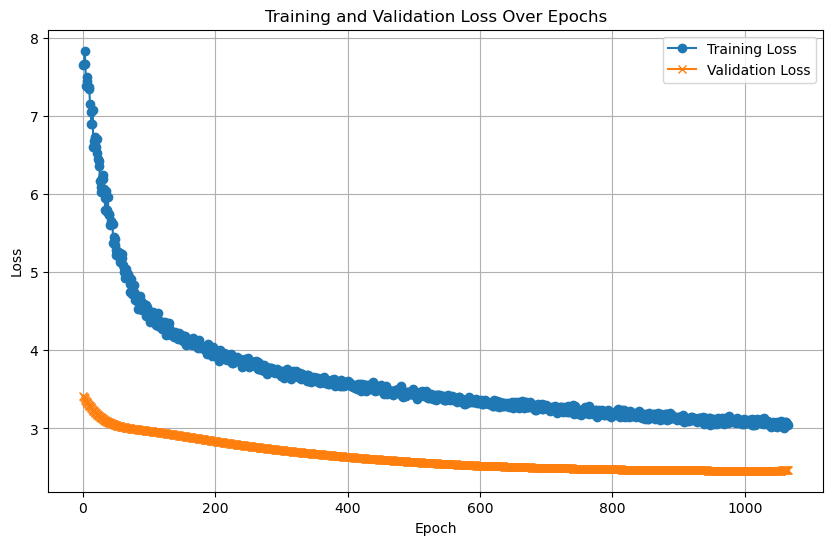

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/211], Loss: 5.1827
Test Batch [20/211], Loss: 5.6946
Test Batch [30/211], Loss: 5.9701


Test Batch [40/211], Loss: 6.2988
Test Batch [50/211], Loss: 5.1130
Test Batch [60/211], Loss: 4.7809
Test Batch [70/211], Loss: 4.8492
Test Batch [80/211], Loss: 4.6158
Test Batch [90/211], Loss: 4.7104
Test Batch [100/211], Loss: 4.6831
Test Batch [110/211], Loss: 4.6756
Test Batch [120/211], Loss: 4.5713
Test Batch [130/211], Loss: 4.5587
Test Batch [140/211], Loss: 4.6058
Test Batch [150/211], Loss: 4.4927
Test Batch [160/211], Loss: 4.7542


Test Batch [170/211], Loss: 4.9073
Test Batch [180/211], Loss: 5.0587
Test Batch [190/211], Loss: 4.8358


Test Batch [200/211], Loss: 4.8362
Test Batch [210/211], Loss: 5.0793

Test Loss: 4.9667


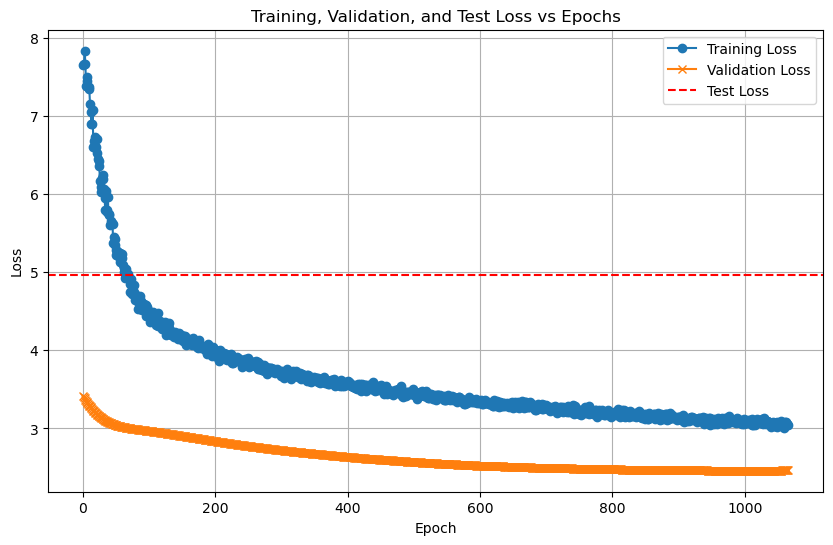

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.


  Processed batch 20/211 for test dataset.


  Processed batch 30/211 for test dataset.
  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.
  Processed batch 60/211 for test dataset.


  Processed batch 70/211 for test dataset.
  Processed batch 80/211 for test dataset.


  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.
  Processed batch 130/211 for test dataset.


  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.


  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.
  Processed batch 180/211 for test dataset.
  Processed batch 190/211 for test dataset.
  Processed batch 200/211 for test dataset.


  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.60      0.75         5
           3       1.00      0.80      0.89         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.67      0.40      0.50         5
           8       0.71      1.00      0.83         5
           9       0.80      0.80      0.80         5
          10       0.67      0.40      0.50         5
          11       0.71      1.00      0.83         5
          12       1.00      1.00      1.00         5
          13       0.8

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7829  |  Val Loss: 2.7712
Validation loss improved from inf to 2.7712.
[Epoch 2/1000] Train Loss: 2.7667  |  Val Loss: 2.7587
Validation loss improved from 2.7712 to 2.7587.
[Epoch 3/1000] Train Loss: 2.7514  |  Val Loss: 2.7469
Validation loss improved from 2.7587 to 2.7469.
[Epoch 4/1000] Train Loss: 2.7373  |  Val Loss: 2.7361
Validation loss improved from 2.7469 to 2.7361.
[Epoch 5/1000] Train Loss: 2.7240  |  Val Loss: 2.7256
Validation loss improved from 2.7361 to 2.7256.
[Epoch 6/1000] Train Loss: 2.7109  |  Val Loss: 2.7153
Validation loss improved from 2.7256 to 2.7153.
[Epoch 7/1000] Train Loss: 2.6976  |  Val Loss: 2.7049
Validation loss improved from 2.7153 to 2.7049.
[Epoch 8/1000] Train Loss: 2.6855  |  Val Loss: 2.6939
Validation loss improved from 2.7049 to 2.6939.
[Epoch 9/1000] Train Loss: 2.6722  |  Val Loss: 2.6832
Validation loss improved from 2.6939 to 2.6832.
[Epoch 10/1000] Train Loss: 2.6602  |  Val Loss: 2.6725
Validation loss impr

[Epoch 24/1000] Train Loss: 2.4759  |  Val Loss: 2.5089
Validation loss improved from 2.5222 to 2.5089.
[Epoch 25/1000] Train Loss: 2.4612  |  Val Loss: 2.4957
Validation loss improved from 2.5089 to 2.4957.
[Epoch 26/1000] Train Loss: 2.4459  |  Val Loss: 2.4824
Validation loss improved from 2.4957 to 2.4824.


[Epoch 27/1000] Train Loss: 2.4308  |  Val Loss: 2.4687
Validation loss improved from 2.4824 to 2.4687.
[Epoch 28/1000] Train Loss: 2.4152  |  Val Loss: 2.4549
Validation loss improved from 2.4687 to 2.4549.
[Epoch 29/1000] Train Loss: 2.3998  |  Val Loss: 2.4411
Validation loss improved from 2.4549 to 2.4411.
[Epoch 30/1000] Train Loss: 2.3858  |  Val Loss: 2.4273
Validation loss improved from 2.4411 to 2.4273.
[Epoch 31/1000] Train Loss: 2.3701  |  Val Loss: 2.4138
Validation loss improved from 2.4273 to 2.4138.
[Epoch 32/1000] Train Loss: 2.3553  |  Val Loss: 2.4005
Validation loss improved from 2.4138 to 2.4005.
[Epoch 33/1000] Train Loss: 2.3404  |  Val Loss: 2.3877
Validation loss improved from 2.4005 to 2.3877.
[Epoch 34/1000] Train Loss: 2.3258  |  Val Loss: 2.3754
Validation loss improved from 2.3877 to 2.3754.
[Epoch 35/1000] Train Loss: 2.3119  |  Val Loss: 2.3632
Validation loss improved from 2.3754 to 2.3632.
[Epoch 36/1000] Train Loss: 2.2981  |  Val Loss: 2.3513
Validati

[Epoch 50/1000] Train Loss: 2.1186  |  Val Loss: 2.1925
Validation loss improved from 2.2040 to 2.1925.
[Epoch 51/1000] Train Loss: 2.1052  |  Val Loss: 2.1809
Validation loss improved from 2.1925 to 2.1809.
[Epoch 52/1000] Train Loss: 2.0925  |  Val Loss: 2.1692
Validation loss improved from 2.1809 to 2.1692.
[Epoch 53/1000] Train Loss: 2.0797  |  Val Loss: 2.1575
Validation loss improved from 2.1692 to 2.1575.
[Epoch 54/1000] Train Loss: 2.0667  |  Val Loss: 2.1458
Validation loss improved from 2.1575 to 2.1458.
[Epoch 55/1000] Train Loss: 2.0540  |  Val Loss: 2.1342
Validation loss improved from 2.1458 to 2.1342.
[Epoch 56/1000] Train Loss: 2.0414  |  Val Loss: 2.1230
Validation loss improved from 2.1342 to 2.1230.


[Epoch 57/1000] Train Loss: 2.0281  |  Val Loss: 2.1117
Validation loss improved from 2.1230 to 2.1117.
[Epoch 58/1000] Train Loss: 2.0156  |  Val Loss: 2.1002
Validation loss improved from 2.1117 to 2.1002.
[Epoch 59/1000] Train Loss: 2.0026  |  Val Loss: 2.0888
Validation loss improved from 2.1002 to 2.0888.
[Epoch 60/1000] Train Loss: 1.9899  |  Val Loss: 2.0771
Validation loss improved from 2.0888 to 2.0771.
[Epoch 61/1000] Train Loss: 1.9771  |  Val Loss: 2.0656
Validation loss improved from 2.0771 to 2.0656.
[Epoch 62/1000] Train Loss: 1.9644  |  Val Loss: 2.0542
Validation loss improved from 2.0656 to 2.0542.
[Epoch 63/1000] Train Loss: 1.9517  |  Val Loss: 2.0426
Validation loss improved from 2.0542 to 2.0426.
[Epoch 64/1000] Train Loss: 1.9390  |  Val Loss: 2.0311
Validation loss improved from 2.0426 to 2.0311.
[Epoch 65/1000] Train Loss: 1.9256  |  Val Loss: 2.0196
Validation loss improved from 2.0311 to 2.0196.
[Epoch 66/1000] Train Loss: 1.9126  |  Val Loss: 2.0080
Validati

[Epoch 80/1000] Train Loss: 1.7284  |  Val Loss: 1.8418
Validation loss improved from 1.8537 to 1.8418.
[Epoch 81/1000] Train Loss: 1.7153  |  Val Loss: 1.8297
Validation loss improved from 1.8418 to 1.8297.
[Epoch 82/1000] Train Loss: 1.7026  |  Val Loss: 1.8177
Validation loss improved from 1.8297 to 1.8177.
[Epoch 83/1000] Train Loss: 1.6901  |  Val Loss: 1.8057
Validation loss improved from 1.8177 to 1.8057.
[Epoch 84/1000] Train Loss: 1.6773  |  Val Loss: 1.7942
Validation loss improved from 1.8057 to 1.7942.
[Epoch 85/1000] Train Loss: 1.6647  |  Val Loss: 1.7827
Validation loss improved from 1.7942 to 1.7827.


[Epoch 86/1000] Train Loss: 1.6525  |  Val Loss: 1.7713
Validation loss improved from 1.7827 to 1.7713.
[Epoch 87/1000] Train Loss: 1.6397  |  Val Loss: 1.7599
Validation loss improved from 1.7713 to 1.7599.
[Epoch 88/1000] Train Loss: 1.6274  |  Val Loss: 1.7489
Validation loss improved from 1.7599 to 1.7489.
[Epoch 89/1000] Train Loss: 1.6158  |  Val Loss: 1.7377
Validation loss improved from 1.7489 to 1.7377.
[Epoch 90/1000] Train Loss: 1.6033  |  Val Loss: 1.7265
Validation loss improved from 1.7377 to 1.7265.
[Epoch 91/1000] Train Loss: 1.5916  |  Val Loss: 1.7150
Validation loss improved from 1.7265 to 1.7150.
[Epoch 92/1000] Train Loss: 1.5795  |  Val Loss: 1.7039
Validation loss improved from 1.7150 to 1.7039.
[Epoch 93/1000] Train Loss: 1.5683  |  Val Loss: 1.6931
Validation loss improved from 1.7039 to 1.6931.
[Epoch 94/1000] Train Loss: 1.5565  |  Val Loss: 1.6824
Validation loss improved from 1.6931 to 1.6824.
[Epoch 95/1000] Train Loss: 1.5457  |  Val Loss: 1.6720
Validati

[Epoch 109/1000] Train Loss: 1.3979  |  Val Loss: 1.5344
Validation loss improved from 1.5434 to 1.5344.
[Epoch 110/1000] Train Loss: 1.3883  |  Val Loss: 1.5254
Validation loss improved from 1.5344 to 1.5254.
[Epoch 111/1000] Train Loss: 1.3786  |  Val Loss: 1.5168
Validation loss improved from 1.5254 to 1.5168.
[Epoch 112/1000] Train Loss: 1.3692  |  Val Loss: 1.5082
Validation loss improved from 1.5168 to 1.5082.
[Epoch 113/1000] Train Loss: 1.3602  |  Val Loss: 1.4993
Validation loss improved from 1.5082 to 1.4993.
[Epoch 114/1000] Train Loss: 1.3510  |  Val Loss: 1.4905
Validation loss improved from 1.4993 to 1.4905.


[Epoch 115/1000] Train Loss: 1.3421  |  Val Loss: 1.4817
Validation loss improved from 1.4905 to 1.4817.
[Epoch 116/1000] Train Loss: 1.3331  |  Val Loss: 1.4736
Validation loss improved from 1.4817 to 1.4736.
[Epoch 117/1000] Train Loss: 1.3242  |  Val Loss: 1.4654
Validation loss improved from 1.4736 to 1.4654.
[Epoch 118/1000] Train Loss: 1.3154  |  Val Loss: 1.4573
Validation loss improved from 1.4654 to 1.4573.
[Epoch 119/1000] Train Loss: 1.3070  |  Val Loss: 1.4491
Validation loss improved from 1.4573 to 1.4491.
[Epoch 120/1000] Train Loss: 1.2985  |  Val Loss: 1.4408
Validation loss improved from 1.4491 to 1.4408.
[Epoch 121/1000] Train Loss: 1.2902  |  Val Loss: 1.4329
Validation loss improved from 1.4408 to 1.4329.
[Epoch 122/1000] Train Loss: 1.2817  |  Val Loss: 1.4249
Validation loss improved from 1.4329 to 1.4249.
[Epoch 123/1000] Train Loss: 1.2735  |  Val Loss: 1.4168
Validation loss improved from 1.4249 to 1.4168.
[Epoch 124/1000] Train Loss: 1.2653  |  Val Loss: 1.408

[Epoch 140/1000] Train Loss: 1.1416  |  Val Loss: 1.2912
Validation loss improved from 1.2980 to 1.2912.
[Epoch 141/1000] Train Loss: 1.1342  |  Val Loss: 1.2844
Validation loss improved from 1.2912 to 1.2844.
[Epoch 142/1000] Train Loss: 1.1270  |  Val Loss: 1.2776
Validation loss improved from 1.2844 to 1.2776.
[Epoch 143/1000] Train Loss: 1.1201  |  Val Loss: 1.2710
Validation loss improved from 1.2776 to 1.2710.
[Epoch 144/1000] Train Loss: 1.1129  |  Val Loss: 1.2643
Validation loss improved from 1.2710 to 1.2643.
[Epoch 145/1000] Train Loss: 1.1058  |  Val Loss: 1.2577
Validation loss improved from 1.2643 to 1.2577.
[Epoch 146/1000] Train Loss: 1.0988  |  Val Loss: 1.2511
Validation loss improved from 1.2577 to 1.2511.
[Epoch 147/1000] Train Loss: 1.0917  |  Val Loss: 1.2445
Validation loss improved from 1.2511 to 1.2445.
[Epoch 148/1000] Train Loss: 1.0850  |  Val Loss: 1.2379
Validation loss improved from 1.2445 to 1.2379.
[Epoch 149/1000] Train Loss: 1.0785  |  Val Loss: 1.231

[Epoch 170/1000] Train Loss: 0.9429  |  Val Loss: 1.1073
Validation loss improved from 1.1127 to 1.1073.
[Epoch 171/1000] Train Loss: 0.9367  |  Val Loss: 1.1020
Validation loss improved from 1.1073 to 1.1020.
[Epoch 172/1000] Train Loss: 0.9306  |  Val Loss: 1.0970
Validation loss improved from 1.1020 to 1.0970.
[Epoch 173/1000] Train Loss: 0.9252  |  Val Loss: 1.0921
Validation loss improved from 1.0970 to 1.0921.
[Epoch 174/1000] Train Loss: 0.9190  |  Val Loss: 1.0872
Validation loss improved from 1.0921 to 1.0872.
[Epoch 175/1000] Train Loss: 0.9137  |  Val Loss: 1.0822
Validation loss improved from 1.0872 to 1.0822.
[Epoch 176/1000] Train Loss: 0.9078  |  Val Loss: 1.0774
Validation loss improved from 1.0822 to 1.0774.
[Epoch 177/1000] Train Loss: 0.9021  |  Val Loss: 1.0722
Validation loss improved from 1.0774 to 1.0722.
[Epoch 178/1000] Train Loss: 0.8965  |  Val Loss: 1.0670
Validation loss improved from 1.0722 to 1.0670.
[Epoch 179/1000] Train Loss: 0.8905  |  Val Loss: 1.061

[Epoch 202/1000] Train Loss: 0.7711  |  Val Loss: 0.9589
Validation loss improved from 0.9628 to 0.9589.
[Epoch 203/1000] Train Loss: 0.7661  |  Val Loss: 0.9551
Validation loss improved from 0.9589 to 0.9551.
[Epoch 204/1000] Train Loss: 0.7612  |  Val Loss: 0.9515
Validation loss improved from 0.9551 to 0.9515.
[Epoch 205/1000] Train Loss: 0.7570  |  Val Loss: 0.9479
Validation loss improved from 0.9515 to 0.9479.
[Epoch 206/1000] Train Loss: 0.7518  |  Val Loss: 0.9440
Validation loss improved from 0.9479 to 0.9440.
[Epoch 207/1000] Train Loss: 0.7470  |  Val Loss: 0.9399
Validation loss improved from 0.9440 to 0.9399.
[Epoch 208/1000] Train Loss: 0.7426  |  Val Loss: 0.9359
Validation loss improved from 0.9399 to 0.9359.
[Epoch 209/1000] Train Loss: 0.7380  |  Val Loss: 0.9322
Validation loss improved from 0.9359 to 0.9322.
[Epoch 210/1000] Train Loss: 0.7336  |  Val Loss: 0.9289
Validation loss improved from 0.9322 to 0.9289.
[Epoch 211/1000] Train Loss: 0.7287  |  Val Loss: 0.925

[Epoch 230/1000] Train Loss: 0.6495  |  Val Loss: 0.8639
Validation loss improved from 0.8671 to 0.8639.
[Epoch 231/1000] Train Loss: 0.6459  |  Val Loss: 0.8605
Validation loss improved from 0.8639 to 0.8605.
[Epoch 232/1000] Train Loss: 0.6425  |  Val Loss: 0.8573
Validation loss improved from 0.8605 to 0.8573.
[Epoch 233/1000] Train Loss: 0.6390  |  Val Loss: 0.8539
Validation loss improved from 0.8573 to 0.8539.
[Epoch 234/1000] Train Loss: 0.6350  |  Val Loss: 0.8506
Validation loss improved from 0.8539 to 0.8506.
[Epoch 235/1000] Train Loss: 0.6315  |  Val Loss: 0.8478
Validation loss improved from 0.8506 to 0.8478.
[Epoch 236/1000] Train Loss: 0.6274  |  Val Loss: 0.8452
Validation loss improved from 0.8478 to 0.8452.
[Epoch 237/1000] Train Loss: 0.6241  |  Val Loss: 0.8421
Validation loss improved from 0.8452 to 0.8421.
[Epoch 238/1000] Train Loss: 0.6203  |  Val Loss: 0.8394
Validation loss improved from 0.8421 to 0.8394.
[Epoch 239/1000] Train Loss: 0.6167  |  Val Loss: 0.837

[Epoch 259/1000] Train Loss: 0.5498  |  Val Loss: 0.7831
Validation loss improved from 0.7854 to 0.7831.
[Epoch 260/1000] Train Loss: 0.5467  |  Val Loss: 0.7808
Validation loss improved from 0.7831 to 0.7808.
[Epoch 261/1000] Train Loss: 0.5438  |  Val Loss: 0.7786
Validation loss improved from 0.7808 to 0.7786.
[Epoch 262/1000] Train Loss: 0.5407  |  Val Loss: 0.7760
Validation loss improved from 0.7786 to 0.7760.
[Epoch 263/1000] Train Loss: 0.5375  |  Val Loss: 0.7732
Validation loss improved from 0.7760 to 0.7732.
[Epoch 264/1000] Train Loss: 0.5346  |  Val Loss: 0.7706
Validation loss improved from 0.7732 to 0.7706.
[Epoch 265/1000] Train Loss: 0.5317  |  Val Loss: 0.7677
Validation loss improved from 0.7706 to 0.7677.
[Epoch 266/1000] Train Loss: 0.5289  |  Val Loss: 0.7653
Validation loss improved from 0.7677 to 0.7653.
[Epoch 267/1000] Train Loss: 0.5257  |  Val Loss: 0.7632
Validation loss improved from 0.7653 to 0.7632.
[Epoch 268/1000] Train Loss: 0.5229  |  Val Loss: 0.761

[Epoch 287/1000] Train Loss: 0.4708  |  Val Loss: 0.7220
Validation loss improved from 0.7242 to 0.7220.
[Epoch 288/1000] Train Loss: 0.4681  |  Val Loss: 0.7199
Validation loss improved from 0.7220 to 0.7199.
[Epoch 289/1000] Train Loss: 0.4658  |  Val Loss: 0.7179
Validation loss improved from 0.7199 to 0.7179.
[Epoch 290/1000] Train Loss: 0.4636  |  Val Loss: 0.7161
Validation loss improved from 0.7179 to 0.7161.
[Epoch 291/1000] Train Loss: 0.4609  |  Val Loss: 0.7141
Validation loss improved from 0.7161 to 0.7141.
[Epoch 292/1000] Train Loss: 0.4584  |  Val Loss: 0.7122
Validation loss improved from 0.7141 to 0.7122.
[Epoch 293/1000] Train Loss: 0.4563  |  Val Loss: 0.7101
Validation loss improved from 0.7122 to 0.7101.
[Epoch 294/1000] Train Loss: 0.4532  |  Val Loss: 0.7078
Validation loss improved from 0.7101 to 0.7078.
[Epoch 295/1000] Train Loss: 0.4507  |  Val Loss: 0.7057
Validation loss improved from 0.7078 to 0.7057.
[Epoch 296/1000] Train Loss: 0.4482  |  Val Loss: 0.703

[Epoch 318/1000] Train Loss: 0.3983  |  Val Loss: 0.6670
Validation loss improved from 0.6689 to 0.6670.
[Epoch 319/1000] Train Loss: 0.3963  |  Val Loss: 0.6650
Validation loss improved from 0.6670 to 0.6650.
[Epoch 320/1000] Train Loss: 0.3943  |  Val Loss: 0.6630
Validation loss improved from 0.6650 to 0.6630.
[Epoch 321/1000] Train Loss: 0.3920  |  Val Loss: 0.6612
Validation loss improved from 0.6630 to 0.6612.
[Epoch 322/1000] Train Loss: 0.3899  |  Val Loss: 0.6596
Validation loss improved from 0.6612 to 0.6596.
[Epoch 323/1000] Train Loss: 0.3880  |  Val Loss: 0.6581
Validation loss improved from 0.6596 to 0.6581.
[Epoch 324/1000] Train Loss: 0.3862  |  Val Loss: 0.6566
Validation loss improved from 0.6581 to 0.6566.
[Epoch 325/1000] Train Loss: 0.3839  |  Val Loss: 0.6550
Validation loss improved from 0.6566 to 0.6550.
[Epoch 326/1000] Train Loss: 0.3822  |  Val Loss: 0.6538
Validation loss improved from 0.6550 to 0.6538.
[Epoch 327/1000] Train Loss: 0.3799  |  Val Loss: 0.652

[Epoch 349/1000] Train Loss: 0.3416  |  Val Loss: 0.6250
Validation loss improved from 0.6259 to 0.6250.
[Epoch 350/1000] Train Loss: 0.3403  |  Val Loss: 0.6241
Validation loss improved from 0.6250 to 0.6241.
[Epoch 351/1000] Train Loss: 0.3381  |  Val Loss: 0.6227
Validation loss improved from 0.6241 to 0.6227.
[Epoch 352/1000] Train Loss: 0.3367  |  Val Loss: 0.6215
Validation loss improved from 0.6227 to 0.6215.
[Epoch 353/1000] Train Loss: 0.3349  |  Val Loss: 0.6203
Validation loss improved from 0.6215 to 0.6203.
[Epoch 354/1000] Train Loss: 0.3335  |  Val Loss: 0.6191
Validation loss improved from 0.6203 to 0.6191.
[Epoch 355/1000] Train Loss: 0.3320  |  Val Loss: 0.6176
Validation loss improved from 0.6191 to 0.6176.
[Epoch 356/1000] Train Loss: 0.3305  |  Val Loss: 0.6165
Validation loss improved from 0.6176 to 0.6165.
[Epoch 357/1000] Train Loss: 0.3292  |  Val Loss: 0.6152
Validation loss improved from 0.6165 to 0.6152.
[Epoch 358/1000] Train Loss: 0.3278  |  Val Loss: 0.614

[Epoch 377/1000] Train Loss: 0.3014  |  Val Loss: 0.5942
Validation loss improved from 0.5949 to 0.5942.
[Epoch 378/1000] Train Loss: 0.3001  |  Val Loss: 0.5934
Validation loss improved from 0.5942 to 0.5934.
[Epoch 379/1000] Train Loss: 0.2990  |  Val Loss: 0.5928
Validation loss improved from 0.5934 to 0.5928.
[Epoch 380/1000] Train Loss: 0.2975  |  Val Loss: 0.5918
Validation loss improved from 0.5928 to 0.5918.
[Epoch 381/1000] Train Loss: 0.2960  |  Val Loss: 0.5910
Validation loss improved from 0.5918 to 0.5910.
[Epoch 382/1000] Train Loss: 0.2952  |  Val Loss: 0.5902
Validation loss improved from 0.5910 to 0.5902.
[Epoch 383/1000] Train Loss: 0.2939  |  Val Loss: 0.5894
Validation loss improved from 0.5902 to 0.5894.
[Epoch 384/1000] Train Loss: 0.2927  |  Val Loss: 0.5887
Validation loss improved from 0.5894 to 0.5887.
[Epoch 385/1000] Train Loss: 0.2916  |  Val Loss: 0.5885
Validation loss improved from 0.5887 to 0.5885.
[Epoch 386/1000] Train Loss: 0.2904  |  Val Loss: 0.587

[Epoch 407/1000] Train Loss: 0.2672  |  Val Loss: 0.5726
Validation loss improved from 0.5728 to 0.5726.
[Epoch 408/1000] Train Loss: 0.2661  |  Val Loss: 0.5721
Validation loss improved from 0.5726 to 0.5721.
[Epoch 409/1000] Train Loss: 0.2653  |  Val Loss: 0.5713
Validation loss improved from 0.5721 to 0.5713.
[Epoch 410/1000] Train Loss: 0.2642  |  Val Loss: 0.5707
Validation loss improved from 0.5713 to 0.5707.
[Epoch 411/1000] Train Loss: 0.2633  |  Val Loss: 0.5703
Validation loss improved from 0.5707 to 0.5703.
[Epoch 412/1000] Train Loss: 0.2625  |  Val Loss: 0.5697
Validation loss improved from 0.5703 to 0.5697.
[Epoch 413/1000] Train Loss: 0.2616  |  Val Loss: 0.5695
Validation loss improved from 0.5697 to 0.5695.
[Epoch 414/1000] Train Loss: 0.2603  |  Val Loss: 0.5683
Validation loss improved from 0.5695 to 0.5683.
[Epoch 415/1000] Train Loss: 0.2595  |  Val Loss: 0.5667
Validation loss improved from 0.5683 to 0.5667.
[Epoch 416/1000] Train Loss: 0.2586  |  Val Loss: 0.565

[Epoch 434/1000] Train Loss: 0.2430  |  Val Loss: 0.5563
Validation loss improved from 0.5573 to 0.5563.
[Epoch 435/1000] Train Loss: 0.2425  |  Val Loss: 0.5553
Validation loss improved from 0.5563 to 0.5553.
[Epoch 436/1000] Train Loss: 0.2416  |  Val Loss: 0.5548
Validation loss improved from 0.5553 to 0.5548.
[Epoch 437/1000] Train Loss: 0.2405  |  Val Loss: 0.5545
Validation loss improved from 0.5548 to 0.5545.
[Epoch 438/1000] Train Loss: 0.2401  |  Val Loss: 0.5546
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 439/1000] Train Loss: 0.2387  |  Val Loss: 0.5544
Validation loss improved from 0.5545 to 0.5544.
[Epoch 440/1000] Train Loss: 0.2379  |  Val Loss: 0.5542
Validation loss improved from 0.5544 to 0.5542.
[Epoch 441/1000] Train Loss: 0.2372  |  Val Loss: 0.5542
Validation loss improved from 0.5542 to 0.5542.
[Epoch 442/1000] Train Loss: 0.2366  |  Val Loss: 0.5541
Validation loss improved from 0.5542 to 0.5541.
[Epoch 443/1000] Train Loss: 0.2360  |  Val Loss:

[Epoch 461/1000] Train Loss: 0.2228  |  Val Loss: 0.5442
Validation loss improved from 0.5451 to 0.5442.
[Epoch 462/1000] Train Loss: 0.2222  |  Val Loss: 0.5436
Validation loss improved from 0.5442 to 0.5436.
[Epoch 463/1000] Train Loss: 0.2213  |  Val Loss: 0.5429
Validation loss improved from 0.5436 to 0.5429.
[Epoch 464/1000] Train Loss: 0.2207  |  Val Loss: 0.5422
Validation loss improved from 0.5429 to 0.5422.
[Epoch 465/1000] Train Loss: 0.2200  |  Val Loss: 0.5419
Validation loss improved from 0.5422 to 0.5419.
[Epoch 466/1000] Train Loss: 0.2195  |  Val Loss: 0.5417
Validation loss improved from 0.5419 to 0.5417.
[Epoch 467/1000] Train Loss: 0.2189  |  Val Loss: 0.5420
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 468/1000] Train Loss: 0.2181  |  Val Loss: 0.5420
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 469/1000] Train Loss: 0.2174  |  Val Loss: 0.5417
Validation loss improved from 0.5417 to 0.5417.
[Epoch 470/1000] Train Loss: 0.2168  |  Val

[Epoch 491/1000] Train Loss: 0.2045  |  Val Loss: 0.5319
Validation loss improved from 0.5322 to 0.5319.
[Epoch 492/1000] Train Loss: 0.2038  |  Val Loss: 0.5318
Validation loss improved from 0.5319 to 0.5318.
[Epoch 493/1000] Train Loss: 0.2033  |  Val Loss: 0.5317
Validation loss improved from 0.5318 to 0.5317.
[Epoch 494/1000] Train Loss: 0.2027  |  Val Loss: 0.5316
Validation loss improved from 0.5317 to 0.5316.
[Epoch 495/1000] Train Loss: 0.2021  |  Val Loss: 0.5317
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 496/1000] Train Loss: 0.2015  |  Val Loss: 0.5314
Validation loss improved from 0.5316 to 0.5314.
[Epoch 497/1000] Train Loss: 0.2015  |  Val Loss: 0.5305
Validation loss improved from 0.5314 to 0.5305.
[Epoch 498/1000] Train Loss: 0.2006  |  Val Loss: 0.5301
Validation loss improved from 0.5305 to 0.5301.
[Epoch 499/1000] Train Loss: 0.2007  |  Val Loss: 0.5302
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 500/1000] Train Loss: 0.1996  |  Val

[Epoch 518/1000] Train Loss: 0.1912  |  Val Loss: 0.5242
Validation loss improved from 0.5245 to 0.5242.
[Epoch 519/1000] Train Loss: 0.1907  |  Val Loss: 0.5242
Validation loss improved from 0.5242 to 0.5242.
[Epoch 520/1000] Train Loss: 0.1896  |  Val Loss: 0.5244
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 521/1000] Train Loss: 0.1891  |  Val Loss: 0.5246
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 522/1000] Train Loss: 0.1887  |  Val Loss: 0.5249
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 523/1000] Train Loss: 0.1885  |  Val Loss: 0.5252
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 524/1000] Train Loss: 0.1883  |  Val Loss: 0.5254
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 525/1000] Train Loss: 0.1877  |  Val Loss: 0.5252
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 526/1000] Train Loss: 0.1876  |  Val Loss: 0.5250
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 527/10

[Epoch 548/1000] Train Loss: 0.1779  |  Val Loss: 0.5230
Validation loss improved from 0.5233 to 0.5230.
[Epoch 549/1000] Train Loss: 0.1781  |  Val Loss: 0.5225
Validation loss improved from 0.5230 to 0.5225.
[Epoch 550/1000] Train Loss: 0.1776  |  Val Loss: 0.5224
Validation loss improved from 0.5225 to 0.5224.
[Epoch 551/1000] Train Loss: 0.1771  |  Val Loss: 0.5219
Validation loss improved from 0.5224 to 0.5219.
[Epoch 552/1000] Train Loss: 0.1767  |  Val Loss: 0.5219
Validation loss improved from 0.5219 to 0.5219.
[Epoch 553/1000] Train Loss: 0.1764  |  Val Loss: 0.5220
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 554/1000] Train Loss: 0.1759  |  Val Loss: 0.5219
Validation loss improved from 0.5219 to 0.5219.
[Epoch 555/1000] Train Loss: 0.1754  |  Val Loss: 0.5217
Validation loss improved from 0.5219 to 0.5217.
[Epoch 556/1000] Train Loss: 0.1750  |  Val Loss: 0.5214
Validation loss improved from 0.5217 to 0.5214.
[Epoch 557/1000] Train Loss: 0.1750  |  Val Loss:

[Epoch 577/1000] Train Loss: 0.1678  |  Val Loss: 0.5201
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 578/1000] Train Loss: 0.1675  |  Val Loss: 0.5201
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 579/1000] Train Loss: 0.1681  |  Val Loss: 0.5206
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 580/1000] Train Loss: 0.1675  |  Val Loss: 0.5202
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 581/1000] Train Loss: 0.1672  |  Val Loss: 0.5199
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 582/1000] Train Loss: 0.1667  |  Val Loss: 0.5196
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 583/1000] Train Loss: 0.1665  |  Val Loss: 0.5190
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 584/1000] Train Loss: 0.1660  |  Val Loss: 0.5188
Validation loss improved from 0.5189 to 0.5188.
[Epoch 585/1000] Train Loss: 0.1656  |  Val Loss: 0.5188
!! Validation loss did NOT improve !! Patience: 1/100
[Ep

[Epoch 609/1000] Train Loss: 0.1592  |  Val Loss: 0.5206
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 610/1000] Train Loss: 0.1592  |  Val Loss: 0.5205
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 611/1000] Train Loss: 0.1591  |  Val Loss: 0.5200
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 612/1000] Train Loss: 0.1584  |  Val Loss: 0.5194
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 613/1000] Train Loss: 0.1578  |  Val Loss: 0.5186
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 614/1000] Train Loss: 0.1576  |  Val Loss: 0.5176
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 615/1000] Train Loss: 0.1568  |  Val Loss: 0.5170
Validation loss improved from 0.5175 to 0.5170.
[Epoch 616/1000] Train Loss: 0.1572  |  Val Loss: 0.5168
Validation loss improved from 0.5170 to 0.5168.
[Epoch 617/1000] Train Loss: 0.1565  |  Val Loss: 0.5168
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 618/

[Epoch 638/1000] Train Loss: 0.1515  |  Val Loss: 0.5164
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 639/1000] Train Loss: 0.1515  |  Val Loss: 0.5167
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 640/1000] Train Loss: 0.1512  |  Val Loss: 0.5165
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 641/1000] Train Loss: 0.1505  |  Val Loss: 0.5161
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 642/1000] Train Loss: 0.1508  |  Val Loss: 0.5156
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 643/1000] Train Loss: 0.1503  |  Val Loss: 0.5161
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 644/1000] Train Loss: 0.1500  |  Val Loss: 0.5164
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 645/1000] Train Loss: 0.1496  |  Val Loss: 0.5171
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 646/1000] Train Loss: 0.1497  |  Val Loss: 0.5176
!! Validation loss did NOT improve !! Patience:

[Epoch 668/1000] Train Loss: 0.1446  |  Val Loss: 0.5173
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 669/1000] Train Loss: 0.1445  |  Val Loss: 0.5173
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 670/1000] Train Loss: 0.1443  |  Val Loss: 0.5178
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 671/1000] Train Loss: 0.1440  |  Val Loss: 0.5187
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 672/1000] Train Loss: 0.1436  |  Val Loss: 0.5199
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 673/1000] Train Loss: 0.1435  |  Val Loss: 0.5210
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 674/1000] Train Loss: 0.1436  |  Val Loss: 0.5215
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 675/1000] Train Loss: 0.1436  |  Val Loss: 0.5216
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 676/1000] Train Loss: 0.1435  |  Val Loss: 0.5210
!! Validation loss did NOT improve !! Patience:

[Epoch 699/1000] Train Loss: 0.1389  |  Val Loss: 0.5192
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 700/1000] Train Loss: 0.1383  |  Val Loss: 0.5193
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 701/1000] Train Loss: 0.1386  |  Val Loss: 0.5192
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 702/1000] Train Loss: 0.1384  |  Val Loss: 0.5190
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 703/1000] Train Loss: 0.1381  |  Val Loss: 0.5191
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 704/1000] Train Loss: 0.1377  |  Val Loss: 0.5189
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 705/1000] Train Loss: 0.1378  |  Val Loss: 0.5189
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 706/1000] Train Loss: 0.1373  |  Val Loss: 0.5196
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 707/1000] Train Loss: 0.1370  |  Val Loss: 0.5199
!! Validation loss did NOT improve !! Patience:

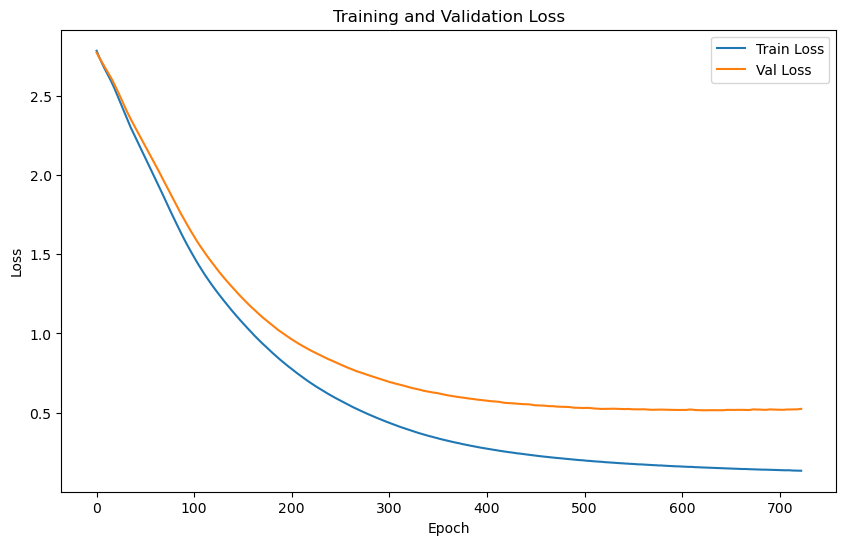

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.5205 | Test Accuracy: 81.59%


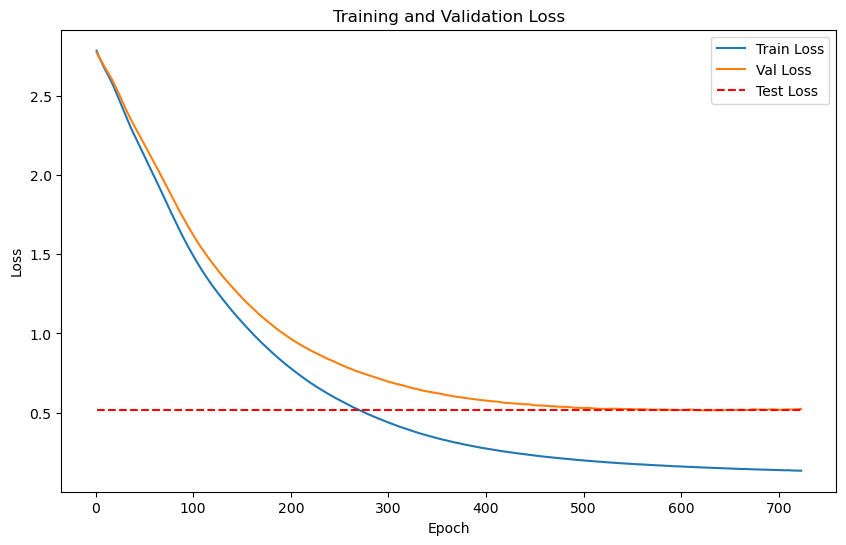

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53889, 64), 
Test labels shape: (53889,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3533
    Batch [2/2], Val Loss: 0.3347
Epoch [1/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.3440

Validation loss improved from inf to 0.3440. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3526
    Batch [2/2], Val Loss: 0.3345
Epoch [2/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.3435

Validation loss improved from 0.3440 to 0.3435. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3528
    Batch [2/2], Val Loss: 0.3344
Epoch [3/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.3436

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3534
    Batch [2/2], Val Loss: 0.3339
Epoch [4/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.3436

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3535
    Batch [2/2], Val Loss: 0.3334
Epoch [5/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.3434

Validation loss improved from 0.3435 to 0.3434. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3545
    Batch [2/2], Val Loss: 0.3325
Epoch [6/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.3435

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3551
    Batch [2/2], Val Loss: 0.3321
Epoch [7/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.3436

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3549
    Batch [2/2], Val Loss: 0.3323
Epoch [8/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.3436

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3539
    Batch [2/2], Val Loss: 0.3321
Epoch [9/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.3430

Validation loss improved from 0.3434 to 0.3430. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3536
    Batch [2/2], Val Loss: 0.3316
Epoch [10/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.3426

Validation loss improved from 0.3430 to 0.3426. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3534
    Batch [2/2], Val Loss: 0.3310
Epoch [11/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.3422

Validation loss improved from 0.3426 to 0.3422. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3531
    Batch [2/2], Val Loss: 0.3293
Epoch [12/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.3412

Validation loss improved from 0.3422 to 0.3412. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3529
    Batch [2/2], Val Loss: 0.3273
Epoch [13/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.3401

Validation loss improved from 0.3412 to 0.3401. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3522
    Batch [2/2], Val Loss: 0.3248
Epoch [14/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.3385

Validation loss improved from 0.3401 to 0.3385. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3510
    Batch [2/2], Val Loss: 0.3217
Epoch [15/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.3363

Validation loss improved from 0.3385 to 0.3363. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3500
    Batch [2/2], Val Loss: 0.3196
Epoch [16/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.3348

Validation loss improved from 0.3363 to 0.3348. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.3174
Epoch [17/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.3333

Validation loss improved from 0.3348 to 0.3333. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.3149
Epoch [18/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.3315

Validation loss improved from 0.3333 to 0.3315. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3470
    Batch [2/2], Val Loss: 0.3127
Epoch [19/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.3299

Validation loss improved from 0.3315 to 0.3299. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3462
    Batch [2/2], Val Loss: 0.3109
Epoch [20/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.3285

Validation loss improved from 0.3299 to 0.3285. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3454
    Batch [2/2], Val Loss: 0.3090
Epoch [21/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.3272

Validation loss improved from 0.3285 to 0.3272. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3446
    Batch [2/2], Val Loss: 0.3073
Epoch [22/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.3260

Validation loss improved from 0.3272 to 0.3260. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.3060
Epoch [23/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3249

Validation loss improved from 0.3260 to 0.3249. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3429
    Batch [2/2], Val Loss: 0.3047
Epoch [24/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.3238

Validation loss improved from 0.3249 to 0.3238. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3420
    Batch [2/2], Val Loss: 0.3035
Epoch [25/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.3227

Validation loss improved from 0.3238 to 0.3227. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3411
    Batch [2/2], Val Loss: 0.3024
Epoch [26/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.3217

Validation loss improved from 0.3227 to 0.3217. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3402
    Batch [2/2], Val Loss: 0.3015
Epoch [27/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3209

Validation loss improved from 0.3217 to 0.3209. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3394
    Batch [2/2], Val Loss: 0.3008
Epoch [28/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.3201

Validation loss improved from 0.3209 to 0.3201. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3385
    Batch [2/2], Val Loss: 0.3003
Epoch [29/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.3194

Validation loss improved from 0.3201 to 0.3194. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.3378
    Batch [2/2], Val Loss: 0.3001
Epoch [30/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.3190

Validation loss improved from 0.3194 to 0.3190. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.3370
    Batch [2/2], Val Loss: 0.3001
Epoch [31/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3186

Validation loss improved from 0.3190 to 0.3186. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.3363
    Batch [2/2], Val Loss: 0.3001
Epoch [32/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.3182

Validation loss improved from 0.3186 to 0.3182. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.3356
    Batch [2/2], Val Loss: 0.3002
Epoch [33/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.3179

Validation loss improved from 0.3182 to 0.3179. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.3002
Epoch [34/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.3175

Validation loss improved from 0.3179 to 0.3175. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.3342
    Batch [2/2], Val Loss: 0.3002
Epoch [35/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.3172

Validation loss improved from 0.3175 to 0.3172. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.3335
    Batch [2/2], Val Loss: 0.3001
Epoch [36/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.3168

Validation loss improved from 0.3172 to 0.3168. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.3328
    Batch [2/2], Val Loss: 0.3001
Epoch [37/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.3165

Validation loss improved from 0.3168 to 0.3165. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.3321
    Batch [2/2], Val Loss: 0.3001
Epoch [38/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.3161

Validation loss improved from 0.3165 to 0.3161. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.3314
    Batch [2/2], Val Loss: 0.3000
Epoch [39/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.3157

Validation loss improved from 0.3161 to 0.3157. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.3308
    Batch [2/2], Val Loss: 0.2999
Epoch [40/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.3154

Validation loss improved from 0.3157 to 0.3154. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.3301
    Batch [2/2], Val Loss: 0.2998
Epoch [41/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.3150

Validation loss improved from 0.3154 to 0.3150. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.3295
    Batch [2/2], Val Loss: 0.2997
Epoch [42/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.3146

Validation loss improved from 0.3150 to 0.3146. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.3289
    Batch [2/2], Val Loss: 0.2995
Epoch [43/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.3142

Validation loss improved from 0.3146 to 0.3142. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.3283
    Batch [2/2], Val Loss: 0.2993
Epoch [44/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.3138

Validation loss improved from 0.3142 to 0.3138. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.3278
    Batch [2/2], Val Loss: 0.2991
Epoch [45/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.3134

Validation loss improved from 0.3138 to 0.3134. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.3272
    Batch [2/2], Val Loss: 0.2989
Epoch [46/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.3130

Validation loss improved from 0.3134 to 0.3130. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.3266
    Batch [2/2], Val Loss: 0.2986
Epoch [47/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.3126

Validation loss improved from 0.3130 to 0.3126. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.3260
    Batch [2/2], Val Loss: 0.2984
Epoch [48/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.3122

Validation loss improved from 0.3126 to 0.3122. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.3255
    Batch [2/2], Val Loss: 0.2982
Epoch [49/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.3118

Validation loss improved from 0.3122 to 0.3118. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.3249
    Batch [2/2], Val Loss: 0.2979
Epoch [50/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.3114

Validation loss improved from 0.3118 to 0.3114. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.3244
    Batch [2/2], Val Loss: 0.2977
Epoch [51/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.3110

Validation loss improved from 0.3114 to 0.3110. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.3240
    Batch [2/2], Val Loss: 0.2973
Epoch [52/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.3107

Validation loss improved from 0.3110 to 0.3107. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.3235
    Batch [2/2], Val Loss: 0.2970
Epoch [53/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.3103

Validation loss improved from 0.3107 to 0.3103. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.3230
    Batch [2/2], Val Loss: 0.2967
Epoch [54/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.3099

Validation loss improved from 0.3103 to 0.3099. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.3226
    Batch [2/2], Val Loss: 0.2963
Epoch [55/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.3094

Validation loss improved from 0.3099 to 0.3094. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.3221
    Batch [2/2], Val Loss: 0.2959
Epoch [56/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.3090

Validation loss improved from 0.3094 to 0.3090. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.3217
    Batch [2/2], Val Loss: 0.2954
Epoch [57/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.3086

Validation loss improved from 0.3090 to 0.3086. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.3213
    Batch [2/2], Val Loss: 0.2950
Epoch [58/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.3081

Validation loss improved from 0.3086 to 0.3081. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.3208
    Batch [2/2], Val Loss: 0.2945
Epoch [59/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.3077

Validation loss improved from 0.3081 to 0.3077. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.3204
    Batch [2/2], Val Loss: 0.2940
Epoch [60/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.3072

Validation loss improved from 0.3077 to 0.3072. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4206
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.3199
    Batch [2/2], Val Loss: 0.2936
Epoch [61/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.3067

Validation loss improved from 0.3072 to 0.3067. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.3194
    Batch [2/2], Val Loss: 0.2931
Epoch [62/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.3063

Validation loss improved from 0.3067 to 0.3063. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.3189
    Batch [2/2], Val Loss: 0.2927
Epoch [63/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.3058

Validation loss improved from 0.3063 to 0.3058. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.3185
    Batch [2/2], Val Loss: 0.2923
Epoch [64/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.3054

Validation loss improved from 0.3058 to 0.3054. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4154
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.3181
    Batch [2/2], Val Loss: 0.2919
Epoch [65/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.3050

Validation loss improved from 0.3054 to 0.3050. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.3176
    Batch [2/2], Val Loss: 0.2915
Epoch [66/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.3046

Validation loss improved from 0.3050 to 0.3046. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.2912
Epoch [67/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.3042

Validation loss improved from 0.3046 to 0.3042. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.3168
    Batch [2/2], Val Loss: 0.2909
Epoch [68/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.3039

Validation loss improved from 0.3042 to 0.3039. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.3164
    Batch [2/2], Val Loss: 0.2906
Epoch [69/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.3035

Validation loss improved from 0.3039 to 0.3035. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.3160
    Batch [2/2], Val Loss: 0.2903
Epoch [70/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.3031

Validation loss improved from 0.3035 to 0.3031. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.3157
    Batch [2/2], Val Loss: 0.2899
Epoch [71/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.3028

Validation loss improved from 0.3031 to 0.3028. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.2894
Epoch [72/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.3023

Validation loss improved from 0.3028 to 0.3023. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.3148
    Batch [2/2], Val Loss: 0.2890
Epoch [73/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.3019

Validation loss improved from 0.3023 to 0.3019. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.3144
    Batch [2/2], Val Loss: 0.2886
Epoch [74/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.3015

Validation loss improved from 0.3019 to 0.3015. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.2881
Epoch [75/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.3011

Validation loss improved from 0.3015 to 0.3011. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.3137
    Batch [2/2], Val Loss: 0.2876
Epoch [76/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.3006

Validation loss improved from 0.3011 to 0.3006. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.3133
    Batch [2/2], Val Loss: 0.2871
Epoch [77/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.3002

Validation loss improved from 0.3006 to 0.3002. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.3130
    Batch [2/2], Val Loss: 0.2866
Epoch [78/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2998

Validation loss improved from 0.3002 to 0.2998. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.3126
    Batch [2/2], Val Loss: 0.2862
Epoch [79/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2994

Validation loss improved from 0.2998 to 0.2994. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.3123
    Batch [2/2], Val Loss: 0.2859
Epoch [80/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2991

Validation loss improved from 0.2994 to 0.2991. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.3119
    Batch [2/2], Val Loss: 0.2855
Epoch [81/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2987

Validation loss improved from 0.2991 to 0.2987. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.3115
    Batch [2/2], Val Loss: 0.2852
Epoch [82/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2984

Validation loss improved from 0.2987 to 0.2984. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.3112
    Batch [2/2], Val Loss: 0.2849
Epoch [83/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2980

Validation loss improved from 0.2984 to 0.2980. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.2845
Epoch [84/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2977

Validation loss improved from 0.2980 to 0.2977. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.3105
    Batch [2/2], Val Loss: 0.2841
Epoch [85/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2973

Validation loss improved from 0.2977 to 0.2973. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.3101
    Batch [2/2], Val Loss: 0.2837
Epoch [86/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2969

Validation loss improved from 0.2973 to 0.2969. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.3098
    Batch [2/2], Val Loss: 0.2834
Epoch [87/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2966

Validation loss improved from 0.2969 to 0.2966. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.3094
    Batch [2/2], Val Loss: 0.2831
Epoch [88/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2962

Validation loss improved from 0.2966 to 0.2962. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.3091
    Batch [2/2], Val Loss: 0.2827
Epoch [89/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.2959

Validation loss improved from 0.2962 to 0.2959. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.3088
    Batch [2/2], Val Loss: 0.2823
Epoch [90/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2956

Validation loss improved from 0.2959 to 0.2956. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.3085
    Batch [2/2], Val Loss: 0.2820
Epoch [91/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2953

Validation loss improved from 0.2956 to 0.2953. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.3082
    Batch [2/2], Val Loss: 0.2817
Epoch [92/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2949

Validation loss improved from 0.2953 to 0.2949. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.3079
    Batch [2/2], Val Loss: 0.2814
Epoch [93/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2946

Validation loss improved from 0.2949 to 0.2946. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.3076
    Batch [2/2], Val Loss: 0.2812
Epoch [94/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2944

Validation loss improved from 0.2946 to 0.2944. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.3074
    Batch [2/2], Val Loss: 0.2809
Epoch [95/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2941

Validation loss improved from 0.2944 to 0.2941. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.3071
    Batch [2/2], Val Loss: 0.2806
Epoch [96/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2938

Validation loss improved from 0.2941 to 0.2938. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.3068
    Batch [2/2], Val Loss: 0.2802
Epoch [97/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2935

Validation loss improved from 0.2938 to 0.2935. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.3065
    Batch [2/2], Val Loss: 0.2798
Epoch [98/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2932

Validation loss improved from 0.2935 to 0.2932. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.3063
    Batch [2/2], Val Loss: 0.2795
Epoch [99/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2929

Validation loss improved from 0.2932 to 0.2929. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.3060
    Batch [2/2], Val Loss: 0.2790
Epoch [100/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.2925

Validation loss improved from 0.2929 to 0.2925. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.3057
    Batch [2/2], Val Loss: 0.2786
Epoch [101/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2921

Validation loss improved from 0.2925 to 0.2921. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.3054
    Batch [2/2], Val Loss: 0.2782
Epoch [102/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2918

Validation loss improved from 0.2921 to 0.2918. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.3052
    Batch [2/2], Val Loss: 0.2777
Epoch [103/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2915

Validation loss improved from 0.2918 to 0.2915. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.3049
    Batch [2/2], Val Loss: 0.2773
Epoch [104/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2911

Validation loss improved from 0.2915 to 0.2911. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.3045
    Batch [2/2], Val Loss: 0.2770
Epoch [105/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2907

Validation loss improved from 0.2911 to 0.2907. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.3041
    Batch [2/2], Val Loss: 0.2766
Epoch [106/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2904

Validation loss improved from 0.2907 to 0.2904. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.3037
    Batch [2/2], Val Loss: 0.2763
Epoch [107/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2900

Validation loss improved from 0.2904 to 0.2900. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.3034
    Batch [2/2], Val Loss: 0.2759
Epoch [108/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2896

Validation loss improved from 0.2900 to 0.2896. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.3030
    Batch [2/2], Val Loss: 0.2755
Epoch [109/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2893

Validation loss improved from 0.2896 to 0.2893. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.3026
    Batch [2/2], Val Loss: 0.2751
Epoch [110/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2889

Validation loss improved from 0.2893 to 0.2889. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.3022
    Batch [2/2], Val Loss: 0.2747
Epoch [111/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2885

Validation loss improved from 0.2889 to 0.2885. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.3018
    Batch [2/2], Val Loss: 0.2743
Epoch [112/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2880

Validation loss improved from 0.2885 to 0.2880. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.3014
    Batch [2/2], Val Loss: 0.2738
Epoch [113/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2876

Validation loss improved from 0.2880 to 0.2876. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.3011
    Batch [2/2], Val Loss: 0.2733
Epoch [114/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2872

Validation loss improved from 0.2876 to 0.2872. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.3007
    Batch [2/2], Val Loss: 0.2727
Epoch [115/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2867

Validation loss improved from 0.2872 to 0.2867. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.3004
    Batch [2/2], Val Loss: 0.2723
Epoch [116/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2863

Validation loss improved from 0.2867 to 0.2863. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.3001
    Batch [2/2], Val Loss: 0.2718
Epoch [117/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2859

Validation loss improved from 0.2863 to 0.2859. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.2998
    Batch [2/2], Val Loss: 0.2713
Epoch [118/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2855

Validation loss improved from 0.2859 to 0.2855. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.2995
    Batch [2/2], Val Loss: 0.2708
Epoch [119/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2852

Validation loss improved from 0.2855 to 0.2852. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2992
    Batch [2/2], Val Loss: 0.2704
Epoch [120/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2848

Validation loss improved from 0.2852 to 0.2848. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2989
    Batch [2/2], Val Loss: 0.2701
Epoch [121/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2845

Validation loss improved from 0.2848 to 0.2845. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2985
    Batch [2/2], Val Loss: 0.2699
Epoch [122/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2842

Validation loss improved from 0.2845 to 0.2842. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2982
    Batch [2/2], Val Loss: 0.2696
Epoch [123/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2839

Validation loss improved from 0.2842 to 0.2839. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2979
    Batch [2/2], Val Loss: 0.2694
Epoch [124/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2837

Validation loss improved from 0.2839 to 0.2837. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2977
    Batch [2/2], Val Loss: 0.2692
Epoch [125/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2834

Validation loss improved from 0.2837 to 0.2834. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3843
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2975
    Batch [2/2], Val Loss: 0.2690
Epoch [126/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.2832

Validation loss improved from 0.2834 to 0.2832. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2973
    Batch [2/2], Val Loss: 0.2689
Epoch [127/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.2831

Validation loss improved from 0.2832 to 0.2831. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2971
    Batch [2/2], Val Loss: 0.2687
Epoch [128/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.2829

Validation loss improved from 0.2831 to 0.2829. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2969
    Batch [2/2], Val Loss: 0.2687
Epoch [129/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2828

Validation loss improved from 0.2829 to 0.2828. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2967
    Batch [2/2], Val Loss: 0.2685
Epoch [130/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2826

Validation loss improved from 0.2828 to 0.2826. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2965
    Batch [2/2], Val Loss: 0.2683
Epoch [131/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.2824

Validation loss improved from 0.2826 to 0.2824. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2963
    Batch [2/2], Val Loss: 0.2681
Epoch [132/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2822

Validation loss improved from 0.2824 to 0.2822. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2962
    Batch [2/2], Val Loss: 0.2679
Epoch [133/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2820

Validation loss improved from 0.2822 to 0.2820. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2960
    Batch [2/2], Val Loss: 0.2677
Epoch [134/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2818

Validation loss improved from 0.2820 to 0.2818. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2958
    Batch [2/2], Val Loss: 0.2675
Epoch [135/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.2817

Validation loss improved from 0.2818 to 0.2817. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2956
    Batch [2/2], Val Loss: 0.2673
Epoch [136/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2815

Validation loss improved from 0.2817 to 0.2815. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.2954
    Batch [2/2], Val Loss: 0.2672
Epoch [137/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2813

Validation loss improved from 0.2815 to 0.2813. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2952
    Batch [2/2], Val Loss: 0.2670
Epoch [138/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2811

Validation loss improved from 0.2813 to 0.2811. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2950
    Batch [2/2], Val Loss: 0.2668
Epoch [139/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2809

Validation loss improved from 0.2811 to 0.2809. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2948
    Batch [2/2], Val Loss: 0.2665
Epoch [140/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2807

Validation loss improved from 0.2809 to 0.2807. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2947
    Batch [2/2], Val Loss: 0.2662
Epoch [141/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.2804

Validation loss improved from 0.2807 to 0.2804. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2946
    Batch [2/2], Val Loss: 0.2659
Epoch [142/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.2802

Validation loss improved from 0.2804 to 0.2802. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2944
    Batch [2/2], Val Loss: 0.2656
Epoch [143/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.2800

Validation loss improved from 0.2802 to 0.2800. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2943
    Batch [2/2], Val Loss: 0.2652
Epoch [144/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.2798

Validation loss improved from 0.2800 to 0.2798. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2942
    Batch [2/2], Val Loss: 0.2648
Epoch [145/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.2795

Validation loss improved from 0.2798 to 0.2795. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2941
    Batch [2/2], Val Loss: 0.2644
Epoch [146/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2792

Validation loss improved from 0.2795 to 0.2792. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2939
    Batch [2/2], Val Loss: 0.2641
Epoch [147/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2790

Validation loss improved from 0.2792 to 0.2790. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.2637
Epoch [148/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2787

Validation loss improved from 0.2790 to 0.2787. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2937
    Batch [2/2], Val Loss: 0.2633
Epoch [149/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2785

Validation loss improved from 0.2787 to 0.2785. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.2628
Epoch [150/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2782

Validation loss improved from 0.2785 to 0.2782. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.2625
Epoch [151/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.2780

Validation loss improved from 0.2782 to 0.2780. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.2622
Epoch [152/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2777

Validation loss improved from 0.2780 to 0.2777. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2931
    Batch [2/2], Val Loss: 0.2619
Epoch [153/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2775

Validation loss improved from 0.2777 to 0.2775. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.2616
Epoch [154/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2773

Validation loss improved from 0.2775 to 0.2773. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2928
    Batch [2/2], Val Loss: 0.2614
Epoch [155/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2771

Validation loss improved from 0.2773 to 0.2771. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2925
    Batch [2/2], Val Loss: 0.2612
Epoch [156/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2769

Validation loss improved from 0.2771 to 0.2769. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2923
    Batch [2/2], Val Loss: 0.2609
Epoch [157/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2766

Validation loss improved from 0.2769 to 0.2766. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2921
    Batch [2/2], Val Loss: 0.2606
Epoch [158/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2764

Validation loss improved from 0.2766 to 0.2764. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2919
    Batch [2/2], Val Loss: 0.2603
Epoch [159/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2761

Validation loss improved from 0.2764 to 0.2761. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2916
    Batch [2/2], Val Loss: 0.2601
Epoch [160/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2758

Validation loss improved from 0.2761 to 0.2758. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2914
    Batch [2/2], Val Loss: 0.2599
Epoch [161/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2756

Validation loss improved from 0.2758 to 0.2756. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2912
    Batch [2/2], Val Loss: 0.2597
Epoch [162/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2754

Validation loss improved from 0.2756 to 0.2754. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2909
    Batch [2/2], Val Loss: 0.2595
Epoch [163/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2752

Validation loss improved from 0.2754 to 0.2752. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2907
    Batch [2/2], Val Loss: 0.2594
Epoch [164/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2750

Validation loss improved from 0.2752 to 0.2750. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2905
    Batch [2/2], Val Loss: 0.2592
Epoch [165/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.2749

Validation loss improved from 0.2750 to 0.2749. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2903
    Batch [2/2], Val Loss: 0.2591
Epoch [166/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2747

Validation loss improved from 0.2749 to 0.2747. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2902
    Batch [2/2], Val Loss: 0.2589
Epoch [167/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2746

Validation loss improved from 0.2747 to 0.2746. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2901
    Batch [2/2], Val Loss: 0.2588
Epoch [168/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.2744

Validation loss improved from 0.2746 to 0.2744. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2900
    Batch [2/2], Val Loss: 0.2587
Epoch [169/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2744

Validation loss improved from 0.2744 to 0.2744. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3580
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2899
    Batch [2/2], Val Loss: 0.2586
Epoch [170/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.2743

Validation loss improved from 0.2744 to 0.2743. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2899
    Batch [2/2], Val Loss: 0.2585
Epoch [171/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.2742

Validation loss improved from 0.2743 to 0.2742. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2898
    Batch [2/2], Val Loss: 0.2584
Epoch [172/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.2741

Validation loss improved from 0.2742 to 0.2741. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2897
    Batch [2/2], Val Loss: 0.2583
Epoch [173/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.2740

Validation loss improved from 0.2741 to 0.2740. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2896
    Batch [2/2], Val Loss: 0.2582
Epoch [174/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2739

Validation loss improved from 0.2740 to 0.2739. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2895
    Batch [2/2], Val Loss: 0.2581
Epoch [175/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.2738

Validation loss improved from 0.2739 to 0.2738. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3553
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2894
    Batch [2/2], Val Loss: 0.2579
Epoch [176/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.2736

Validation loss improved from 0.2738 to 0.2736. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2892
    Batch [2/2], Val Loss: 0.2577
Epoch [177/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2735

Validation loss improved from 0.2736 to 0.2735. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2891
    Batch [2/2], Val Loss: 0.2575
Epoch [178/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2733

Validation loss improved from 0.2735 to 0.2733. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.2573
Epoch [179/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2731

Validation loss improved from 0.2733 to 0.2731. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3580
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.2570
Epoch [180/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.2729

Validation loss improved from 0.2731 to 0.2729. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3585
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.2567
Epoch [181/2000], Avg Train Loss: 0.3585, Avg Val Loss: 0.2727

Validation loss improved from 0.2729 to 0.2727. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3540
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.2565
Epoch [182/2000], Avg Train Loss: 0.3540, Avg Val Loss: 0.2725

Validation loss improved from 0.2727 to 0.2725. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.2562
Epoch [183/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.2724

Validation loss improved from 0.2725 to 0.2724. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.2560
Epoch [184/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.2722

Validation loss improved from 0.2724 to 0.2722. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3561
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.2558
Epoch [185/2000], Avg Train Loss: 0.3561, Avg Val Loss: 0.2720

Validation loss improved from 0.2722 to 0.2720. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2881
    Batch [2/2], Val Loss: 0.2555
Epoch [186/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.2718

Validation loss improved from 0.2720 to 0.2718. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2880
    Batch [2/2], Val Loss: 0.2553
Epoch [187/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.2716

Validation loss improved from 0.2718 to 0.2716. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2878
    Batch [2/2], Val Loss: 0.2552
Epoch [188/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.2715

Validation loss improved from 0.2716 to 0.2715. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3579
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2877
    Batch [2/2], Val Loss: 0.2550
Epoch [189/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.2714

Validation loss improved from 0.2715 to 0.2714. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2876
    Batch [2/2], Val Loss: 0.2548
Epoch [190/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.2712

Validation loss improved from 0.2714 to 0.2712. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2875
    Batch [2/2], Val Loss: 0.2547
Epoch [191/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.2711

Validation loss improved from 0.2712 to 0.2711. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2874
    Batch [2/2], Val Loss: 0.2545
Epoch [192/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2709

Validation loss improved from 0.2711 to 0.2709. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2873
    Batch [2/2], Val Loss: 0.2543
Epoch [193/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.2708

Validation loss improved from 0.2709 to 0.2708. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2871
    Batch [2/2], Val Loss: 0.2541
Epoch [194/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2706

Validation loss improved from 0.2708 to 0.2706. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2869
    Batch [2/2], Val Loss: 0.2539
Epoch [195/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.2704

Validation loss improved from 0.2706 to 0.2704. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2867
    Batch [2/2], Val Loss: 0.2538
Epoch [196/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.2702

Validation loss improved from 0.2704 to 0.2702. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2865
    Batch [2/2], Val Loss: 0.2537
Epoch [197/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2701

Validation loss improved from 0.2702 to 0.2701. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2863
    Batch [2/2], Val Loss: 0.2535
Epoch [198/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2699

Validation loss improved from 0.2701 to 0.2699. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2861
    Batch [2/2], Val Loss: 0.2533
Epoch [199/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.2697

Validation loss improved from 0.2699 to 0.2697. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2858
    Batch [2/2], Val Loss: 0.2530
Epoch [200/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.2694

Validation loss improved from 0.2697 to 0.2694. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2855
    Batch [2/2], Val Loss: 0.2528
Epoch [201/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.2692

Validation loss improved from 0.2694 to 0.2692. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2853
    Batch [2/2], Val Loss: 0.2526
Epoch [202/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2689

Validation loss improved from 0.2692 to 0.2689. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2850
    Batch [2/2], Val Loss: 0.2523
Epoch [203/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.2686

Validation loss improved from 0.2689 to 0.2686. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2847
    Batch [2/2], Val Loss: 0.2520
Epoch [204/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2684

Validation loss improved from 0.2686 to 0.2684. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2845
    Batch [2/2], Val Loss: 0.2516
Epoch [205/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2681

Validation loss improved from 0.2684 to 0.2681. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2844
    Batch [2/2], Val Loss: 0.2513
Epoch [206/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2678

Validation loss improved from 0.2681 to 0.2678. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2842
    Batch [2/2], Val Loss: 0.2509
Epoch [207/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2676

Validation loss improved from 0.2678 to 0.2676. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2841
    Batch [2/2], Val Loss: 0.2506
Epoch [208/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2674

Validation loss improved from 0.2676 to 0.2674. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2840
    Batch [2/2], Val Loss: 0.2504
Epoch [209/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2672

Validation loss improved from 0.2674 to 0.2672. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2839
    Batch [2/2], Val Loss: 0.2503
Epoch [210/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.2671

Validation loss improved from 0.2672 to 0.2671. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2838
    Batch [2/2], Val Loss: 0.2500
Epoch [211/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.2669

Validation loss improved from 0.2671 to 0.2669. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2838
    Batch [2/2], Val Loss: 0.2500
Epoch [212/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2669

Validation loss improved from 0.2669 to 0.2669. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3363
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2837
    Batch [2/2], Val Loss: 0.2500
Epoch [213/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.2669

Validation loss improved from 0.2669 to 0.2669. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2837
    Batch [2/2], Val Loss: 0.2500
Epoch [214/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2669

Validation loss improved from 0.2669 to 0.2669. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2837
    Batch [2/2], Val Loss: 0.2500
Epoch [215/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2669

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2837
    Batch [2/2], Val Loss: 0.2501
Epoch [216/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2669

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2836
    Batch [2/2], Val Loss: 0.2501
Epoch [217/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2669

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2836
    Batch [2/2], Val Loss: 0.2501
Epoch [218/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2668

Validation loss improved from 0.2669 to 0.2668. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2835
    Batch [2/2], Val Loss: 0.2500
Epoch [219/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2667

Validation loss improved from 0.2668 to 0.2667. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3399
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2835
    Batch [2/2], Val Loss: 0.2499
Epoch [220/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.2667

Validation loss improved from 0.2667 to 0.2667. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3351
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2834
    Batch [2/2], Val Loss: 0.2498
Epoch [221/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.2666

Validation loss improved from 0.2667 to 0.2666. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3360
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2834
    Batch [2/2], Val Loss: 0.2497
Epoch [222/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.2665

Validation loss improved from 0.2666 to 0.2665. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3341
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2833
    Batch [2/2], Val Loss: 0.2496
Epoch [223/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.2665

Validation loss improved from 0.2665 to 0.2665. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2833
    Batch [2/2], Val Loss: 0.2495
Epoch [224/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.2664

Validation loss improved from 0.2665 to 0.2664. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3353
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.2834
    Batch [2/2], Val Loss: 0.2494
Epoch [225/2000], Avg Train Loss: 0.3353, Avg Val Loss: 0.2664

Validation loss improved from 0.2664 to 0.2664. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3370
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2833
    Batch [2/2], Val Loss: 0.2493
Epoch [226/2000], Avg Train Loss: 0.3370, Avg Val Loss: 0.2663

Validation loss improved from 0.2664 to 0.2663. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.2834
    Batch [2/2], Val Loss: 0.2492
Epoch [227/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.2663

Validation loss improved from 0.2663 to 0.2663. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3358
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.2834
    Batch [2/2], Val Loss: 0.2491
Epoch [228/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.2662

Validation loss improved from 0.2663 to 0.2662. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3361
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.2834
    Batch [2/2], Val Loss: 0.2490
Epoch [229/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.2662

Validation loss improved from 0.2662 to 0.2662. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.2833
    Batch [2/2], Val Loss: 0.2488
Epoch [230/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2661

Validation loss improved from 0.2662 to 0.2661. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.2832
    Batch [2/2], Val Loss: 0.2486
Epoch [231/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.2659

Validation loss improved from 0.2661 to 0.2659. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3282
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2831
    Batch [2/2], Val Loss: 0.2483
Epoch [232/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.2657

Validation loss improved from 0.2659 to 0.2657. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3398
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.2830
    Batch [2/2], Val Loss: 0.2481
Epoch [233/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.2656

Validation loss improved from 0.2657 to 0.2656. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.2829
    Batch [2/2], Val Loss: 0.2479
Epoch [234/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.2654

Validation loss improved from 0.2656 to 0.2654. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2828
    Batch [2/2], Val Loss: 0.2478
Epoch [235/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.2653

Validation loss improved from 0.2654 to 0.2653. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.2827
    Batch [2/2], Val Loss: 0.2477
Epoch [236/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.2652

Validation loss improved from 0.2653 to 0.2652. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.2827
    Batch [2/2], Val Loss: 0.2476
Epoch [237/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2651

Validation loss improved from 0.2652 to 0.2651. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3399
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.2827
    Batch [2/2], Val Loss: 0.2475
Epoch [238/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.2651

Validation loss improved from 0.2651 to 0.2651. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3363
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.2826
    Batch [2/2], Val Loss: 0.2474
Epoch [239/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.2650

Validation loss improved from 0.2651 to 0.2650. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2826
    Batch [2/2], Val Loss: 0.2473
Epoch [240/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.2649

Validation loss improved from 0.2650 to 0.2649. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.2825
    Batch [2/2], Val Loss: 0.2472
Epoch [241/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.2648

Validation loss improved from 0.2649 to 0.2648. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3326
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.2824
    Batch [2/2], Val Loss: 0.2469
Epoch [242/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.2646

Validation loss improved from 0.2648 to 0.2646. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.2823
    Batch [2/2], Val Loss: 0.2466
Epoch [243/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.2644

Validation loss improved from 0.2646 to 0.2644. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.2822
    Batch [2/2], Val Loss: 0.2463
Epoch [244/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2642

Validation loss improved from 0.2644 to 0.2642. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3342
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.2821
    Batch [2/2], Val Loss: 0.2461
Epoch [245/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.2641

Validation loss improved from 0.2642 to 0.2641. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.2820
    Batch [2/2], Val Loss: 0.2458
Epoch [246/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.2639

Validation loss improved from 0.2641 to 0.2639. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.2819
    Batch [2/2], Val Loss: 0.2455
Epoch [247/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.2637

Validation loss improved from 0.2639 to 0.2637. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3255
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.2818
    Batch [2/2], Val Loss: 0.2453
Epoch [248/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.2635

Validation loss improved from 0.2637 to 0.2635. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3330
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.2817
    Batch [2/2], Val Loss: 0.2450
Epoch [249/2000], Avg Train Loss: 0.3330, Avg Val Loss: 0.2634

Validation loss improved from 0.2635 to 0.2634. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.2817
    Batch [2/2], Val Loss: 0.2448
Epoch [250/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.2632

Validation loss improved from 0.2634 to 0.2632. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.2816
    Batch [2/2], Val Loss: 0.2445
Epoch [251/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.2630

Validation loss improved from 0.2632 to 0.2630. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.2815
    Batch [2/2], Val Loss: 0.2443
Epoch [252/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.2629

Validation loss improved from 0.2630 to 0.2629. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.2814
    Batch [2/2], Val Loss: 0.2441
Epoch [253/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.2627

Validation loss improved from 0.2629 to 0.2627. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3262
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.2813
    Batch [2/2], Val Loss: 0.2438
Epoch [254/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.2625

Validation loss improved from 0.2627 to 0.2625. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3261
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.2811
    Batch [2/2], Val Loss: 0.2436
Epoch [255/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.2624

Validation loss improved from 0.2625 to 0.2624. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3360
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.2810
    Batch [2/2], Val Loss: 0.2433
Epoch [256/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.2622

Validation loss improved from 0.2624 to 0.2622. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3246
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.2809
    Batch [2/2], Val Loss: 0.2431
Epoch [257/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.2620

Validation loss improved from 0.2622 to 0.2620. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.2807
    Batch [2/2], Val Loss: 0.2428
Epoch [258/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.2618

Validation loss improved from 0.2620 to 0.2618. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3230
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.2807
    Batch [2/2], Val Loss: 0.2426
Epoch [259/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.2616

Validation loss improved from 0.2618 to 0.2616. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3303
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.2805
    Batch [2/2], Val Loss: 0.2423
Epoch [260/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.2614

Validation loss improved from 0.2616 to 0.2614. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3295
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.2804
    Batch [2/2], Val Loss: 0.2421
Epoch [261/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.2613

Validation loss improved from 0.2614 to 0.2613. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.2804
    Batch [2/2], Val Loss: 0.2419
Epoch [262/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.2612

Validation loss improved from 0.2613 to 0.2612. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.2803
    Batch [2/2], Val Loss: 0.2418
Epoch [263/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.2610

Validation loss improved from 0.2612 to 0.2610. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3279
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.2801
    Batch [2/2], Val Loss: 0.2416
Epoch [264/2000], Avg Train Loss: 0.3279, Avg Val Loss: 0.2609

Validation loss improved from 0.2610 to 0.2609. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.2800
    Batch [2/2], Val Loss: 0.2414
Epoch [265/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.2607

Validation loss improved from 0.2609 to 0.2607. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.2799
    Batch [2/2], Val Loss: 0.2412
Epoch [266/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.2606

Validation loss improved from 0.2607 to 0.2606. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3258
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.2798
    Batch [2/2], Val Loss: 0.2411
Epoch [267/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.2605

Validation loss improved from 0.2606 to 0.2605. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.2797
    Batch [2/2], Val Loss: 0.2409
Epoch [268/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.2603

Validation loss improved from 0.2605 to 0.2603. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3266
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.2796
    Batch [2/2], Val Loss: 0.2407
Epoch [269/2000], Avg Train Loss: 0.3266, Avg Val Loss: 0.2601

Validation loss improved from 0.2603 to 0.2601. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3268
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.2795
    Batch [2/2], Val Loss: 0.2405
Epoch [270/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.2600

Validation loss improved from 0.2601 to 0.2600. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.2794
    Batch [2/2], Val Loss: 0.2403
Epoch [271/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.2598

Validation loss improved from 0.2600 to 0.2598. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3125
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.2792
    Batch [2/2], Val Loss: 0.2402
Epoch [272/2000], Avg Train Loss: 0.3125, Avg Val Loss: 0.2597

Validation loss improved from 0.2598 to 0.2597. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3143
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.2791
    Batch [2/2], Val Loss: 0.2401
Epoch [273/2000], Avg Train Loss: 0.3143, Avg Val Loss: 0.2596

Validation loss improved from 0.2597 to 0.2596. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.2790
    Batch [2/2], Val Loss: 0.2400
Epoch [274/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.2595

Validation loss improved from 0.2596 to 0.2595. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3205
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.2789
    Batch [2/2], Val Loss: 0.2399
Epoch [275/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.2594

Validation loss improved from 0.2595 to 0.2594. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3188
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.2788
    Batch [2/2], Val Loss: 0.2397
Epoch [276/2000], Avg Train Loss: 0.3188, Avg Val Loss: 0.2593

Validation loss improved from 0.2594 to 0.2593. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.2788
    Batch [2/2], Val Loss: 0.2394
Epoch [277/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.2591

Validation loss improved from 0.2593 to 0.2591. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3145
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.2787
    Batch [2/2], Val Loss: 0.2392
Epoch [278/2000], Avg Train Loss: 0.3145, Avg Val Loss: 0.2590

Validation loss improved from 0.2591 to 0.2590. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3225
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.2787
    Batch [2/2], Val Loss: 0.2390
Epoch [279/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.2588

Validation loss improved from 0.2590 to 0.2588. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3244
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.2786
    Batch [2/2], Val Loss: 0.2387
Epoch [280/2000], Avg Train Loss: 0.3244, Avg Val Loss: 0.2587

Validation loss improved from 0.2588 to 0.2587. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3118
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.2785
    Batch [2/2], Val Loss: 0.2384
Epoch [281/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.2585

Validation loss improved from 0.2587 to 0.2585. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3170
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.2785
    Batch [2/2], Val Loss: 0.2382
Epoch [282/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.2583

Validation loss improved from 0.2585 to 0.2583. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.2784
    Batch [2/2], Val Loss: 0.2380
Epoch [283/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2582

Validation loss improved from 0.2583 to 0.2582. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.2783
    Batch [2/2], Val Loss: 0.2378
Epoch [284/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.2581

Validation loss improved from 0.2582 to 0.2581. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.2783
    Batch [2/2], Val Loss: 0.2376
Epoch [285/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.2580

Validation loss improved from 0.2581 to 0.2580. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3165
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.2782
    Batch [2/2], Val Loss: 0.2374
Epoch [286/2000], Avg Train Loss: 0.3165, Avg Val Loss: 0.2578

Validation loss improved from 0.2580 to 0.2578. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.2782
    Batch [2/2], Val Loss: 0.2373
Epoch [287/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.2781
    Batch [2/2], Val Loss: 0.2373
Epoch [288/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.2577

Validation loss improved from 0.2577 to 0.2577. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3196
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.2780
    Batch [2/2], Val Loss: 0.2372
Epoch [289/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.3061
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.2779
    Batch [2/2], Val Loss: 0.2372
Epoch [290/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.2576

Validation loss improved from 0.2576 to 0.2576. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.2778
    Batch [2/2], Val Loss: 0.2373
Epoch [291/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.2777
    Batch [2/2], Val Loss: 0.2373
Epoch [292/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.2575

Validation loss improved from 0.2575 to 0.2575. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3175
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.2776
    Batch [2/2], Val Loss: 0.2373
Epoch [293/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.2575

Validation loss improved from 0.2575 to 0.2575. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3147
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.2776
    Batch [2/2], Val Loss: 0.2372
Epoch [294/2000], Avg Train Loss: 0.3147, Avg Val Loss: 0.2574

Validation loss improved from 0.2575 to 0.2574. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3047
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.2775
    Batch [2/2], Val Loss: 0.2369
Epoch [295/2000], Avg Train Loss: 0.3047, Avg Val Loss: 0.2572

Validation loss improved from 0.2574 to 0.2572. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3153
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.2774
    Batch [2/2], Val Loss: 0.2368
Epoch [296/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.3136
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.2773
    Batch [2/2], Val Loss: 0.2366
Epoch [297/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.2570

Validation loss improved from 0.2571 to 0.2570. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.3164
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.2772
    Batch [2/2], Val Loss: 0.2364
Epoch [298/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.2568

Validation loss improved from 0.2570 to 0.2568. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.3069
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.2771
    Batch [2/2], Val Loss: 0.2361
Epoch [299/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.2566

Validation loss improved from 0.2568 to 0.2566. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3124
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.2771
    Batch [2/2], Val Loss: 0.2358
Epoch [300/2000], Avg Train Loss: 0.3124, Avg Val Loss: 0.2564

Validation loss improved from 0.2566 to 0.2564. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3118
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.2770
    Batch [2/2], Val Loss: 0.2355
Epoch [301/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.2563

Validation loss improved from 0.2564 to 0.2563. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.3089
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.2769
    Batch [2/2], Val Loss: 0.2353
Epoch [302/2000], Avg Train Loss: 0.3089, Avg Val Loss: 0.2561

Validation loss improved from 0.2563 to 0.2561. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.2769
    Batch [2/2], Val Loss: 0.2351
Epoch [303/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.2560

Validation loss improved from 0.2561 to 0.2560. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.3199
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.2768
    Batch [2/2], Val Loss: 0.2348
Epoch [304/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.2558

Validation loss improved from 0.2560 to 0.2558. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.2768
    Batch [2/2], Val Loss: 0.2345
Epoch [305/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.2556

Validation loss improved from 0.2558 to 0.2556. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.2768
    Batch [2/2], Val Loss: 0.2342
Epoch [306/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.2555

Validation loss improved from 0.2556 to 0.2555. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.3070
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.2768
    Batch [2/2], Val Loss: 0.2339
Epoch [307/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.2554

Validation loss improved from 0.2555 to 0.2554. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.3089
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.2768
    Batch [2/2], Val Loss: 0.2338
Epoch [308/2000], Avg Train Loss: 0.3089, Avg Val Loss: 0.2553

Validation loss improved from 0.2554 to 0.2553. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.2769
    Batch [2/2], Val Loss: 0.2336
Epoch [309/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.2553

Validation loss improved from 0.2553 to 0.2553. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3034
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.2769
    Batch [2/2], Val Loss: 0.2335
Epoch [310/2000], Avg Train Loss: 0.3034, Avg Val Loss: 0.2552

Validation loss improved from 0.2553 to 0.2552. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.2770
    Batch [2/2], Val Loss: 0.2333
Epoch [311/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.2551

Validation loss improved from 0.2552 to 0.2551. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3141
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.2770
    Batch [2/2], Val Loss: 0.2332
Epoch [312/2000], Avg Train Loss: 0.3141, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.3143
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.2769
    Batch [2/2], Val Loss: 0.2331
Epoch [313/2000], Avg Train Loss: 0.3143, Avg Val Loss: 0.2550

Validation loss improved from 0.2551 to 0.2550. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.3053
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.2769
    Batch [2/2], Val Loss: 0.2330
Epoch [314/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.2549

Validation loss improved from 0.2550 to 0.2549. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3086
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.2769
    Batch [2/2], Val Loss: 0.2329
Epoch [315/2000], Avg Train Loss: 0.3086, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.3068
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.2768
    Batch [2/2], Val Loss: 0.2327
Epoch [316/2000], Avg Train Loss: 0.3068, Avg Val Loss: 0.2548

Validation loss improved from 0.2549 to 0.2548. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.2768
    Batch [2/2], Val Loss: 0.2324
Epoch [317/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.2546

Validation loss improved from 0.2548 to 0.2546. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.3085
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.2767
    Batch [2/2], Val Loss: 0.2322
Epoch [318/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.2544

Validation loss improved from 0.2546 to 0.2544. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.3061
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.2766
    Batch [2/2], Val Loss: 0.2319
Epoch [319/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.2542

Validation loss improved from 0.2544 to 0.2542. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.3159
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.2764
    Batch [2/2], Val Loss: 0.2317
Epoch [320/2000], Avg Train Loss: 0.3159, Avg Val Loss: 0.2541

Validation loss improved from 0.2542 to 0.2541. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.3030
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.2763
    Batch [2/2], Val Loss: 0.2316
Epoch [321/2000], Avg Train Loss: 0.3030, Avg Val Loss: 0.2539

Validation loss improved from 0.2541 to 0.2539. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.3127
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.2761
    Batch [2/2], Val Loss: 0.2313
Epoch [322/2000], Avg Train Loss: 0.3127, Avg Val Loss: 0.2537

Validation loss improved from 0.2539 to 0.2537. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.3029
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.2760
    Batch [2/2], Val Loss: 0.2310
Epoch [323/2000], Avg Train Loss: 0.3029, Avg Val Loss: 0.2535

Validation loss improved from 0.2537 to 0.2535. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3091
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.2759
    Batch [2/2], Val Loss: 0.2308
Epoch [324/2000], Avg Train Loss: 0.3091, Avg Val Loss: 0.2533

Validation loss improved from 0.2535 to 0.2533. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.3061
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.2757
    Batch [2/2], Val Loss: 0.2306
Epoch [325/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.2532

Validation loss improved from 0.2533 to 0.2532. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.3052
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.2756
    Batch [2/2], Val Loss: 0.2303
Epoch [326/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.2530

Validation loss improved from 0.2532 to 0.2530. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.2995
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.2755
    Batch [2/2], Val Loss: 0.2301
Epoch [327/2000], Avg Train Loss: 0.2995, Avg Val Loss: 0.2528

Validation loss improved from 0.2530 to 0.2528. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.3047
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.2754
    Batch [2/2], Val Loss: 0.2300
Epoch [328/2000], Avg Train Loss: 0.3047, Avg Val Loss: 0.2527

Validation loss improved from 0.2528 to 0.2527. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.3021
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.2754
    Batch [2/2], Val Loss: 0.2298
Epoch [329/2000], Avg Train Loss: 0.3021, Avg Val Loss: 0.2526

Validation loss improved from 0.2527 to 0.2526. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.3031
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.2753
    Batch [2/2], Val Loss: 0.2297
Epoch [330/2000], Avg Train Loss: 0.3031, Avg Val Loss: 0.2525

Validation loss improved from 0.2526 to 0.2525. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.2753
    Batch [2/2], Val Loss: 0.2295
Epoch [331/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.2524

Validation loss improved from 0.2525 to 0.2524. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.3016
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.2752
    Batch [2/2], Val Loss: 0.2293
Epoch [332/2000], Avg Train Loss: 0.3016, Avg Val Loss: 0.2523

Validation loss improved from 0.2524 to 0.2523. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.3041
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.2291
Epoch [333/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.2521

Validation loss improved from 0.2523 to 0.2521. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.3007
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.2750
    Batch [2/2], Val Loss: 0.2290
Epoch [334/2000], Avg Train Loss: 0.3007, Avg Val Loss: 0.2520

Validation loss improved from 0.2521 to 0.2520. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.2974
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.2289
Epoch [335/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.2519

Validation loss improved from 0.2520 to 0.2519. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.3028
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.2288
Epoch [336/2000], Avg Train Loss: 0.3028, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2991
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.2288
Epoch [337/2000], Avg Train Loss: 0.2991, Avg Val Loss: 0.2518

Validation loss improved from 0.2519 to 0.2518. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2946
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.2288
Epoch [338/2000], Avg Train Loss: 0.2946, Avg Val Loss: 0.2518

Validation loss improved from 0.2518 to 0.2518. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.2287
Epoch [339/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.2517

Validation loss improved from 0.2518 to 0.2517. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.3056
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.2285
Epoch [340/2000], Avg Train Loss: 0.3056, Avg Val Loss: 0.2517

Validation loss improved from 0.2517 to 0.2517. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2992
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.2283
Epoch [341/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.2515

Validation loss improved from 0.2517 to 0.2515. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2967
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.2281
Epoch [342/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.2515

Validation loss improved from 0.2515 to 0.2515. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3002
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.2280
Epoch [343/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.2514

Validation loss improved from 0.2515 to 0.2514. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2940
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.2278
Epoch [344/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.2514

Validation loss improved from 0.2514 to 0.2514. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.3057
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.2750
    Batch [2/2], Val Loss: 0.2276
Epoch [345/2000], Avg Train Loss: 0.3057, Avg Val Loss: 0.2513

Validation loss improved from 0.2514 to 0.2513. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.2274
Epoch [346/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.2513

Validation loss improved from 0.2513 to 0.2513. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2999
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.2752
    Batch [2/2], Val Loss: 0.2273
Epoch [347/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.2513

Validation loss improved from 0.2513 to 0.2513. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3022
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.2752
    Batch [2/2], Val Loss: 0.2272
Epoch [348/2000], Avg Train Loss: 0.3022, Avg Val Loss: 0.2512

Validation loss improved from 0.2513 to 0.2512. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.2753
    Batch [2/2], Val Loss: 0.2270
Epoch [349/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.2512

Validation loss improved from 0.2512 to 0.2512. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.2754
    Batch [2/2], Val Loss: 0.2269
Epoch [350/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.2511

Validation loss improved from 0.2512 to 0.2511. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.2754
    Batch [2/2], Val Loss: 0.2266
Epoch [351/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.2510

Validation loss improved from 0.2511 to 0.2510. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2979
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.2755
    Batch [2/2], Val Loss: 0.2263
Epoch [352/2000], Avg Train Loss: 0.2979, Avg Val Loss: 0.2509

Validation loss improved from 0.2510 to 0.2509. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2901
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.2754
    Batch [2/2], Val Loss: 0.2261
Epoch [353/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.2508

Validation loss improved from 0.2509 to 0.2508. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.3025
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.2754
    Batch [2/2], Val Loss: 0.2259
Epoch [354/2000], Avg Train Loss: 0.3025, Avg Val Loss: 0.2507

Validation loss improved from 0.2508 to 0.2507. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2943
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.2754
    Batch [2/2], Val Loss: 0.2258
Epoch [355/2000], Avg Train Loss: 0.2943, Avg Val Loss: 0.2506

Validation loss improved from 0.2507 to 0.2506. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.2753
    Batch [2/2], Val Loss: 0.2257
Epoch [356/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.2505

Validation loss improved from 0.2506 to 0.2505. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2920
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.2753
    Batch [2/2], Val Loss: 0.2257
Epoch [357/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.2505

Validation loss improved from 0.2505 to 0.2505. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2954
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.2752
    Batch [2/2], Val Loss: 0.2256
Epoch [358/2000], Avg Train Loss: 0.2954, Avg Val Loss: 0.2504

Validation loss improved from 0.2505 to 0.2504. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2979
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.2752
    Batch [2/2], Val Loss: 0.2256
Epoch [359/2000], Avg Train Loss: 0.2979, Avg Val Loss: 0.2504

Validation loss improved from 0.2504 to 0.2504. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.2256
Epoch [360/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.2504

Validation loss improved from 0.2504 to 0.2504. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.3011
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.2255
Epoch [361/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.2503

Validation loss improved from 0.2504 to 0.2503. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2985
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.2255
Epoch [362/2000], Avg Train Loss: 0.2985, Avg Val Loss: 0.2503

Validation loss improved from 0.2503 to 0.2503. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2913
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.2255
Epoch [363/2000], Avg Train Loss: 0.2913, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.2254
Epoch [364/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.2503

Validation loss improved from 0.2503 to 0.2503. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2957
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.2254
Epoch [365/2000], Avg Train Loss: 0.2957, Avg Val Loss: 0.2502

Validation loss improved from 0.2503 to 0.2502. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2903
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.2254
Epoch [366/2000], Avg Train Loss: 0.2903, Avg Val Loss: 0.2502

Validation loss improved from 0.2502 to 0.2502. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2977
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.2254
Epoch [367/2000], Avg Train Loss: 0.2977, Avg Val Loss: 0.2502

Validation loss improved from 0.2502 to 0.2502. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.2750
    Batch [2/2], Val Loss: 0.2254
Epoch [368/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.2502

Validation loss improved from 0.2502 to 0.2502. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.2254
Epoch [369/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.2502

Validation loss improved from 0.2502 to 0.2502. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2992
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.2254
Epoch [370/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.2501

Validation loss improved from 0.2502 to 0.2501. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2937
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.2253
Epoch [371/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.2501

Validation loss improved from 0.2501 to 0.2501. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2918
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.2253
Epoch [372/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.2501

Validation loss improved from 0.2501 to 0.2501. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2881
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.2253
Epoch [373/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.2500

Validation loss improved from 0.2501 to 0.2500. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.2253
Epoch [374/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.2500

Validation loss improved from 0.2500 to 0.2500. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2879
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.2747
    Batch [2/2], Val Loss: 0.2253
Epoch [375/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2875
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.2747
    Batch [2/2], Val Loss: 0.2253
Epoch [376/2000], Avg Train Loss: 0.2875, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.2747
    Batch [2/2], Val Loss: 0.2253
Epoch [377/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2500

Validation loss improved from 0.2500 to 0.2500. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.2747
    Batch [2/2], Val Loss: 0.2253
Epoch [378/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.2253
Epoch [379/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2928
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.2252
Epoch [380/2000], Avg Train Loss: 0.2928, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.2750
    Batch [2/2], Val Loss: 0.2251
Epoch [381/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.2750
    Batch [2/2], Val Loss: 0.2250
Epoch [382/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.2249
Epoch [383/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.2500

Validation loss improved from 0.2500 to 0.2500. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.2246
Epoch [384/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2498

Validation loss improved from 0.2500 to 0.2498. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.2243
Epoch [385/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2497

Validation loss improved from 0.2498 to 0.2497. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.2750
    Batch [2/2], Val Loss: 0.2239
Epoch [386/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.2495

Validation loss improved from 0.2497 to 0.2495. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.2237
Epoch [387/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.2493

Validation loss improved from 0.2495 to 0.2493. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2988
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.2750
    Batch [2/2], Val Loss: 0.2234
Epoch [388/2000], Avg Train Loss: 0.2988, Avg Val Loss: 0.2492

Validation loss improved from 0.2493 to 0.2492. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.2231
Epoch [389/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.2490

Validation loss improved from 0.2492 to 0.2490. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.2229
Epoch [390/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.2489

Validation loss improved from 0.2490 to 0.2489. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.2747
    Batch [2/2], Val Loss: 0.2227
Epoch [391/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.2487

Validation loss improved from 0.2489 to 0.2487. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2868
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.2747
    Batch [2/2], Val Loss: 0.2226
Epoch [392/2000], Avg Train Loss: 0.2868, Avg Val Loss: 0.2486

Validation loss improved from 0.2487 to 0.2486. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2885
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.2747
    Batch [2/2], Val Loss: 0.2225
Epoch [393/2000], Avg Train Loss: 0.2885, Avg Val Loss: 0.2486

Validation loss improved from 0.2486 to 0.2486. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.2746
    Batch [2/2], Val Loss: 0.2225
Epoch [394/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.2486

Validation loss improved from 0.2486 to 0.2486. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.2746
    Batch [2/2], Val Loss: 0.2225
Epoch [395/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.2485

Validation loss improved from 0.2486 to 0.2485. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.2746
    Batch [2/2], Val Loss: 0.2225
Epoch [396/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2486

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.2746
    Batch [2/2], Val Loss: 0.2225
Epoch [397/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.2486

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.2746
    Batch [2/2], Val Loss: 0.2223
Epoch [398/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2485

Validation loss improved from 0.2485 to 0.2485. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.2746
    Batch [2/2], Val Loss: 0.2221
Epoch [399/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2484

Validation loss improved from 0.2485 to 0.2484. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2867
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.2746
    Batch [2/2], Val Loss: 0.2220
Epoch [400/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.2483

Validation loss improved from 0.2484 to 0.2483. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.2745
    Batch [2/2], Val Loss: 0.2219
Epoch [401/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2482

Validation loss improved from 0.2483 to 0.2482. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.2744
    Batch [2/2], Val Loss: 0.2219
Epoch [402/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2482

Validation loss improved from 0.2482 to 0.2482. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.2744
    Batch [2/2], Val Loss: 0.2219
Epoch [403/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2481

Validation loss improved from 0.2482 to 0.2481. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.2744
    Batch [2/2], Val Loss: 0.2218
Epoch [404/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2481

Validation loss improved from 0.2481 to 0.2481. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.2743
    Batch [2/2], Val Loss: 0.2216
Epoch [405/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.2479

Validation loss improved from 0.2481 to 0.2479. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.2742
    Batch [2/2], Val Loss: 0.2214
Epoch [406/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2478

Validation loss improved from 0.2479 to 0.2478. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.2741
    Batch [2/2], Val Loss: 0.2212
Epoch [407/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2476

Validation loss improved from 0.2478 to 0.2476. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.2740
    Batch [2/2], Val Loss: 0.2211
Epoch [408/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.2475

Validation loss improved from 0.2476 to 0.2475. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2209
Epoch [409/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2474

Validation loss improved from 0.2475 to 0.2474. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2209
Epoch [410/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.2474

Validation loss improved from 0.2474 to 0.2474. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2209
Epoch [411/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2209
Epoch [412/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2474

Validation loss improved from 0.2474 to 0.2474. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2207
Epoch [413/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2473

Validation loss improved from 0.2474 to 0.2473. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2205
Epoch [414/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2472

Validation loss improved from 0.2473 to 0.2472. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2202
Epoch [415/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.2470

Validation loss improved from 0.2472 to 0.2470. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2200
Epoch [416/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2469

Validation loss improved from 0.2470 to 0.2469. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2198
Epoch [417/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.2468

Validation loss improved from 0.2469 to 0.2468. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2196
Epoch [418/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.2467

Validation loss improved from 0.2468 to 0.2467. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2194
Epoch [419/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2466

Validation loss improved from 0.2467 to 0.2466. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2193
Epoch [420/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2466

Validation loss improved from 0.2466 to 0.2466. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2193
Epoch [421/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2466

Validation loss improved from 0.2466 to 0.2466. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2194
Epoch [422/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2466

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2196
Epoch [423/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.2737
    Batch [2/2], Val Loss: 0.2196
Epoch [424/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2198
Epoch [425/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2197
Epoch [426/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2197
Epoch [427/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2198
Epoch [428/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2198
Epoch [429/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2200
Epoch [430/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2201
Epoch [431/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2470

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2201
Epoch [432/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.2470

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2203
Epoch [433/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2470

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2204
Epoch [434/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2205
Epoch [435/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.2740
    Batch [2/2], Val Loss: 0.2206
Epoch [436/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.2473

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.2741
    Batch [2/2], Val Loss: 0.2207
Epoch [437/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.2741
    Batch [2/2], Val Loss: 0.2208
Epoch [438/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2475

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.2742
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.2741
    Batch [2/2], Val Loss: 0.2210
Epoch [439/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.2476

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.2742
    Batch [2/2], Val Loss: 0.2212
Epoch [440/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2477

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.2742
    Batch [2/2], Val Loss: 0.2213
Epoch [441/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.2477

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.2741
    Batch [2/2], Val Loss: 0.2214
Epoch [442/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2477

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.2741
    Batch [2/2], Val Loss: 0.2214
Epoch [443/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2477

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.2740
    Batch [2/2], Val Loss: 0.2215
Epoch [444/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2477

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2215
Epoch [445/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2477

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2213
Epoch [446/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2476

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.2737
    Batch [2/2], Val Loss: 0.2211
Epoch [447/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.2737
    Batch [2/2], Val Loss: 0.2210
Epoch [448/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2473

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.2736
    Batch [2/2], Val Loss: 0.2208
Epoch [449/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.2736
    Batch [2/2], Val Loss: 0.2206
Epoch [450/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.2735
    Batch [2/2], Val Loss: 0.2205
Epoch [451/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2470

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.2735
    Batch [2/2], Val Loss: 0.2204
Epoch [452/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.2735
    Batch [2/2], Val Loss: 0.2203
Epoch [453/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.2734
    Batch [2/2], Val Loss: 0.2201
Epoch [454/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.2734
    Batch [2/2], Val Loss: 0.2200
Epoch [455/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.2734
    Batch [2/2], Val Loss: 0.2199
Epoch [456/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.2734
    Batch [2/2], Val Loss: 0.2198
Epoch [457/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2466

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.2734
    Batch [2/2], Val Loss: 0.2197
Epoch [458/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2465

Validation loss improved from 0.2466 to 0.2465. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.2196
Epoch [459/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.2465

Validation loss improved from 0.2465 to 0.2465. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.2196
Epoch [460/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2464

Validation loss improved from 0.2465 to 0.2464. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.2195
Epoch [461/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2464

Validation loss improved from 0.2464 to 0.2464. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.2194
Epoch [462/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2464

Validation loss improved from 0.2464 to 0.2464. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.2194
Epoch [463/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.2463

Validation loss improved from 0.2464 to 0.2463. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.2193
Epoch [464/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2463

Validation loss improved from 0.2463 to 0.2463. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.2193
Epoch [465/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2463

Validation loss improved from 0.2463 to 0.2463. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.2193
Epoch [466/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.2463

Validation loss improved from 0.2463 to 0.2463. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2601
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.2192
Epoch [467/2000], Avg Train Loss: 0.2601, Avg Val Loss: 0.2462

Validation loss improved from 0.2463 to 0.2462. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.2192
Epoch [468/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2462

Validation loss improved from 0.2462 to 0.2462. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.2191
Epoch [469/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2462

Validation loss improved from 0.2462 to 0.2462. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.2191
Epoch [470/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2462

Validation loss improved from 0.2462 to 0.2462. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.2191
Epoch [471/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2461

Validation loss improved from 0.2462 to 0.2461. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.2190
Epoch [472/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2461

Validation loss improved from 0.2461 to 0.2461. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.2714
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.2190
Epoch [473/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.2461

Validation loss improved from 0.2461 to 0.2461. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2710
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.2190
Epoch [474/2000], Avg Train Loss: 0.2710, Avg Val Loss: 0.2461

Validation loss improved from 0.2461 to 0.2461. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2584
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.2190
Epoch [475/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.2461

Validation loss improved from 0.2461 to 0.2461. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.2189
Epoch [476/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.2461

Validation loss improved from 0.2461 to 0.2461. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.2189
Epoch [477/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2460

Validation loss improved from 0.2461 to 0.2460. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2189
Epoch [478/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2460

Validation loss improved from 0.2460 to 0.2460. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2189
Epoch [479/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.2460

Validation loss improved from 0.2460 to 0.2460. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2188
Epoch [480/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2460

Validation loss improved from 0.2460 to 0.2460. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2188
Epoch [481/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2460

Validation loss improved from 0.2460 to 0.2460. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2188
Epoch [482/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.2459

Validation loss improved from 0.2460 to 0.2459. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2187
Epoch [483/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.2459

Validation loss improved from 0.2459 to 0.2459. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2187
Epoch [484/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.2459

Validation loss improved from 0.2459 to 0.2459. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2187
Epoch [485/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.2459

Validation loss improved from 0.2459 to 0.2459. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2187
Epoch [486/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2459

Validation loss improved from 0.2459 to 0.2459. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2187
Epoch [487/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2459

Validation loss improved from 0.2459 to 0.2459. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2187
Epoch [488/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2459

Validation loss improved from 0.2459 to 0.2459. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [489/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2459

Validation loss improved from 0.2459 to 0.2459. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [490/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.2458

Validation loss improved from 0.2459 to 0.2458. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [491/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [492/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [493/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [494/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [495/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [496/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [497/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [498/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [499/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [500/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [501/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2584
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [502/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [503/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [504/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [505/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [506/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [507/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [508/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [509/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [510/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2186
Epoch [511/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2185
Epoch [512/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2185
Epoch [513/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2185
Epoch [514/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2185
Epoch [515/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2185
Epoch [516/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2184
Epoch [517/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.2457

Validation loss improved from 0.2458 to 0.2457. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2184
Epoch [518/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2184
Epoch [519/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2184
Epoch [520/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2184
Epoch [521/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.2723
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2184
Epoch [522/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [523/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [524/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [525/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2714
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [526/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.2457

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2184
Epoch [527/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2457

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [528/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2457

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [529/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [530/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [531/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2457

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [532/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [533/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [534/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [535/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [536/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [537/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [538/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2623
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2183
Epoch [539/2000], Avg Train Loss: 0.2623, Avg Val Loss: 0.2456

Validation loss improved from 0.2457 to 0.2456. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2182
Epoch [540/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2182
Epoch [541/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2182
Epoch [542/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2182
Epoch [543/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2182
Epoch [544/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2182
Epoch [545/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2182
Epoch [546/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2182
Epoch [547/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2182
Epoch [548/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2182
Epoch [549/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2182
Epoch [550/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2182
Epoch [551/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [552/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [553/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.2597
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2181
Epoch [554/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2181
Epoch [555/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2181
Epoch [556/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2181
Epoch [557/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2181
Epoch [558/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [559/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [560/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [561/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [562/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [563/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [564/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [565/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2182
Epoch [566/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2182
Epoch [567/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2182
Epoch [568/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2182
Epoch [569/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2182
Epoch [570/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2182
Epoch [571/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2182
Epoch [572/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2182
Epoch [573/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2182
Epoch [574/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.2714
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2182
Epoch [575/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2182
Epoch [576/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2182
Epoch [577/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2182
Epoch [578/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.2610
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2182
Epoch [579/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [580/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [581/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [582/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [583/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [584/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [585/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.2745
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2181
Epoch [586/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2594
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [587/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [588/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [589/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.2455

Validation loss improved from 0.2456 to 0.2455. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [590/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [591/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [592/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [593/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [594/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [595/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [596/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [597/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [598/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [599/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [600/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [601/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [602/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [603/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [604/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [605/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [606/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [607/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [608/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2180
Epoch [609/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2180
Epoch [610/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2180
Epoch [611/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2180
Epoch [612/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2180
Epoch [613/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [614/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [615/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.2596
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [616/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [617/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [618/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [619/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [620/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [621/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [622/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [623/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [624/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [625/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [626/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [627/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [628/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [629/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [630/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [631/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [632/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.2565
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [633/2000], Avg Train Loss: 0.2565, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [634/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [635/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [636/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [637/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [638/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [639/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [640/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [641/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [642/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.2572
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [643/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [644/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [645/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [646/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [647/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [648/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [649/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [650/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [651/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [652/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [653/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [654/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [655/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [656/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [657/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [658/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [659/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [660/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [661/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [662/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [663/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [664/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [665/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [666/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [667/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [668/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [669/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [670/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [671/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [672/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [673/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.2610
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [674/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [675/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.2601
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [676/2000], Avg Train Loss: 0.2601, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [677/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [678/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [679/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [680/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [681/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [682/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [683/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [684/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [685/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [686/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [687/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [688/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [689/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [690/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [691/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [692/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [693/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [694/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [695/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [696/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [697/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [698/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [699/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [700/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [701/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [702/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.2573
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [703/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [704/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [705/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [706/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [707/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [708/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [709/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [710/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [711/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [712/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [713/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [714/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.2623
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [715/2000], Avg Train Loss: 0.2623, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [716/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [717/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [718/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [719/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [720/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [721/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [722/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [723/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [724/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [725/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [726/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [727/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [728/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [729/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [730/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [731/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.2639
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [732/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [733/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [734/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [735/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [736/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [737/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [738/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [739/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [740/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [741/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [742/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [743/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [744/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.2574
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [745/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [746/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [747/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [748/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [749/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [750/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [751/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.2626
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [752/2000], Avg Train Loss: 0.2626, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [753/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [754/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.2611
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [755/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [756/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [757/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [758/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [759/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [760/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [761/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [762/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.2601
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [763/2000], Avg Train Loss: 0.2601, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [764/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [765/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [766/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [767/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [768/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [769/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [770/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [771/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [772/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [773/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [774/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [775/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [776/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [777/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.2710
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [778/2000], Avg Train Loss: 0.2710, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [779/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [780/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [781/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [782/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.2710
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [783/2000], Avg Train Loss: 0.2710, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [784/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [785/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [786/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [787/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.2615
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [788/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [789/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [790/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [791/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [792/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [793/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [794/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [795/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [796/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.2614
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [797/2000], Avg Train Loss: 0.2614, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [798/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [799/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [800/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [801/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [802/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [803/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [804/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [805/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.2594
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [806/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [807/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [808/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [809/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.2639
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [810/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [811/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [812/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [813/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [814/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.2726
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [815/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [816/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [817/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [818/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [819/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [820/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [821/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [822/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [823/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.2714
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [824/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [825/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [826/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [827/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [828/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [829/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [830/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [831/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [832/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [833/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [834/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.2610
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [835/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [836/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.2547
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [837/2000], Avg Train Loss: 0.2547, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [838/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [839/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [840/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [841/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [842/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [843/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [844/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [845/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [846/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [847/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [848/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [849/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [850/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [851/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [852/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [853/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [854/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [855/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [856/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.2626
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [857/2000], Avg Train Loss: 0.2626, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [858/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [859/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [860/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [861/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.2615
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [862/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [863/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [864/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [865/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [866/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [867/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [868/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [869/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [870/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.2603
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [871/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [872/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [873/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [874/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.2752
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [875/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [876/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [877/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [878/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [879/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [880/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [881/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [882/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [883/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [884/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [885/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [886/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [887/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [888/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [889/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [890/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [891/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [892/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [893/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [894/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [895/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [896/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [897/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [898/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [899/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [900/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [901/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [902/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [903/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [904/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [905/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [906/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [907/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [908/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [909/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [910/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [911/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [912/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [913/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [914/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [915/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [916/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [917/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [918/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [919/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [920/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [921/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [922/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [923/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [924/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [925/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [926/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [927/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [928/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [929/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [930/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [931/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [932/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [933/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [934/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [935/2000] - Training


    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [935/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [936/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [937/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [938/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [939/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [940/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [941/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [942/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [943/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [944/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [945/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [945/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [946/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [947/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [948/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [949/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [950/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [951/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [952/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [953/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [954/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [954/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [955/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.2569
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [956/2000], Avg Train Loss: 0.2569, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [957/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [957/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [958/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [958/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [959/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [960/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [961/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [962/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [963/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [964/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [964/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [965/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [965/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [965/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [966/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [966/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [967/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [968/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [968/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [968/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [969/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [970/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [971/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [971/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [972/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [973/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [973/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [973/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [974/2000] - Training


    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [974/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [974/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [975/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [975/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [976/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [977/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [977/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [977/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [978/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [978/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [979/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [979/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [980/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [981/2000] - Training


    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [981/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [981/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [982/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [982/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [982/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [983/2000] - Training


    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [983/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [983/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [984/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [985/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [986/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [987/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [987/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [987/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [988/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [988/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [989/2000] - Training


    Batch [1/1], Train Loss: 0.2559
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [989/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [990/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [991/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [992/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [992/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [993/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [993/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [993/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [994/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [994/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [994/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [995/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [995/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [995/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [996/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [996/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [997/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [998/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [998/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [999/2000] - Training


    Batch [1/1], Train Loss: 0.2602
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [999/2000], Avg Train Loss: 0.2602, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [1000/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1000/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1001/2000] - Training


    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1001/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1002/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1002/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1003/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [1003/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1003/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1004/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [1004/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1004/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1005/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [1005/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1005/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1006/2000] - Training


    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [1006/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1006/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1007/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1007/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1007/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1008/2000] - Training


    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [1008/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1008/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1009/2000] - Training


    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [1009/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1009/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1010/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [1010/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1010/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1011/2000] - Training


    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [1011/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1011/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1012/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [1012/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1012/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1013/2000] - Training


    Batch [1/1], Train Loss: 0.2710
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1013/2000], Avg Train Loss: 0.2710, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1014/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1015/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [1015/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1015/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1016/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [1016/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1016/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1017/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1017/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1017/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1018/2000] - Training


    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [1018/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1018/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1019/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [1019/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1019/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1020/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1020/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1021/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1022/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [1022/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1022/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1023/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [1023/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1023/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1024/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [1024/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1024/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1025/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [1025/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1025/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1026/2000] - Training


    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [1026/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1026/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.2613
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1027/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1028/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [1028/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1028/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1029/2000] - Training


    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [1029/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1029/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1030/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [1030/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1030/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1031/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [1031/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1031/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1032/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [1032/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1032/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1033/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [1033/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1033/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1034/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1034/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1035/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [1035/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1035/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1036/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [1036/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1036/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1037/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [1037/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1037/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1038/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1038/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1039/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [1039/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1039/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [1040/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1040/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1041/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [1041/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1041/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1042/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1043/2000] - Training


    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1043/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1044/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [1044/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1044/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1045/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [1045/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1045/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1046/2000] - Training


    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [1046/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1046/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1047/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [1047/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1047/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1048/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1048/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1049/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [1049/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1049/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1050/2000] - Training


    Batch [1/1], Train Loss: 0.2597
LOG: Epoch [1050/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1050/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1051/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [1051/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1051/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1052/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [1052/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1052/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1053/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [1053/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1053/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1054/2000] - Training


    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1054/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [1055/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1055/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1056/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [1056/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1056/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1057/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [1057/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1057/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1058/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [1058/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1058/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1059/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [1059/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1059/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1060/2000] - Training


    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [1060/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1060/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [1061/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1061/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1062/2000] - Training


    Batch [1/1], Train Loss: 0.2714
LOG: Epoch [1062/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1062/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1063/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [1063/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1063/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1064/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [1064/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1064/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1065/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1065/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1065/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1066/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [1066/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1066/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1067/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [1067/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1067/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1068/2000] - Training


    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [1068/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1068/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1069/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [1069/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1069/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1070/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [1070/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1070/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1071/2000] - Training


    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [1071/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1071/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1072/2000] - Training


    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [1072/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1072/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1073/2000] - Training


    Batch [1/1], Train Loss: 0.2610
LOG: Epoch [1073/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1073/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1074/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [1074/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1074/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1075/2000] - Training


    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [1075/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1075/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1076/2000] - Training


    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [1076/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1076/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1077/2000] - Training


    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [1077/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1077/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1078/2000] - Training


    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [1078/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1078/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1079/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [1079/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1079/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1080/2000] - Training


    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [1080/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1080/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1081/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [1081/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1081/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1082/2000] - Training


    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [1082/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1082/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1083/2000] - Training


    Batch [1/1], Train Loss: 0.2597
LOG: Epoch [1083/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1083/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1084/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [1084/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1084/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1085/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1085/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1086/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [1086/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1086/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1087/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1087/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1087/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1088/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [1088/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1088/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1089/2000] - Training


    Batch [1/1], Train Loss: 0.2630
LOG: Epoch [1089/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1089/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1090/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [1090/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1090/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1091/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [1091/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1091/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1092/2000] - Training


    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [1092/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1092/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1093/2000] - Training


    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [1093/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1093/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1094/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [1094/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1094/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1095/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [1095/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1095/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1096/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [1096/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1096/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1097/2000] - Training


    Batch [1/1], Train Loss: 0.2615
LOG: Epoch [1097/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1097/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1098/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [1098/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1098/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [1099/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1099/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1100/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [1100/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1100/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1101/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [1101/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1101/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1102/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [1102/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1102/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1103/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [1103/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1103/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1104/2000] - Training


    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [1104/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1104/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1105/2000] - Training


    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [1105/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1105/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1106/2000] - Training


    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [1106/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1106/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1107/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [1107/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1107/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1108/2000] - Training


    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [1108/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1108/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1109/2000] - Training


    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [1109/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1109/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1110/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [1110/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1110/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1111/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [1111/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1111/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1112/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [1112/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1112/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1113/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [1113/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1113/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1114/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [1114/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1114/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1115/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [1115/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1115/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1116/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [1116/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1116/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1117/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [1117/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1117/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1118/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [1118/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1118/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1119/2000] - Training


    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [1119/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1119/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1120/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [1120/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1120/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1121/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1121/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1121/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1122/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [1122/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1122/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1123/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1123/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1123/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1124/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [1124/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1124/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1125/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [1125/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1125/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1126/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [1126/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1126/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1127/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [1127/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1127/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1128/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [1128/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1128/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1129/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [1129/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1129/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1130/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [1130/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1130/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1131/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [1131/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1131/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1132/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [1132/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1132/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1133/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [1133/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1133/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1134/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [1134/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1134/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1135/2000] - Training


    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [1135/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1135/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1136/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [1136/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1136/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1137/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1137/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1137/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1138/2000] - Training


    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [1138/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1138/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1139/2000] - Training


    Batch [1/1], Train Loss: 0.2583
LOG: Epoch [1139/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1139/2000], Avg Train Loss: 0.2583, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1140/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [1140/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1140/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1141/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [1141/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1141/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1142/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [1142/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1142/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1143/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [1143/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1143/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1144/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [1144/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1144/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1145/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [1145/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1145/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1146/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [1146/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1146/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1147/2000] - Training


    Batch [1/1], Train Loss: 0.2714
LOG: Epoch [1147/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1147/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1148/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1148/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1148/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1149/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [1149/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1149/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1150/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [1150/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1150/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1151/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1151/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1151/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1152/2000] - Training


    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [1152/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1152/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1153/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [1153/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1153/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1154/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [1154/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1154/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1155/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [1155/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1155/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1156/2000] - Training


    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [1156/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1156/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1157/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1157/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1157/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1158/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [1158/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1158/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1159/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [1159/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1159/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1160/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [1160/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1160/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1161/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1161/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1161/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1162/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [1162/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1162/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1163/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [1163/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1163/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1164/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [1164/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1164/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1165/2000] - Training


    Batch [1/1], Train Loss: 0.2604
LOG: Epoch [1165/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1165/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1166/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [1166/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1166/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1167/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [1167/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1167/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1168/2000] - Training


    Batch [1/1], Train Loss: 0.2710
LOG: Epoch [1168/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1168/2000], Avg Train Loss: 0.2710, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1169/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [1169/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1169/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1170/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [1170/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1170/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1171/2000] - Training


    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [1171/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1171/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1172/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [1172/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1172/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1173/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [1173/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1173/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1174/2000] - Training


    Batch [1/1], Train Loss: 0.2603
LOG: Epoch [1174/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1174/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1175/2000] - Training


    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [1175/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1175/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1176/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [1176/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1176/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1177/2000] - Training


    Batch [1/1], Train Loss: 0.2569
LOG: Epoch [1177/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1177/2000], Avg Train Loss: 0.2569, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1178/2000] - Training


    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [1178/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1178/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1179/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [1179/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1179/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1180/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [1180/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1180/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1181/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [1181/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1181/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1182/2000] - Training


    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [1182/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1182/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1183/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [1183/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1183/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1184/2000] - Training


    Batch [1/1], Train Loss: 0.2615
LOG: Epoch [1184/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1184/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.2553
LOG: Epoch [1185/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1185/2000], Avg Train Loss: 0.2553, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1186/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [1186/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1186/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1187/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [1187/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1187/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1188/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [1188/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1188/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1189/2000] - Training


    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [1189/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1189/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1190/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [1190/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1190/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1191/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [1191/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1191/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1192/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [1192/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1192/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1193/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1193/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1193/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1194/2000] - Training


    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [1194/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1194/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1195/2000] - Training


    Batch [1/1], Train Loss: 0.2726
LOG: Epoch [1195/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1195/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1196/2000] - Training


    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [1196/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1196/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1197/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [1197/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1197/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1198/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1198/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1198/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1199/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [1199/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1199/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1200/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [1200/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1200/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1201/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [1201/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1201/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1202/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [1202/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1202/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1203/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [1203/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1203/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1204/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [1204/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1204/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1205/2000] - Training


    Batch [1/1], Train Loss: 0.2714
LOG: Epoch [1205/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1205/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1206/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1206/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1206/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1207/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [1207/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1207/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1208/2000] - Training


    Batch [1/1], Train Loss: 0.2613
LOG: Epoch [1208/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1208/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1209/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [1209/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1209/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1210/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [1210/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1210/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1211/2000] - Training


    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [1211/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1211/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1212/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [1212/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1212/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1213/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [1213/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1213/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1214/2000] - Training


    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [1214/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1214/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1215/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [1215/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1215/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1216/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [1216/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1216/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1217/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [1217/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1217/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1218/2000] - Training


    Batch [1/1], Train Loss: 0.2752
LOG: Epoch [1218/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1218/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1219/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [1219/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1219/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1220/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [1220/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1220/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1221/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [1221/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1221/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1222/2000] - Training


    Batch [1/1], Train Loss: 0.2602
LOG: Epoch [1222/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1222/2000], Avg Train Loss: 0.2602, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1223/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [1223/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1223/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1224/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1224/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1224/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1225/2000] - Training


    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [1225/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1225/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1226/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [1226/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1226/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1227/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [1227/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1227/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1228/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [1228/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1228/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1229/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [1229/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1229/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1230/2000] - Training


    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [1230/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1230/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1231/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1231/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1231/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1232/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [1232/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1232/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1233/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [1233/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1233/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1234/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [1234/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1234/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1235/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [1235/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1235/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1236/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [1236/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1236/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1237/2000] - Training


    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [1237/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1237/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1238/2000] - Training


    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [1238/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1238/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1239/2000] - Training


    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [1239/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1239/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1240/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1240/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1240/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1241/2000] - Training


    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [1241/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1241/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1242/2000] - Training


    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [1242/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1242/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1243/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [1243/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1243/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1244/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [1244/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1244/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1245/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [1245/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1245/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1246/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [1246/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1246/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1247/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [1247/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1247/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1248/2000] - Training


    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [1248/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1248/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1249/2000] - Training


    Batch [1/1], Train Loss: 0.2574
LOG: Epoch [1249/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1249/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1250/2000] - Training


    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [1250/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1250/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1251/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [1251/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1251/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1252/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [1252/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1252/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1253/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [1253/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1253/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1254/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [1254/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1254/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1255/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [1255/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1255/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1256/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [1256/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1256/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1257/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [1257/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1257/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1258/2000] - Training


    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [1258/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1258/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1259/2000] - Training


    Batch [1/1], Train Loss: 0.2610
LOG: Epoch [1259/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1259/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1260/2000] - Training


    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [1260/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1260/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1261/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [1261/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1261/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1262/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [1262/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1262/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1263/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [1263/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1263/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1264/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [1264/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1264/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1265/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [1265/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1265/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1266/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [1266/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1266/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1267/2000] - Training


    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [1267/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1267/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1268/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [1268/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1268/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1269/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [1269/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1269/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1270/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [1270/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1270/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1271/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [1271/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1271/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1272/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [1272/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1272/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1273/2000] - Training


    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [1273/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1273/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1274/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [1274/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1274/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1275/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [1275/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1275/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1276/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [1276/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1276/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1277/2000] - Training


    Batch [1/1], Train Loss: 0.2595
LOG: Epoch [1277/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1277/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1278/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1278/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1278/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1279/2000] - Training


    Batch [1/1], Train Loss: 0.2710
LOG: Epoch [1279/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1279/2000], Avg Train Loss: 0.2710, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1280/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [1280/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1280/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1281/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [1281/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1281/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1282/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [1282/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1282/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1283/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [1283/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1283/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1284/2000] - Training


    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [1284/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1284/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1285/2000] - Training


    Batch [1/1], Train Loss: 0.2723
LOG: Epoch [1285/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1285/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1286/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [1286/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1286/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1287/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [1287/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1287/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1288/2000] - Training


    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [1288/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1288/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1289/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [1289/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1289/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1290/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [1290/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1290/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1291/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [1291/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1291/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1292/2000] - Training


    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [1292/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1292/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1293/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [1293/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1293/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1294/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [1294/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1294/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1295/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [1295/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1295/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1296/2000] - Training


    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [1296/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1296/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1297/2000] - Training


    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [1297/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1297/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1298/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1298/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1298/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1299/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [1299/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1299/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1300/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [1300/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1300/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1301/2000] - Training


    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [1301/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1301/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1302/2000] - Training


    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [1302/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1302/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1303/2000] - Training


    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [1303/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1303/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1304/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [1304/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1304/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1305/2000] - Training


    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [1305/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1305/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1306/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [1306/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1306/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1307/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [1307/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1307/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1308/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [1308/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1308/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1309/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [1309/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1309/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1310/2000] - Training


    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [1310/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1310/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1311/2000] - Training


    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [1311/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1311/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1312/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [1312/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1312/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1313/2000] - Training


    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [1313/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1313/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1314/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [1314/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1314/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1315/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [1315/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1315/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1316/2000] - Training


    Batch [1/1], Train Loss: 0.2594
LOG: Epoch [1316/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1316/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1317/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [1317/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1317/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1318/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [1318/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1318/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1319/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1319/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1319/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1320/2000] - Training


    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [1320/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1320/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1321/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [1321/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1321/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1322/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [1322/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1322/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1323/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [1323/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1323/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1324/2000] - Training


    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [1324/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1324/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1325/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [1325/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1325/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1326/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [1326/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1326/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1327/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [1327/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1327/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1328/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [1328/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1328/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1329/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [1329/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1329/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1330/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [1330/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1330/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1331/2000] - Training


    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [1331/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1331/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1332/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [1332/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1332/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1333/2000] - Training


    Batch [1/1], Train Loss: 0.2616
LOG: Epoch [1333/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1333/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1334/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [1334/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1334/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1335/2000] - Training


    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [1335/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1335/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1336/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [1336/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1336/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1337/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [1337/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1337/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1338/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [1338/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1338/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1339/2000] - Training


    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [1339/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1339/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1340/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [1340/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1340/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1341/2000] - Training


    Batch [1/1], Train Loss: 0.2598
LOG: Epoch [1341/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1341/2000], Avg Train Loss: 0.2598, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1342/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [1342/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1342/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1343/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [1343/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1343/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1344/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [1344/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1344/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1345/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [1345/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1345/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1346/2000] - Training


    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [1346/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1346/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1347/2000] - Training


    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [1347/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1347/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1348/2000] - Training


    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [1348/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1348/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1349/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [1349/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1349/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1350/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [1350/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1350/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1351/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [1351/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1351/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1352/2000] - Training


    Batch [1/1], Train Loss: 0.2616
LOG: Epoch [1352/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1352/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1353/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [1353/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1353/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1354/2000] - Training


    Batch [1/1], Train Loss: 0.2630
LOG: Epoch [1354/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1354/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1355/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [1355/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1355/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1356/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [1356/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1356/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1357/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [1357/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1357/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1358/2000] - Training


    Batch [1/1], Train Loss: 0.2623
LOG: Epoch [1358/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1358/2000], Avg Train Loss: 0.2623, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1359/2000] - Training


    Batch [1/1], Train Loss: 0.2604
LOG: Epoch [1359/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1359/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1360/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [1360/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1360/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1361/2000] - Training


    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [1361/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1361/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1362/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [1362/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1362/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1363/2000] - Training


    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [1363/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1363/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1364/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [1364/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1364/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1365/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [1365/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1365/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1366/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [1366/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1366/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1367/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [1367/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1367/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1368/2000] - Training


    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [1368/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1368/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1369/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [1369/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1369/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1370/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [1370/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1370/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1371/2000] - Training


    Batch [1/1], Train Loss: 0.2710
LOG: Epoch [1371/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1371/2000], Avg Train Loss: 0.2710, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1372/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [1372/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1372/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1373/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [1373/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1373/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1374/2000] - Training


    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [1374/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1374/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1375/2000] - Training


    Batch [1/1], Train Loss: 0.2559
LOG: Epoch [1375/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1375/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1376/2000] - Training


    Batch [1/1], Train Loss: 0.2615
LOG: Epoch [1376/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1376/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [1377/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1377/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1378/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [1378/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1378/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1379/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [1379/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1379/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1380/2000] - Training


    Batch [1/1], Train Loss: 0.2587
LOG: Epoch [1380/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1380/2000], Avg Train Loss: 0.2587, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1381/2000] - Training


    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [1381/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1381/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1382/2000] - Training


    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [1382/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1382/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1383/2000] - Training


    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [1383/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1383/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1384/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [1384/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1384/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1385/2000] - Training


    Batch [1/1], Train Loss: 0.2598
LOG: Epoch [1385/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1385/2000], Avg Train Loss: 0.2598, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1386/2000] - Training


    Batch [1/1], Train Loss: 0.2610
LOG: Epoch [1386/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1386/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1387/2000] - Training


    Batch [1/1], Train Loss: 0.2587
LOG: Epoch [1387/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1387/2000], Avg Train Loss: 0.2587, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1388/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [1388/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1388/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1389/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [1389/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1389/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1390/2000] - Training


    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [1390/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1390/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1391/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [1391/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1391/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1392/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [1392/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1392/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1393/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [1393/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1393/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1394/2000] - Training


    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [1394/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1394/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1395/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [1395/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1395/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1396/2000] - Training


    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [1396/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1396/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1397/2000] - Training


    Batch [1/1], Train Loss: 0.2592
LOG: Epoch [1397/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1397/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1398/2000] - Training


    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [1398/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1398/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1399/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [1399/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1399/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1400/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [1400/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1400/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1401/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [1401/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1401/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1402/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [1402/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1402/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1403/2000] - Training


    Batch [1/1], Train Loss: 0.2611
LOG: Epoch [1403/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1403/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1404/2000] - Training


    Batch [1/1], Train Loss: 0.2723
LOG: Epoch [1404/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1404/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1405/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [1405/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1405/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1406/2000] - Training


    Batch [1/1], Train Loss: 0.2723
LOG: Epoch [1406/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1406/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1407/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [1407/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1407/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1408/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [1408/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1408/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1409/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [1409/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1409/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1410/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [1410/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1410/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1411/2000] - Training


    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [1411/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1411/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1412/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [1412/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1412/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1413/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [1413/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1413/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1414/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [1414/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1414/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1415/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [1415/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1415/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1416/2000] - Training


    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [1416/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1416/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1417/2000] - Training


    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [1417/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1417/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1418/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [1418/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1418/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1419/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [1419/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1419/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1420/2000] - Training


    Batch [1/1], Train Loss: 0.2630
LOG: Epoch [1420/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1420/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1421/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [1421/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1421/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1422/2000] - Training


    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [1422/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1422/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1423/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1423/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1423/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1424/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [1424/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1424/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1425/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [1425/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1425/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1426/2000] - Training


    Batch [1/1], Train Loss: 0.2623
LOG: Epoch [1426/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1426/2000], Avg Train Loss: 0.2623, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1427/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [1427/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1427/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1428/2000] - Training


    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [1428/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1428/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1429/2000] - Training


    Batch [1/1], Train Loss: 0.2630
LOG: Epoch [1429/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1429/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1430/2000] - Training


    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [1430/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1430/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1431/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [1431/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1431/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1432/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [1432/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1432/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1433/2000] - Training


    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [1433/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1433/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1434/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [1434/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1434/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1435/2000] - Training


    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [1435/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1435/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1436/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [1436/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1436/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1437/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1437/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1437/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1438/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [1438/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1438/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1439/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [1439/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1439/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1440/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [1440/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1440/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1441/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [1441/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1441/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1442/2000] - Training


    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [1442/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1442/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1443/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [1443/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1443/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1444/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [1444/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1444/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1445/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [1445/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1445/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1446/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [1446/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1446/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1447/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1447/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1447/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1448/2000] - Training


    Batch [1/1], Train Loss: 0.2572
LOG: Epoch [1448/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1448/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1449/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [1449/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1449/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1450/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [1450/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1450/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1451/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [1451/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1451/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1452/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [1452/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1452/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1453/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [1453/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1453/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1454/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [1454/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1454/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1455/2000] - Training


    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [1455/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1455/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1456/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [1456/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1456/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1457/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [1457/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1457/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1458/2000] - Training


    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [1458/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1458/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1459/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [1459/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1459/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1460/2000] - Training


    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [1460/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1460/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1461/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [1461/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1461/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1462/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [1462/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1462/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1463/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [1463/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1463/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1464/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [1464/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1464/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1465/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [1465/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1465/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1466/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [1466/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1466/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1467/2000] - Training


    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [1467/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1467/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1468/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [1468/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1468/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1469/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [1469/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1469/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1470/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [1470/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1470/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1471/2000] - Training


    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [1471/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1471/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1472/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [1472/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1472/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1473/2000] - Training


    Batch [1/1], Train Loss: 0.2639
LOG: Epoch [1473/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1473/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1474/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [1474/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1474/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1475/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [1475/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1475/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1476/2000] - Training


    Batch [1/1], Train Loss: 0.2604
LOG: Epoch [1476/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1476/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1477/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [1477/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1477/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1478/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [1478/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1478/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1479/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [1479/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1479/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1480/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [1480/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1480/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1481/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1481/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1481/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1482/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [1482/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1482/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1483/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [1483/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1483/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1484/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [1484/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1484/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1485/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [1485/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1485/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1486/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1486/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1486/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1487/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [1487/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1487/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1488/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [1488/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1488/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1489/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [1489/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1489/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1490/2000] - Training


    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [1490/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1490/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1491/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [1491/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1491/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1492/2000] - Training


    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [1492/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1492/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1493/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [1493/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1493/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1494/2000] - Training


    Batch [1/1], Train Loss: 0.2726
LOG: Epoch [1494/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1494/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1495/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [1495/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1495/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1496/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [1496/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1496/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1497/2000] - Training


    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [1497/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1497/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1498/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [1498/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1498/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1499/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [1499/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1499/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1500/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [1500/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1500/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1501/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [1501/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1501/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1502/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [1502/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1502/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1503/2000] - Training


    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [1503/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1503/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1504/2000] - Training


    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [1504/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1504/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1505/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [1505/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1505/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1506/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [1506/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1506/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1507/2000] - Training


    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [1507/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1507/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1508/2000] - Training


    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [1508/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1508/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1509/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [1509/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1509/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1510/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [1510/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1510/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1511/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [1511/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1511/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1512/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [1512/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1512/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1513/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [1513/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1513/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1514/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [1514/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1514/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1515/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [1515/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1515/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1516/2000] - Training


    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [1516/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1516/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1517/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [1517/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1517/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1518/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [1518/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1518/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1519/2000] - Training


    Batch [1/1], Train Loss: 0.2571
LOG: Epoch [1519/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1519/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1520/2000] - Training


    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [1520/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1520/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1521/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [1521/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1521/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1522/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [1522/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1522/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1523/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [1523/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1523/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1524/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1524/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1524/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1525/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [1525/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1525/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1526/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [1526/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1526/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1527/2000] - Training


    Batch [1/1], Train Loss: 0.2639
LOG: Epoch [1527/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1527/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1528/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [1528/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1528/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1529/2000] - Training


    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [1529/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1529/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1530/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [1530/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1530/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1531/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [1531/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1531/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1532/2000] - Training


    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [1532/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1532/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1533/2000] - Training


    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [1533/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1533/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1534/2000] - Training


    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [1534/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1534/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1535/2000] - Training


    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [1535/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1535/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1536/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [1536/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1536/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1537/2000] - Training


    Batch [1/1], Train Loss: 0.2601
LOG: Epoch [1537/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1537/2000], Avg Train Loss: 0.2601, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1538/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [1538/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1538/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1539/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [1539/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1539/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1540/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [1540/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1540/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1541/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [1541/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1541/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1542/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [1542/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1542/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1543/2000] - Training


    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [1543/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1543/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1544/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [1544/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1544/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1545/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [1545/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1545/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1546/2000] - Training


    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [1546/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1546/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1547/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [1547/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1547/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1548/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [1548/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1548/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1549/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [1549/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1549/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1550/2000] - Training


    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [1550/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1550/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1551/2000] - Training


    Batch [1/1], Train Loss: 0.2710
LOG: Epoch [1551/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1551/2000], Avg Train Loss: 0.2710, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1552/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [1552/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1552/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1553/2000] - Training


    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [1553/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1553/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1554/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [1554/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1554/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1555/2000] - Training


    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [1555/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1555/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1556/2000] - Training


    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [1556/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1556/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1557/2000] - Training


    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [1557/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1557/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1558/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1558/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1558/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1559/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1559/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1559/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1560/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [1560/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1560/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1561/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1561/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1561/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1562/2000] - Training


    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [1562/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1562/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1563/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [1563/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1563/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1564/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [1564/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1564/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1565/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [1565/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1565/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1566/2000] - Training


    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [1566/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1566/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1567/2000] - Training


    Batch [1/1], Train Loss: 0.2581
LOG: Epoch [1567/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1567/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1568/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [1568/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1568/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1569/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1569/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1569/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1570/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [1570/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1570/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1571/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1571/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1571/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1572/2000] - Training


    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [1572/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1572/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1573/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [1573/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1573/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1574/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [1574/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1574/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1575/2000] - Training


    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [1575/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1575/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1576/2000] - Training


    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [1576/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1576/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1577/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [1577/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1577/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1578/2000] - Training


    Batch [1/1], Train Loss: 0.2595
LOG: Epoch [1578/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1578/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1579/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [1579/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1579/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1580/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [1580/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1580/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1581/2000] - Training


    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [1581/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1581/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1582/2000] - Training


    Batch [1/1], Train Loss: 0.2630
LOG: Epoch [1582/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1582/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1583/2000] - Training


    Batch [1/1], Train Loss: 0.2613
LOG: Epoch [1583/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1583/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1584/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [1584/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1584/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1585/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [1585/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1585/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1586/2000] - Training


    Batch [1/1], Train Loss: 0.2623
LOG: Epoch [1586/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1586/2000], Avg Train Loss: 0.2623, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1587/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [1587/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1587/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1588/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [1588/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1588/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1589/2000] - Training


    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [1589/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1589/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1590/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [1590/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1590/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1591/2000] - Training


    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [1591/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1591/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1592/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [1592/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1592/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1593/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [1593/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1593/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1594/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [1594/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1594/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1595/2000] - Training


    Batch [1/1], Train Loss: 0.2623
LOG: Epoch [1595/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1595/2000], Avg Train Loss: 0.2623, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1596/2000] - Training


    Batch [1/1], Train Loss: 0.2714
LOG: Epoch [1596/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1596/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1597/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [1597/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1597/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1598/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [1598/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1598/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1599/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [1599/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1599/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1600/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [1600/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1600/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1601/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [1601/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1601/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1602/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [1602/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1602/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1603/2000] - Training


    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [1603/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1603/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1604/2000] - Training


    Batch [1/1], Train Loss: 0.2615
LOG: Epoch [1604/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1604/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1605/2000] - Training


    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [1605/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1605/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1606/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [1606/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1606/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1607/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [1607/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1607/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1608/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [1608/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1608/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1609/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [1609/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1609/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1610/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [1610/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1610/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1611/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [1611/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1611/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1612/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [1612/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1612/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1613/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [1613/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1613/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1614/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [1614/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1614/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1615/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [1615/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1615/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1616/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [1616/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1616/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1617/2000] - Training


    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [1617/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1617/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1618/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [1618/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1618/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1619/2000] - Training


    Batch [1/1], Train Loss: 0.2604
LOG: Epoch [1619/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1619/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1620/2000] - Training


    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [1620/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1620/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1621/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [1621/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1621/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1622/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [1622/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1622/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1623/2000] - Training


    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [1623/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1623/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1624/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1624/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1624/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1625/2000] - Training


    Batch [1/1], Train Loss: 0.2602
LOG: Epoch [1625/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1625/2000], Avg Train Loss: 0.2602, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1626/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [1626/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1626/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1627/2000] - Training


    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [1627/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1627/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1628/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1628/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1628/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1629/2000] - Training


    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [1629/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1629/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1630/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [1630/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1630/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1631/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [1631/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1631/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1632/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [1632/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1632/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1633/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [1633/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1633/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1634/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [1634/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1634/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1635/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [1635/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1635/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1636/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [1636/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1636/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1637/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [1637/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1637/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1638/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [1638/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1638/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1639/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [1639/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1639/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1640/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [1640/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1640/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1641/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [1641/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1641/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1642/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [1642/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1642/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1643/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [1643/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1643/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1644/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [1644/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1644/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1645/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [1645/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1645/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1646/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [1646/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1646/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1647/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [1647/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1647/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1648/2000] - Training


    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [1648/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1648/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1649/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [1649/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1649/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1650/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [1650/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1650/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1651/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [1651/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1651/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1652/2000] - Training


    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [1652/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1652/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1653/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [1653/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1653/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1654/2000] - Training


    Batch [1/1], Train Loss: 0.2742
LOG: Epoch [1654/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1654/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1655/2000] - Training


    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [1655/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1655/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1656/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [1656/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1656/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1657/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [1657/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1657/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1658/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [1658/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1658/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1659/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [1659/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1659/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1660/2000] - Training


    Batch [1/1], Train Loss: 0.2726
LOG: Epoch [1660/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1660/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1661/2000] - Training


    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [1661/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1661/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1662/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [1662/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1662/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1663/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [1663/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1663/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1664/2000] - Training


    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [1664/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1664/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1665/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [1665/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1665/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1666/2000] - Training


    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [1666/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1666/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1667/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [1667/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1667/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1668/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [1668/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1668/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1669/2000] - Training


    Batch [1/1], Train Loss: 0.2723
LOG: Epoch [1669/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1669/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1670/2000] - Training


    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [1670/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1670/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1671/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [1671/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1671/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1672/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [1672/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1672/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1673/2000] - Training


    Batch [1/1], Train Loss: 0.2748
LOG: Epoch [1673/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1673/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1674/2000] - Training


    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [1674/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1674/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1675/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1675/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1675/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1676/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [1676/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1676/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1677/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [1677/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1677/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1678/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [1678/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1678/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1679/2000] - Training


    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [1679/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1679/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1680/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1680/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1680/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1681/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [1681/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1681/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1682/2000] - Training


    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [1682/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1682/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1683/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [1683/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1683/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1684/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [1684/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1684/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1685/2000] - Training


    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [1685/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1685/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1686/2000] - Training


    Batch [1/1], Train Loss: 0.2623
LOG: Epoch [1686/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1686/2000], Avg Train Loss: 0.2623, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1687/2000] - Training


    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [1687/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1687/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1688/2000] - Training


    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [1688/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1688/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1689/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [1689/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1689/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1690/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [1690/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1690/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1691/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [1691/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1691/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1692/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [1692/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1692/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1693/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [1693/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1693/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1694/2000] - Training


    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [1694/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1694/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1695/2000] - Training


    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [1695/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1695/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1696/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [1696/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1696/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1697/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [1697/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1697/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1698/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [1698/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1698/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1699/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [1699/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1699/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1700/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [1700/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1700/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1701/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [1701/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1701/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1702/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [1702/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1702/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1703/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [1703/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1703/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1704/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [1704/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1704/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1705/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [1705/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1705/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1706/2000] - Training


    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [1706/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1706/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1707/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [1707/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1707/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1708/2000] - Training


    Batch [1/1], Train Loss: 0.2639
LOG: Epoch [1708/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1708/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1709/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [1709/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1709/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1710/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [1710/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1710/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1711/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1711/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1711/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1712/2000] - Training


    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [1712/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1712/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1713/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [1713/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1713/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1714/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [1714/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1714/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1715/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [1715/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1715/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1716/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [1716/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1716/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1717/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [1717/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1717/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1718/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [1718/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1718/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1719/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [1719/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1719/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1720/2000] - Training


    Batch [1/1], Train Loss: 0.2614
LOG: Epoch [1720/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1720/2000], Avg Train Loss: 0.2614, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1721/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [1721/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1721/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1722/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [1722/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1722/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1723/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [1723/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1723/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1724/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [1724/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1724/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1725/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [1725/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1725/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1726/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [1726/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1726/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1727/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [1727/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1727/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1728/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [1728/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1728/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1729/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [1729/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1729/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1730/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1730/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1730/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1731/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [1731/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1731/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1732/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [1732/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1732/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1733/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [1733/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1733/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1734/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [1734/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1734/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1735/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [1735/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1735/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1736/2000] - Training


    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [1736/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1736/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1737/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [1737/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1737/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1738/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [1738/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1738/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1739/2000] - Training


    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [1739/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1739/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1740/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [1740/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1740/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1741/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [1741/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1741/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1742/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [1742/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1742/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1743/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [1743/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1743/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1744/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [1744/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1744/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1745/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [1745/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1745/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1746/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [1746/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1746/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1747/2000] - Training


    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [1747/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1747/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1748/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [1748/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1748/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1749/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [1749/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1749/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1750/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [1750/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1750/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1751/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [1751/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1751/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1752/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [1752/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1752/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1753/2000] - Training


    Batch [1/1], Train Loss: 0.2596
LOG: Epoch [1753/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1753/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1754/2000] - Training


    Batch [1/1], Train Loss: 0.2626
LOG: Epoch [1754/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1754/2000], Avg Train Loss: 0.2626, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1755/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [1755/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1755/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1756/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [1756/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1756/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1757/2000] - Training


    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [1757/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1757/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1758/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1758/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1758/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1759/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [1759/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1759/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1760/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [1760/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1760/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1761/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [1761/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1761/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1762/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [1762/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1762/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1763/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [1763/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1763/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1764/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [1764/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1764/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1765/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [1765/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1765/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1766/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [1766/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1766/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1767/2000] - Training


    Batch [1/1], Train Loss: 0.2639
LOG: Epoch [1767/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1767/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1768/2000] - Training


    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [1768/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1768/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1769/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [1769/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1769/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1770/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [1770/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1770/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1771/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [1771/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1771/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1772/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [1772/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1772/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1773/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [1773/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1773/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1774/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [1774/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1774/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1775/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1775/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1775/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1776/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [1776/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1776/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1777/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [1777/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1777/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1778/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [1778/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1778/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1779/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [1779/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1779/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1780/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1780/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1780/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1781/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [1781/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1781/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1782/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [1782/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1782/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1783/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [1783/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1783/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1784/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [1784/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1784/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1785/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [1785/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1785/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1786/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [1786/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1786/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1787/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [1787/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1787/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1788/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [1788/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1788/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1789/2000] - Training


    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [1789/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1789/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1790/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [1790/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1790/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1791/2000] - Training


    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [1791/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1791/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1792/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [1792/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1792/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1793/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [1793/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1793/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1794/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [1794/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1794/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1795/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [1795/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1795/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1796/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [1796/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1796/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1797/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [1797/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1797/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1798/2000] - Training


    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [1798/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1798/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1799/2000] - Training


    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [1799/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1799/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1800/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [1800/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1800/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1801/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [1801/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1801/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1802/2000] - Training


    Batch [1/1], Train Loss: 0.2568
LOG: Epoch [1802/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1802/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1803/2000] - Training


    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [1803/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1803/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1804/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [1804/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1804/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1805/2000] - Training


    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [1805/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1805/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1806/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [1806/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1806/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1807/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [1807/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1807/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1808/2000] - Training


    Batch [1/1], Train Loss: 0.2588
LOG: Epoch [1808/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1808/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1809/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [1809/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1809/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1810/2000] - Training


    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [1810/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1810/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1811/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1811/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1811/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1812/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [1812/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1812/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1813/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [1813/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1813/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1814/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [1814/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1814/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1815/2000] - Training


    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [1815/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1815/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1816/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [1816/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1816/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1817/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [1817/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1817/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1818/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [1818/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1818/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1819/2000] - Training


    Batch [1/1], Train Loss: 0.2554
LOG: Epoch [1819/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1819/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1820/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1820/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1820/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1821/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [1821/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1821/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1822/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [1822/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1822/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1823/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [1823/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1823/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1824/2000] - Training


    Batch [1/1], Train Loss: 0.2603
LOG: Epoch [1824/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1824/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1825/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [1825/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1825/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1826/2000] - Training


    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [1826/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1826/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1827/2000] - Training


    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [1827/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1827/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1828/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [1828/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1828/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1829/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [1829/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1829/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1830/2000] - Training


    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [1830/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1830/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1831/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [1831/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1831/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1832/2000] - Training


    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [1832/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1832/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1833/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [1833/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1833/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1834/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [1834/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1834/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1835/2000] - Training


    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [1835/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1835/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1836/2000] - Training


    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [1836/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1836/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1837/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [1837/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1837/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1838/2000] - Training


    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [1838/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1838/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1839/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [1839/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1839/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1840/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [1840/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1840/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1841/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [1841/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1841/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1842/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [1842/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1842/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1843/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [1843/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1843/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1844/2000] - Training


    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [1844/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1844/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1845/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [1845/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1845/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1846/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [1846/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1846/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1847/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [1847/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1847/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1848/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [1848/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1848/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1849/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [1849/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1849/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1850/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1850/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1850/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1851/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1851/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1851/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1852/2000] - Training


    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [1852/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1852/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1853/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [1853/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1853/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1854/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [1854/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1854/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1855/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [1855/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1855/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1856/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [1856/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1856/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1857/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [1857/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1857/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1858/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [1858/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1858/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1859/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [1859/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1859/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1860/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [1860/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1860/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1861/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [1861/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1861/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1862/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [1862/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1862/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1863/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [1863/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1863/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1864/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [1864/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1864/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1865/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [1865/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1865/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1866/2000] - Training


    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [1866/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1866/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1867/2000] - Training


    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [1867/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1867/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1868/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [1868/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1868/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1869/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [1869/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1869/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1870/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [1870/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1870/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1871/2000] - Training


    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [1871/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1871/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1872/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [1872/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1872/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1873/2000] - Training


    Batch [1/1], Train Loss: 0.2595
LOG: Epoch [1873/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1873/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1874/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [1874/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1874/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1875/2000] - Training


    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [1875/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1875/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1876/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1876/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1876/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1877/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [1877/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1877/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1878/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [1878/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1878/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1879/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [1879/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1879/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1880/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [1880/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1880/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1881/2000] - Training


    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [1881/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1881/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1882/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [1882/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1882/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1883/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [1883/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1883/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1884/2000] - Training


    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [1884/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1884/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1885/2000] - Training


    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [1885/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1885/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1886/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [1886/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1886/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1887/2000] - Training


    Batch [1/1], Train Loss: 0.2603
LOG: Epoch [1887/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1887/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1888/2000] - Training


    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [1888/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1888/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1889/2000] - Training


    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [1889/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1889/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1890/2000] - Training


    Batch [1/1], Train Loss: 0.2630
LOG: Epoch [1890/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1890/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1891/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [1891/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1891/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1892/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [1892/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1892/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1893/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [1893/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1893/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1894/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [1894/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1894/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1895/2000] - Training


    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [1895/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1895/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1896/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [1896/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1896/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1897/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1897/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1897/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1898/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [1898/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1898/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1899/2000] - Training


    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [1899/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1899/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1900/2000] - Training


    Batch [1/1], Train Loss: 0.2723
LOG: Epoch [1900/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1900/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1901/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [1901/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1901/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1902/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [1902/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1902/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1903/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [1903/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1903/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1904/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [1904/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1904/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1905/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [1905/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1905/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1906/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [1906/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1906/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1907/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [1907/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1907/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1908/2000] - Training


    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [1908/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1908/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1909/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [1909/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1909/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1910/2000] - Training


    Batch [1/1], Train Loss: 0.2558
LOG: Epoch [1910/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1910/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1911/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [1911/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1911/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1912/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [1912/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1912/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1913/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [1913/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1913/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1914/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [1914/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1914/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1915/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [1915/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1915/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1916/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [1916/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1916/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1917/2000] - Training


    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [1917/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1917/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1918/2000] - Training


    Batch [1/1], Train Loss: 0.2752
LOG: Epoch [1918/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1918/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1919/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [1919/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1919/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1920/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1920/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1920/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1921/2000] - Training


    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [1921/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1921/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1922/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [1922/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1922/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1923/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [1923/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1923/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1924/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [1924/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1924/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1925/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [1925/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1925/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1926/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [1926/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1926/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1927/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [1927/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1927/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1928/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [1928/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1928/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1929/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [1929/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1929/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1930/2000] - Training


    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [1930/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1930/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1931/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1931/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1931/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1932/2000] - Training


    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [1932/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1932/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1933/2000] - Training


    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [1933/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1933/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1934/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1934/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1934/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1935/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [1935/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1935/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1936/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [1936/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1936/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1937/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [1937/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1937/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1938/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [1938/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1938/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1939/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [1939/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1939/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1940/2000] - Training


    Batch [1/1], Train Loss: 0.2611
LOG: Epoch [1940/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1940/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1941/2000] - Training


    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [1941/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1941/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1942/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [1942/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1942/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1943/2000] - Training


    Batch [1/1], Train Loss: 0.2583
LOG: Epoch [1943/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1943/2000], Avg Train Loss: 0.2583, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1944/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [1944/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1944/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1945/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [1945/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1945/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1946/2000] - Training


    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [1946/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1946/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1947/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [1947/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1947/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1948/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [1948/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1948/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1949/2000] - Training


    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [1949/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1949/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1950/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [1950/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1950/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1951/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [1951/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1951/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1952/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [1952/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1952/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1953/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [1953/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1953/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1954/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [1954/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1954/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1955/2000] - Training


    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [1955/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1955/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1956/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [1956/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1956/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1957/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [1957/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1957/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1958/2000] - Training


    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [1958/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1958/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1959/2000] - Training


    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [1959/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1959/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1960/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [1960/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1960/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1961/2000] - Training


    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [1961/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1961/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1962/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [1962/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1962/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1963/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [1963/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1963/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1964/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [1964/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1964/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1965/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [1965/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1965/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1966/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [1966/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1966/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1967/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [1967/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1967/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1968/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [1968/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1968/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1969/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [1969/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1969/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1970/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [1970/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1970/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1971/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [1971/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1971/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1972/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [1972/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1972/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1973/2000] - Training


    Batch [1/1], Train Loss: 0.2583
LOG: Epoch [1973/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1973/2000], Avg Train Loss: 0.2583, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1974/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [1974/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1974/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1975/2000] - Training


    Batch [1/1], Train Loss: 0.2596
LOG: Epoch [1975/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1975/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1976/2000] - Training


    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [1976/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1976/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1977/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [1977/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1977/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1978/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [1978/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1978/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1979/2000] - Training


    Batch [1/1], Train Loss: 0.2639
LOG: Epoch [1979/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1979/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1980/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [1980/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1980/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1981/2000] - Training


    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [1981/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1981/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1982/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [1982/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1982/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1983/2000] - Training


    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [1983/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1983/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1984/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [1984/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1984/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1985/2000] - Training


    Batch [1/1], Train Loss: 0.2587
LOG: Epoch [1985/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1985/2000], Avg Train Loss: 0.2587, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1986/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [1986/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1986/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1987/2000] - Training


    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [1987/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1987/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1988/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [1988/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1988/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1989/2000] - Training


    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [1989/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1989/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1990/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [1990/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1990/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1991/2000] - Training


    Batch [1/1], Train Loss: 0.2710
LOG: Epoch [1991/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1991/2000], Avg Train Loss: 0.2710, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1992/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [1992/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1992/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1993/2000] - Training


    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [1993/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1993/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1994/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [1994/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1994/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1995/2000] - Training


    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [1995/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1995/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1996/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [1996/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1996/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1997/2000] - Training


    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [1997/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1997/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1998/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [1998/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1998/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [1999/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [1999/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [1999/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [2000/2000] - Training


    Batch [1/1], Train Loss: 0.2610
LOG: Epoch [2000/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2179
Epoch [2000/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...


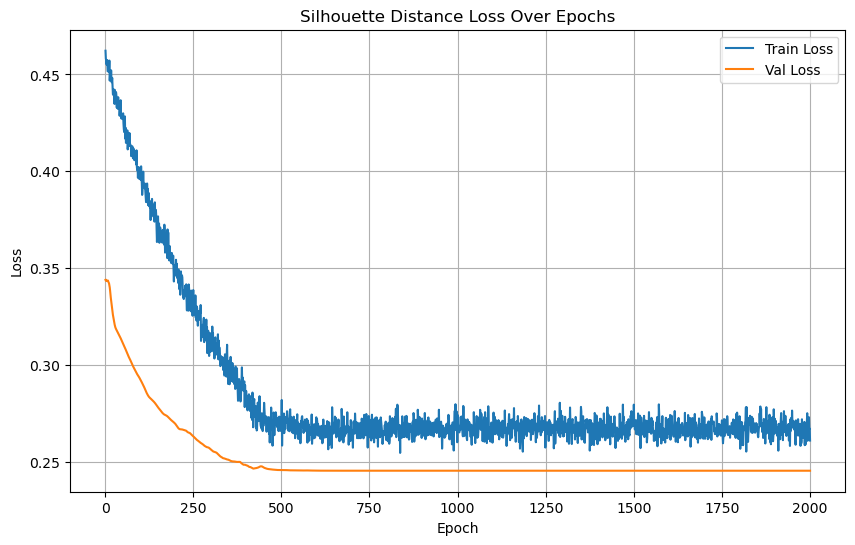

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/843], Loss: 0.1102
Test Batch [20/843], Loss: 0.1458
Test Batch [30/843], Loss: 0.1396
Test Batch [40/843], Loss: 0.1699
Test Batch [50/843], Loss: 0.1548
Test Batch [60/843], Loss: 0.1789
Test Batch [70/843], Loss: 0.5000
Test Batch [80/843], Loss: 0.2142


Test Batch [90/843], Loss: 0.1422
Test Batch [100/843], Loss: 0.2254
Test Batch [110/843], Loss: 0.5000
Test Batch [120/843], Loss: 0.1545
Test Batch [130/843], Loss: 0.1416
Test Batch [140/843], Loss: 0.1414
Test Batch [150/843], Loss: 0.1600
Test Batch [160/843], Loss: 0.1695


Test Batch [170/843], Loss: 0.1520
Test Batch [180/843], Loss: 0.1730
Test Batch [190/843], Loss: 0.1845
Test Batch [200/843], Loss: 0.1087
Test Batch [210/843], Loss: 0.0961


Test Batch [220/843], Loss: 0.1294
Test Batch [230/843], Loss: 0.1328
Test Batch [240/843], Loss: 0.1449
Test Batch [250/843], Loss: 0.1318


Test Batch [260/843], Loss: 0.2224
Test Batch [270/843], Loss: 0.1910
Test Batch [280/843], Loss: 0.2797
Test Batch [290/843], Loss: 0.2428


Test Batch [300/843], Loss: 0.2128
Test Batch [310/843], Loss: 0.2477
Test Batch [320/843], Loss: 0.1697
Test Batch [330/843], Loss: 0.1981
Test Batch [340/843], Loss: 0.2229
Test Batch [350/843], Loss: 0.5000


Test Batch [360/843], Loss: 0.0993
Test Batch [370/843], Loss: 0.5000
Test Batch [380/843], Loss: 0.5000
Test Batch [390/843], Loss: 0.5000
Test Batch [400/843], Loss: 0.5000
Test Batch [410/843], Loss: 0.5000
Test Batch [420/843], Loss: 0.5000
Test Batch [430/843], Loss: 0.0964
Test Batch [440/843], Loss: 0.1040
Test Batch [450/843], Loss: 0.1950


Test Batch [460/843], Loss: 0.1032
Test Batch [470/843], Loss: 0.1309
Test Batch [480/843], Loss: 0.1424
Test Batch [490/843], Loss: 0.5000
Test Batch [500/843], Loss: 0.1147
Test Batch [510/843], Loss: 0.1282


Test Batch [520/843], Loss: 0.1288
Test Batch [530/843], Loss: 0.1690
Test Batch [540/843], Loss: 0.1477
Test Batch [550/843], Loss: 0.5000


Test Batch [560/843], Loss: 0.1671
Test Batch [570/843], Loss: 0.5000
Test Batch [580/843], Loss: 0.1235
Test Batch [590/843], Loss: 0.1455


Test Batch [600/843], Loss: 0.5000
Test Batch [610/843], Loss: 0.1392
Test Batch [620/843], Loss: 0.1212
Test Batch [630/843], Loss: 0.1294
Test Batch [640/843], Loss: 0.1738


Test Batch [650/843], Loss: 0.3946
Test Batch [660/843], Loss: 0.4548
Test Batch [670/843], Loss: 0.1221
Test Batch [680/843], Loss: 0.2311
Test Batch [690/843], Loss: 0.3614


Test Batch [700/843], Loss: 0.1108
Test Batch [710/843], Loss: 0.1536
Test Batch [720/843], Loss: 0.0719
Test Batch [730/843], Loss: 0.1990
Test Batch [740/843], Loss: 0.5000


Test Batch [750/843], Loss: 0.5000
Test Batch [760/843], Loss: 0.1204
Test Batch [770/843], Loss: 0.5000
Test Batch [780/843], Loss: 0.1966
Test Batch [790/843], Loss: 0.5000
Test Batch [800/843], Loss: 0.0888


Test Batch [810/843], Loss: 0.1730
Test Batch [820/843], Loss: 0.5000
Test Batch [830/843], Loss: 0.1317
Test Batch [840/843], Loss: 0.5000

Test Loss: 0.2214


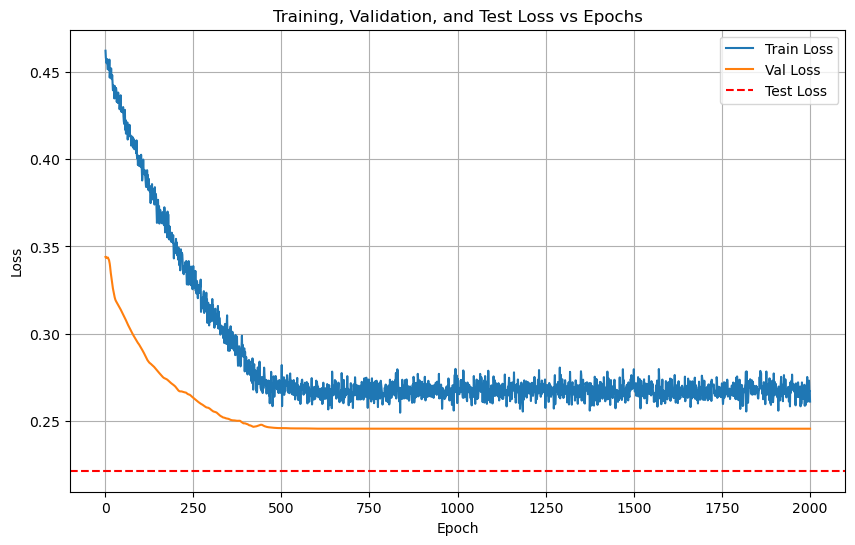

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/843 for test dataset.
  Processed batch 20/843 for test dataset.


  Processed batch 30/843 for test dataset.


  Processed batch 40/843 for test dataset.
  Processed batch 50/843 for test dataset.
  Processed batch 60/843 for test dataset.


  Processed batch 70/843 for test dataset.
  Processed batch 80/843 for test dataset.
  Processed batch 90/843 for test dataset.
  Processed batch 100/843 for test dataset.


  Processed batch 110/843 for test dataset.
  Processed batch 120/843 for test dataset.
  Processed batch 130/843 for test dataset.


  Processed batch 140/843 for test dataset.
  Processed batch 150/843 for test dataset.
  Processed batch 160/843 for test dataset.


  Processed batch 170/843 for test dataset.
  Processed batch 180/843 for test dataset.
  Processed batch 190/843 for test dataset.
  Processed batch 200/843 for test dataset.


  Processed batch 210/843 for test dataset.
  Processed batch 220/843 for test dataset.
  Processed batch 230/843 for test dataset.
  Processed batch 240/843 for test dataset.


  Processed batch 250/843 for test dataset.
  Processed batch 260/843 for test dataset.
  Processed batch 270/843 for test dataset.
  Processed batch 280/843 for test dataset.


  Processed batch 290/843 for test dataset.
  Processed batch 300/843 for test dataset.
  Processed batch 310/843 for test dataset.


  Processed batch 320/843 for test dataset.
  Processed batch 330/843 for test dataset.
  Processed batch 340/843 for test dataset.


  Processed batch 350/843 for test dataset.
  Processed batch 360/843 for test dataset.
  Processed batch 370/843 for test dataset.


  Processed batch 380/843 for test dataset.
  Processed batch 390/843 for test dataset.
  Processed batch 400/843 for test dataset.


  Processed batch 410/843 for test dataset.
  Processed batch 420/843 for test dataset.
  Processed batch 430/843 for test dataset.


  Processed batch 440/843 for test dataset.
  Processed batch 450/843 for test dataset.
  Processed batch 460/843 for test dataset.
  Processed batch 470/843 for test dataset.


  Processed batch 480/843 for test dataset.
  Processed batch 490/843 for test dataset.
  Processed batch 500/843 for test dataset.


  Processed batch 510/843 for test dataset.
  Processed batch 520/843 for test dataset.
  Processed batch 530/843 for test dataset.


  Processed batch 540/843 for test dataset.
  Processed batch 550/843 for test dataset.
  Processed batch 560/843 for test dataset.


  Processed batch 570/843 for test dataset.
  Processed batch 580/843 for test dataset.
  Processed batch 590/843 for test dataset.


  Processed batch 600/843 for test dataset.
  Processed batch 610/843 for test dataset.
  Processed batch 620/843 for test dataset.


  Processed batch 630/843 for test dataset.
  Processed batch 640/843 for test dataset.
  Processed batch 650/843 for test dataset.


  Processed batch 660/843 for test dataset.
  Processed batch 670/843 for test dataset.


  Processed batch 680/843 for test dataset.
  Processed batch 690/843 for test dataset.
  Processed batch 700/843 for test dataset.


  Processed batch 710/843 for test dataset.
  Processed batch 720/843 for test dataset.
  Processed batch 730/843 for test dataset.


  Processed batch 740/843 for test dataset.
  Processed batch 750/843 for test dataset.
  Processed batch 760/843 for test dataset.
  Processed batch 770/843 for test dataset.


  Processed batch 780/843 for test dataset.
  Processed batch 790/843 for test dataset.
  Processed batch 800/843 for test dataset.
  Processed batch 810/843 for test dataset.


  Processed batch 820/843 for test dataset.
  Processed batch 830/843 for test dataset.
  Processed batch 840/843 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 85.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       0.83      1.00      0.91         5
           7       0.67      0.40      0.50         5
           8       0.50      0.60      0.55         5
           9       0.57      0.80      0.67         5
          10       0.40      0.40      0.40         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9089  |  Val Loss: 2.8883
Validation loss improved from inf to 2.8883.
[Epoch 2/1000] Train Loss: 2.8827  |  Val Loss: 2.8692
Validation loss improved from 2.8883 to 2.8692.
[Epoch 3/1000] Train Loss: 2.8587  |  Val Loss: 2.8509
Validation loss improved from 2.8692 to 2.8509.
[Epoch 4/1000] Train Loss: 2.8359  |  Val Loss: 2.8333
Validation loss improved from 2.8509 to 2.8333.
[Epoch 5/1000] Train Loss: 2.8130  |  Val Loss: 2.8158
Validation loss improved from 2.8333 to 2.8158.
[Epoch 6/1000] Train Loss: 2.7916  |  Val Loss: 2.7990
Validation loss improved from 2.8158 to 2.7990.
[Epoch 7/1000] Train Loss: 2.7707  |  Val Loss: 2.7833
Validation loss improved from 2.7990 to 2.7833.
[Epoch 8/1000] Train Loss: 2.7518  |  Val Loss: 2.7679
Validation loss improved from 2.7833 to 2.7679.
[Epoch 9/1000] Train Loss: 2.7330  |  Val Loss: 2.7529
Validation loss improved from 2.7679 to 2.7529.
[Epoch 10/1000] Train Loss: 2.7154  |  Val Loss: 2.7385
Validation loss impr

[Epoch 25/1000] Train Loss: 2.5053  |  Val Loss: 2.5695
Validation loss improved from 2.5807 to 2.5695.
[Epoch 26/1000] Train Loss: 2.4920  |  Val Loss: 2.5582
Validation loss improved from 2.5695 to 2.5582.
[Epoch 27/1000] Train Loss: 2.4782  |  Val Loss: 2.5471
Validation loss improved from 2.5582 to 2.5471.
[Epoch 28/1000] Train Loss: 2.4646  |  Val Loss: 2.5362
Validation loss improved from 2.5471 to 2.5362.
[Epoch 29/1000] Train Loss: 2.4501  |  Val Loss: 2.5254
Validation loss improved from 2.5362 to 2.5254.
[Epoch 30/1000] Train Loss: 2.4365  |  Val Loss: 2.5146
Validation loss improved from 2.5254 to 2.5146.
[Epoch 31/1000] Train Loss: 2.4228  |  Val Loss: 2.5035
Validation loss improved from 2.5146 to 2.5035.
[Epoch 32/1000] Train Loss: 2.4090  |  Val Loss: 2.4922
Validation loss improved from 2.5035 to 2.4922.
[Epoch 33/1000] Train Loss: 2.3942  |  Val Loss: 2.4809
Validation loss improved from 2.4922 to 2.4809.
[Epoch 34/1000] Train Loss: 2.3804  |  Val Loss: 2.4691
Validati

[Epoch 57/1000] Train Loss: 2.0526  |  Val Loss: 2.1882
Validation loss improved from 2.2006 to 2.1882.
[Epoch 58/1000] Train Loss: 2.0379  |  Val Loss: 2.1758
Validation loss improved from 2.1882 to 2.1758.
[Epoch 59/1000] Train Loss: 2.0238  |  Val Loss: 2.1631
Validation loss improved from 2.1758 to 2.1631.
[Epoch 60/1000] Train Loss: 2.0093  |  Val Loss: 2.1505
Validation loss improved from 2.1631 to 2.1505.
[Epoch 61/1000] Train Loss: 1.9951  |  Val Loss: 2.1379
Validation loss improved from 2.1505 to 2.1379.
[Epoch 62/1000] Train Loss: 1.9806  |  Val Loss: 2.1253
Validation loss improved from 2.1379 to 2.1253.
[Epoch 63/1000] Train Loss: 1.9662  |  Val Loss: 2.1126
Validation loss improved from 2.1253 to 2.1126.
[Epoch 64/1000] Train Loss: 1.9514  |  Val Loss: 2.0998
Validation loss improved from 2.1126 to 2.0998.
[Epoch 65/1000] Train Loss: 1.9374  |  Val Loss: 2.0869
Validation loss improved from 2.0998 to 2.0869.
[Epoch 66/1000] Train Loss: 1.9225  |  Val Loss: 2.0741
Validati

[Epoch 86/1000] Train Loss: 1.6199  |  Val Loss: 1.7985
Validation loss improved from 1.8127 to 1.7985.
[Epoch 87/1000] Train Loss: 1.6048  |  Val Loss: 1.7844
Validation loss improved from 1.7985 to 1.7844.
[Epoch 88/1000] Train Loss: 1.5897  |  Val Loss: 1.7706
Validation loss improved from 1.7844 to 1.7706.
[Epoch 89/1000] Train Loss: 1.5751  |  Val Loss: 1.7566
Validation loss improved from 1.7706 to 1.7566.
[Epoch 90/1000] Train Loss: 1.5598  |  Val Loss: 1.7429
Validation loss improved from 1.7566 to 1.7429.
[Epoch 91/1000] Train Loss: 1.5451  |  Val Loss: 1.7293
Validation loss improved from 1.7429 to 1.7293.
[Epoch 92/1000] Train Loss: 1.5308  |  Val Loss: 1.7156
Validation loss improved from 1.7293 to 1.7156.
[Epoch 93/1000] Train Loss: 1.5157  |  Val Loss: 1.7025
Validation loss improved from 1.7156 to 1.7025.
[Epoch 94/1000] Train Loss: 1.5012  |  Val Loss: 1.6893
Validation loss improved from 1.7025 to 1.6893.
[Epoch 95/1000] Train Loss: 1.4867  |  Val Loss: 1.6761
Validati

[Epoch 116/1000] Train Loss: 1.1814  |  Val Loss: 1.3955
Validation loss improved from 1.4085 to 1.3955.
[Epoch 117/1000] Train Loss: 1.1672  |  Val Loss: 1.3825
Validation loss improved from 1.3955 to 1.3825.
[Epoch 118/1000] Train Loss: 1.1537  |  Val Loss: 1.3697
Validation loss improved from 1.3825 to 1.3697.
[Epoch 119/1000] Train Loss: 1.1394  |  Val Loss: 1.3570
Validation loss improved from 1.3697 to 1.3570.
[Epoch 120/1000] Train Loss: 1.1256  |  Val Loss: 1.3443
Validation loss improved from 1.3570 to 1.3443.
[Epoch 121/1000] Train Loss: 1.1119  |  Val Loss: 1.3318
Validation loss improved from 1.3443 to 1.3318.
[Epoch 122/1000] Train Loss: 1.0985  |  Val Loss: 1.3194
Validation loss improved from 1.3318 to 1.3194.
[Epoch 123/1000] Train Loss: 1.0847  |  Val Loss: 1.3070
Validation loss improved from 1.3194 to 1.3070.
[Epoch 124/1000] Train Loss: 1.0718  |  Val Loss: 1.2947
Validation loss improved from 1.3070 to 1.2947.
[Epoch 125/1000] Train Loss: 1.0583  |  Val Loss: 1.282

[Epoch 146/1000] Train Loss: 0.8011  |  Val Loss: 1.0418
Validation loss improved from 1.0517 to 1.0418.
[Epoch 147/1000] Train Loss: 0.7907  |  Val Loss: 1.0320
Validation loss improved from 1.0418 to 1.0320.
[Epoch 148/1000] Train Loss: 0.7804  |  Val Loss: 1.0223
Validation loss improved from 1.0320 to 1.0223.
[Epoch 149/1000] Train Loss: 0.7702  |  Val Loss: 1.0130
Validation loss improved from 1.0223 to 1.0130.
[Epoch 150/1000] Train Loss: 0.7601  |  Val Loss: 1.0041
Validation loss improved from 1.0130 to 1.0041.
[Epoch 151/1000] Train Loss: 0.7501  |  Val Loss: 0.9954
Validation loss improved from 1.0041 to 0.9954.
[Epoch 152/1000] Train Loss: 0.7406  |  Val Loss: 0.9866
Validation loss improved from 0.9954 to 0.9866.
[Epoch 153/1000] Train Loss: 0.7307  |  Val Loss: 0.9780
Validation loss improved from 0.9866 to 0.9780.
[Epoch 154/1000] Train Loss: 0.7211  |  Val Loss: 0.9694
Validation loss improved from 0.9780 to 0.9694.
[Epoch 155/1000] Train Loss: 0.7120  |  Val Loss: 0.960

[Epoch 172/1000] Train Loss: 0.5688  |  Val Loss: 0.8291
Validation loss improved from 0.8363 to 0.8291.
[Epoch 173/1000] Train Loss: 0.5610  |  Val Loss: 0.8223
Validation loss improved from 0.8291 to 0.8223.
[Epoch 174/1000] Train Loss: 0.5537  |  Val Loss: 0.8157
Validation loss improved from 0.8223 to 0.8157.
[Epoch 175/1000] Train Loss: 0.5467  |  Val Loss: 0.8092
Validation loss improved from 0.8157 to 0.8092.
[Epoch 176/1000] Train Loss: 0.5393  |  Val Loss: 0.8030
Validation loss improved from 0.8092 to 0.8030.
[Epoch 177/1000] Train Loss: 0.5323  |  Val Loss: 0.7969
Validation loss improved from 0.8030 to 0.7969.
[Epoch 178/1000] Train Loss: 0.5254  |  Val Loss: 0.7906
Validation loss improved from 0.7969 to 0.7906.
[Epoch 179/1000] Train Loss: 0.5189  |  Val Loss: 0.7847
Validation loss improved from 0.7906 to 0.7847.
[Epoch 180/1000] Train Loss: 0.5120  |  Val Loss: 0.7788
Validation loss improved from 0.7847 to 0.7788.
[Epoch 181/1000] Train Loss: 0.5057  |  Val Loss: 0.773

[Epoch 199/1000] Train Loss: 0.4046  |  Val Loss: 0.6851
Validation loss improved from 0.6893 to 0.6851.
[Epoch 200/1000] Train Loss: 0.3997  |  Val Loss: 0.6811
Validation loss improved from 0.6851 to 0.6811.
[Epoch 201/1000] Train Loss: 0.3949  |  Val Loss: 0.6772
Validation loss improved from 0.6811 to 0.6772.
[Epoch 202/1000] Train Loss: 0.3904  |  Val Loss: 0.6735
Validation loss improved from 0.6772 to 0.6735.
[Epoch 203/1000] Train Loss: 0.3862  |  Val Loss: 0.6698
Validation loss improved from 0.6735 to 0.6698.
[Epoch 204/1000] Train Loss: 0.3815  |  Val Loss: 0.6660
Validation loss improved from 0.6698 to 0.6660.
[Epoch 205/1000] Train Loss: 0.3773  |  Val Loss: 0.6623
Validation loss improved from 0.6660 to 0.6623.
[Epoch 206/1000] Train Loss: 0.3731  |  Val Loss: 0.6589
Validation loss improved from 0.6623 to 0.6589.
[Epoch 207/1000] Train Loss: 0.3688  |  Val Loss: 0.6556
Validation loss improved from 0.6589 to 0.6556.
[Epoch 208/1000] Train Loss: 0.3647  |  Val Loss: 0.652

[Epoch 229/1000] Train Loss: 0.2939  |  Val Loss: 0.5932
Validation loss improved from 0.5958 to 0.5932.
[Epoch 230/1000] Train Loss: 0.2912  |  Val Loss: 0.5910
Validation loss improved from 0.5932 to 0.5910.
[Epoch 231/1000] Train Loss: 0.2884  |  Val Loss: 0.5889
Validation loss improved from 0.5910 to 0.5889.
[Epoch 232/1000] Train Loss: 0.2858  |  Val Loss: 0.5868
Validation loss improved from 0.5889 to 0.5868.
[Epoch 233/1000] Train Loss: 0.2831  |  Val Loss: 0.5846
Validation loss improved from 0.5868 to 0.5846.
[Epoch 234/1000] Train Loss: 0.2807  |  Val Loss: 0.5825
Validation loss improved from 0.5846 to 0.5825.
[Epoch 235/1000] Train Loss: 0.2780  |  Val Loss: 0.5803
Validation loss improved from 0.5825 to 0.5803.
[Epoch 236/1000] Train Loss: 0.2755  |  Val Loss: 0.5781
Validation loss improved from 0.5803 to 0.5781.
[Epoch 237/1000] Train Loss: 0.2729  |  Val Loss: 0.5760
Validation loss improved from 0.5781 to 0.5760.
[Epoch 238/1000] Train Loss: 0.2705  |  Val Loss: 0.573

[Epoch 259/1000] Train Loss: 0.2276  |  Val Loss: 0.5408
Validation loss improved from 0.5421 to 0.5408.
[Epoch 260/1000] Train Loss: 0.2259  |  Val Loss: 0.5397
Validation loss improved from 0.5408 to 0.5397.
[Epoch 261/1000] Train Loss: 0.2242  |  Val Loss: 0.5386
Validation loss improved from 0.5397 to 0.5386.
[Epoch 262/1000] Train Loss: 0.2225  |  Val Loss: 0.5377
Validation loss improved from 0.5386 to 0.5377.
[Epoch 263/1000] Train Loss: 0.2209  |  Val Loss: 0.5368
Validation loss improved from 0.5377 to 0.5368.
[Epoch 264/1000] Train Loss: 0.2193  |  Val Loss: 0.5359
Validation loss improved from 0.5368 to 0.5359.
[Epoch 265/1000] Train Loss: 0.2178  |  Val Loss: 0.5350
Validation loss improved from 0.5359 to 0.5350.
[Epoch 266/1000] Train Loss: 0.2159  |  Val Loss: 0.5340
Validation loss improved from 0.5350 to 0.5340.
[Epoch 267/1000] Train Loss: 0.2143  |  Val Loss: 0.5330
Validation loss improved from 0.5340 to 0.5330.
[Epoch 268/1000] Train Loss: 0.2128  |  Val Loss: 0.531

[Epoch 288/1000] Train Loss: 0.1846  |  Val Loss: 0.5127
Validation loss improved from 0.5137 to 0.5127.
[Epoch 289/1000] Train Loss: 0.1834  |  Val Loss: 0.5118
Validation loss improved from 0.5127 to 0.5118.
[Epoch 290/1000] Train Loss: 0.1823  |  Val Loss: 0.5108
Validation loss improved from 0.5118 to 0.5108.
[Epoch 291/1000] Train Loss: 0.1810  |  Val Loss: 0.5100
Validation loss improved from 0.5108 to 0.5100.
[Epoch 292/1000] Train Loss: 0.1801  |  Val Loss: 0.5091
Validation loss improved from 0.5100 to 0.5091.
[Epoch 293/1000] Train Loss: 0.1787  |  Val Loss: 0.5083
Validation loss improved from 0.5091 to 0.5083.
[Epoch 294/1000] Train Loss: 0.1777  |  Val Loss: 0.5074
Validation loss improved from 0.5083 to 0.5074.
[Epoch 295/1000] Train Loss: 0.1767  |  Val Loss: 0.5066
Validation loss improved from 0.5074 to 0.5066.
[Epoch 296/1000] Train Loss: 0.1755  |  Val Loss: 0.5059
Validation loss improved from 0.5066 to 0.5059.
[Epoch 297/1000] Train Loss: 0.1744  |  Val Loss: 0.505

[Epoch 316/1000] Train Loss: 0.1556  |  Val Loss: 0.4951
Validation loss improved from 0.4956 to 0.4951.
[Epoch 317/1000] Train Loss: 0.1547  |  Val Loss: 0.4944
Validation loss improved from 0.4951 to 0.4944.
[Epoch 318/1000] Train Loss: 0.1539  |  Val Loss: 0.4937
Validation loss improved from 0.4944 to 0.4937.
[Epoch 319/1000] Train Loss: 0.1532  |  Val Loss: 0.4934
Validation loss improved from 0.4937 to 0.4934.
[Epoch 320/1000] Train Loss: 0.1522  |  Val Loss: 0.4931
Validation loss improved from 0.4934 to 0.4931.
[Epoch 321/1000] Train Loss: 0.1513  |  Val Loss: 0.4926
Validation loss improved from 0.4931 to 0.4926.
[Epoch 322/1000] Train Loss: 0.1505  |  Val Loss: 0.4923
Validation loss improved from 0.4926 to 0.4923.
[Epoch 323/1000] Train Loss: 0.1497  |  Val Loss: 0.4920
Validation loss improved from 0.4923 to 0.4920.
[Epoch 324/1000] Train Loss: 0.1489  |  Val Loss: 0.4921
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 325/1000] Train Loss: 0.1481  |  Val Loss:

[Epoch 344/1000] Train Loss: 0.1345  |  Val Loss: 0.4903
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 345/1000] Train Loss: 0.1338  |  Val Loss: 0.4905
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 346/1000] Train Loss: 0.1332  |  Val Loss: 0.4906
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 347/1000] Train Loss: 0.1326  |  Val Loss: 0.4907
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 348/1000] Train Loss: 0.1320  |  Val Loss: 0.4908
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 349/1000] Train Loss: 0.1313  |  Val Loss: 0.4908
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 350/1000] Train Loss: 0.1308  |  Val Loss: 0.4908
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 351/1000] Train Loss: 0.1301  |  Val Loss: 0.4908
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 352/1000] Train Loss: 0.1294  |  Val Loss: 0.4909
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 374/1000] Train Loss: 0.1173  |  Val Loss: 0.4898
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 375/1000] Train Loss: 0.1168  |  Val Loss: 0.4897
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 376/1000] Train Loss: 0.1163  |  Val Loss: 0.4895
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 377/1000] Train Loss: 0.1158  |  Val Loss: 0.4888
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 378/1000] Train Loss: 0.1152  |  Val Loss: 0.4884
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 379/1000] Train Loss: 0.1150  |  Val Loss: 0.4883
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 380/1000] Train Loss: 0.1144  |  Val Loss: 0.4882
Validation loss improved from 0.4882 to 0.4882.
[Epoch 381/1000] Train Loss: 0.1140  |  Val Loss: 0.4880
Validation loss improved from 0.4882 to 0.4880.
[Epoch 382/1000] Train Loss: 0.1134  |  Val Loss: 0.4875
Validation loss improved from 0.4880 to 0.4875.
[Epoch 383/10

[Epoch 403/1000] Train Loss: 0.1043  |  Val Loss: 0.4895
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 404/1000] Train Loss: 0.1039  |  Val Loss: 0.4894
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 405/1000] Train Loss: 0.1036  |  Val Loss: 0.4890
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 406/1000] Train Loss: 0.1031  |  Val Loss: 0.4891
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 407/1000] Train Loss: 0.1027  |  Val Loss: 0.4895
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 408/1000] Train Loss: 0.1024  |  Val Loss: 0.4898
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 409/1000] Train Loss: 0.1020  |  Val Loss: 0.4899
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 410/1000] Train Loss: 0.1018  |  Val Loss: 0.4900
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 411/1000] Train Loss: 0.1012  |  Val Loss: 0.4905
!! Validation loss did NOT improve !! Patience:

[Epoch 432/1000] Train Loss: 0.0938  |  Val Loss: 0.4929
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 433/1000] Train Loss: 0.0934  |  Val Loss: 0.4929
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 434/1000] Train Loss: 0.0931  |  Val Loss: 0.4930
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 435/1000] Train Loss: 0.0928  |  Val Loss: 0.4933
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 436/1000] Train Loss: 0.0925  |  Val Loss: 0.4935
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 437/1000] Train Loss: 0.0921  |  Val Loss: 0.4937
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 438/1000] Train Loss: 0.0919  |  Val Loss: 0.4940
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 439/1000] Train Loss: 0.0915  |  Val Loss: 0.4944
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 440/1000] Train Loss: 0.0912  |  Val Loss: 0.4948
!! Validation loss did NOT improve !! Patience:

[Epoch 460/1000] Train Loss: 0.0851  |  Val Loss: 0.4988
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 461/1000] Train Loss: 0.0848  |  Val Loss: 0.4990
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 462/1000] Train Loss: 0.0845  |  Val Loss: 0.4990
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 463/1000] Train Loss: 0.0842  |  Val Loss: 0.4991
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 464/1000] Train Loss: 0.0839  |  Val Loss: 0.4996
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 465/1000] Train Loss: 0.0836  |  Val Loss: 0.4996
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 466/1000] Train Loss: 0.0833  |  Val Loss: 0.5000
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 467/1000] Train Loss: 0.0830  |  Val Loss: 0.5002
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 468/1000] Train Loss: 0.0828  |  Val Loss: 0.5005
!! Validation loss did NOT improve !! Patience:

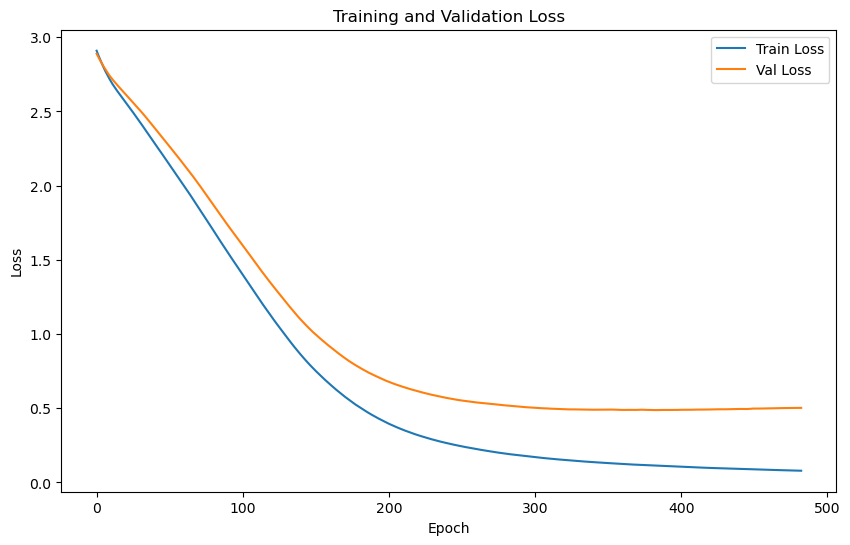

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.6620 | Test Accuracy: 78.50%


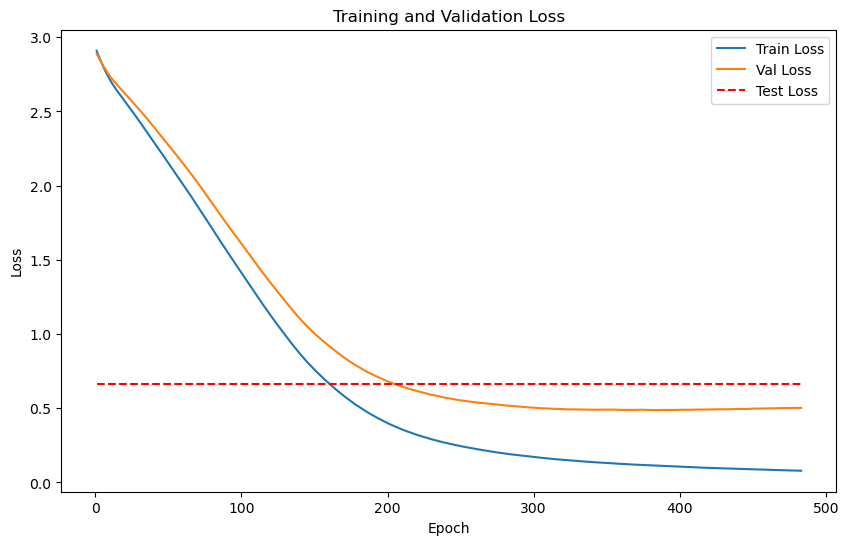

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


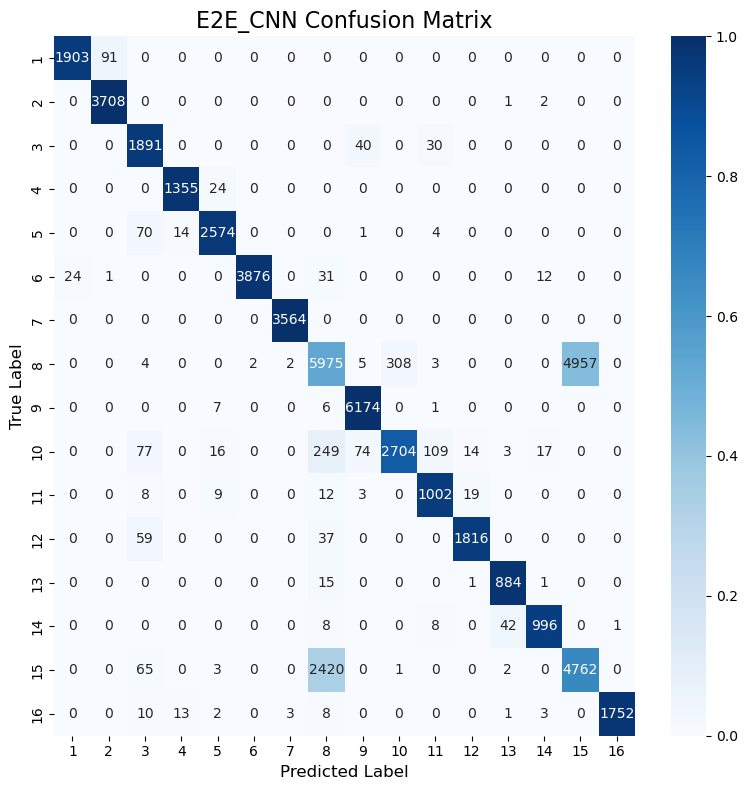

Classification Accuracy: 83.39%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


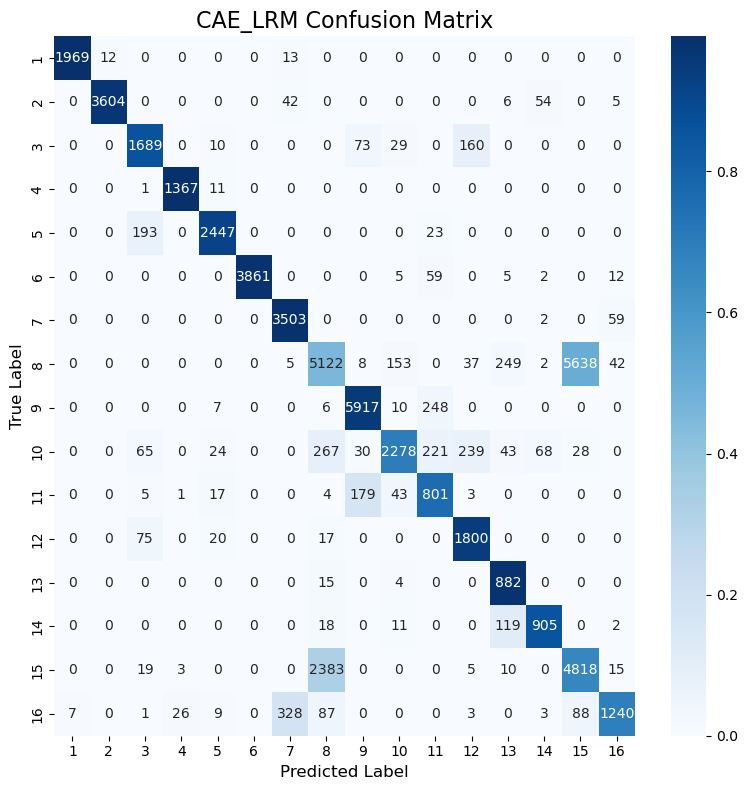

Classification Accuracy: 78.31%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


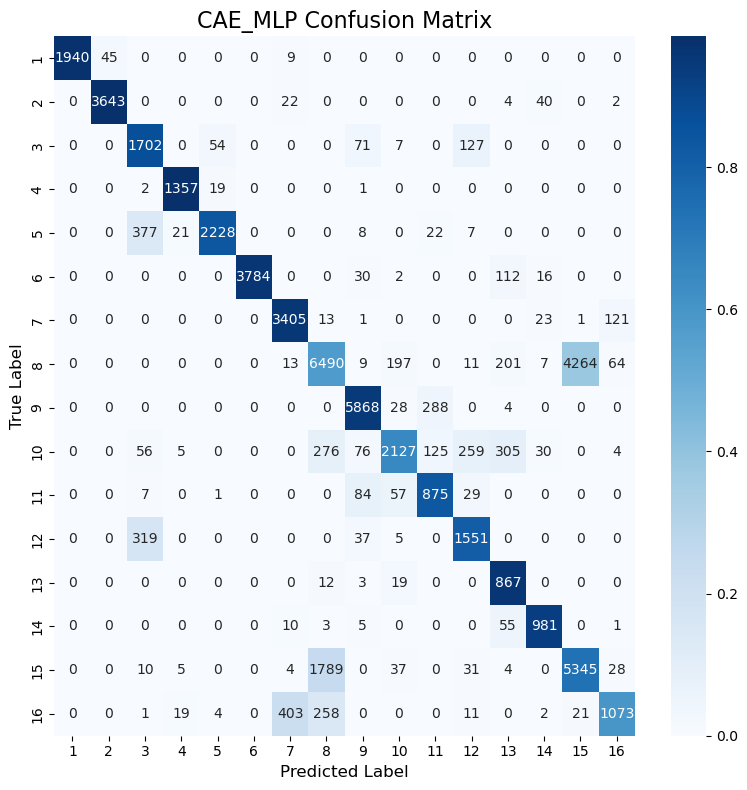

Classification Accuracy: 80.23%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


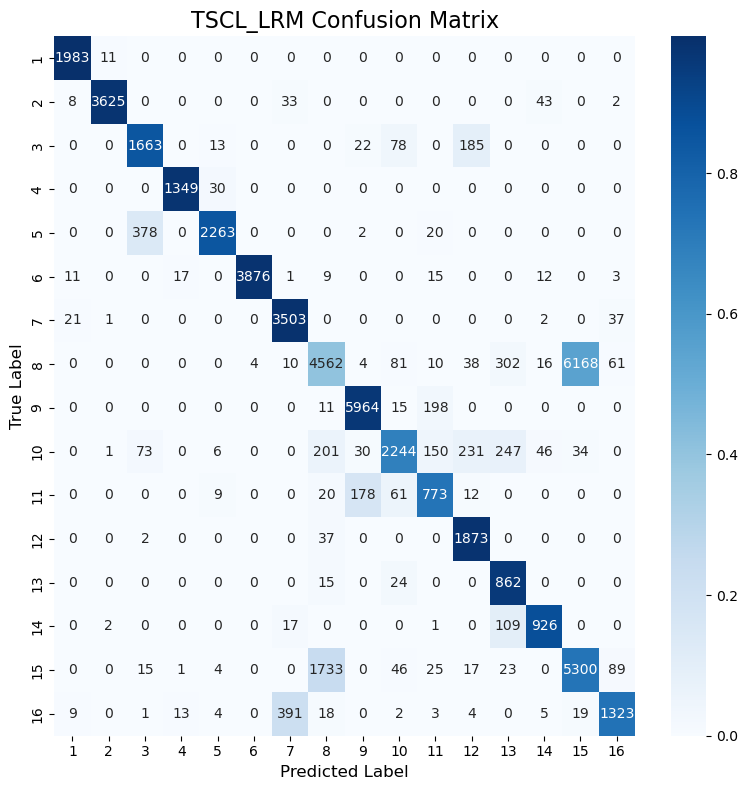

Classification Accuracy: 78.10%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


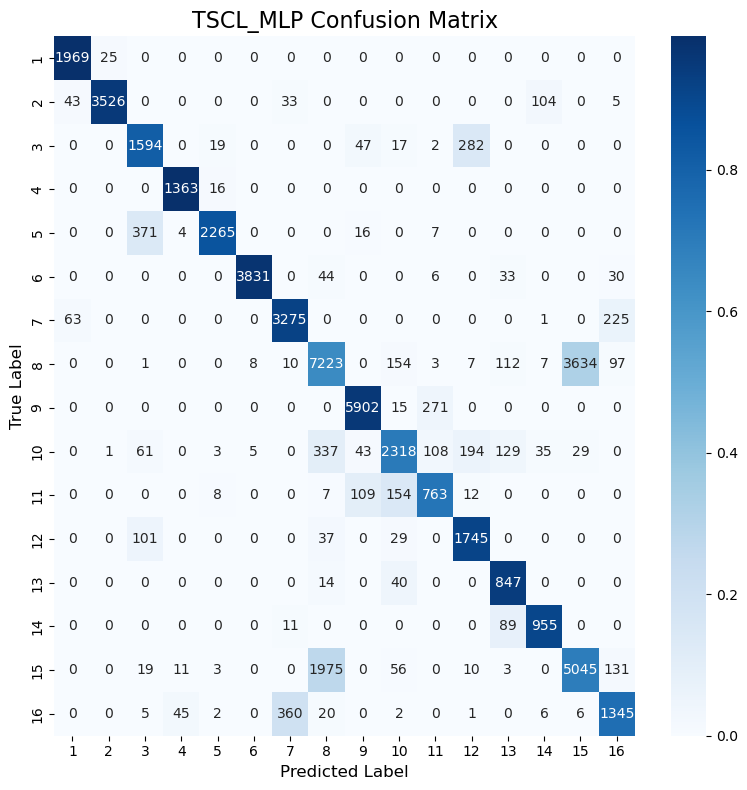

Classification Accuracy: 81.59%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


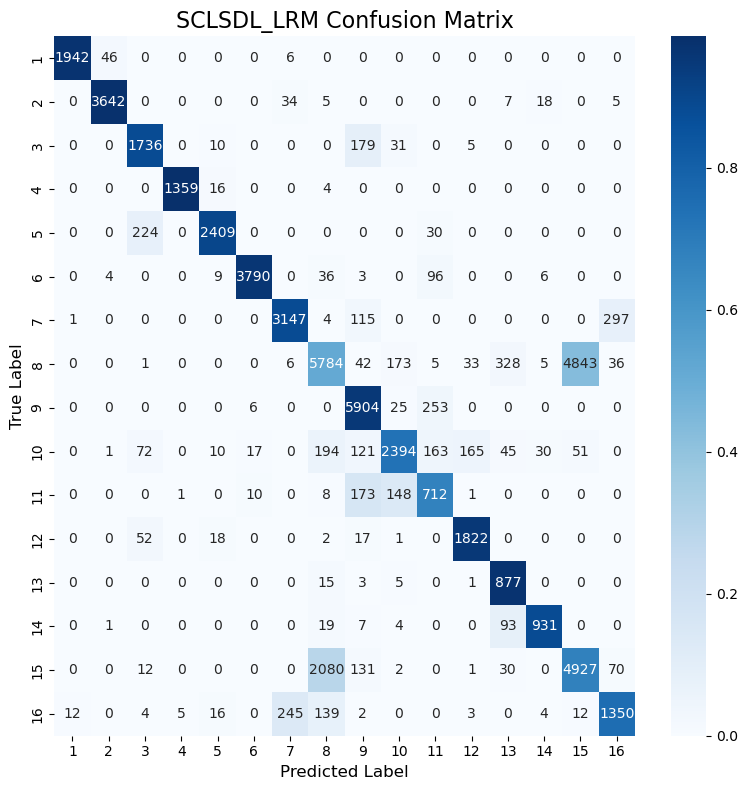

Classification Accuracy: 79.29%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


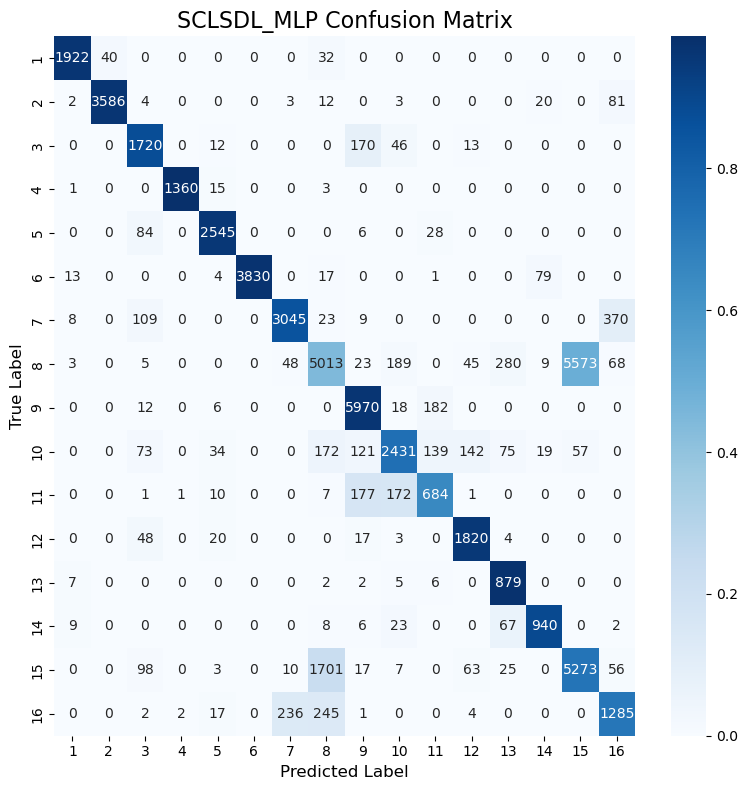

Classification Accuracy: 78.50%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          83.39
1    LRM (CAE)          78.31
2    MLP (CAE)          80.23
3     TSCL LRM          78.10
4     TSCL MLP          81.59
5  SCL_SDL LRM          79.29
6  SCL_SDL MLP          78.50

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          83.39
4     TSCL MLP          81.59
2    MLP (CAE)          80.23
5  SCL_SDL LRM          79.29
6  SCL_SDL MLP          78.50
1    LRM (CAE)          78.31
3     TSCL LRM          78.10
